In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [14]:
df = pd.read_csv('train.csv', sep = ',')
X = df.loc[:,'var_0':'var_199']
Y = df.loc[:,'target']
X.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [15]:
fraud_index = np.where(Y==1)
honest_index = np.where(Y==0)
fraud = X.loc[fraud_index]
honest = X.loc[honest_index]

In [16]:
yh = Y.loc[honest_index]
yf = Y.loc[fraud_index]

In [17]:
h_train, h_test, hy_train, hy_test = train_test_split(honest, yh,test_size=0.3,
                                                      random_state=30)
h_test, h_val, hy_test, hy_val = train_test_split(h_test, hy_test,test_size=0.5,
                                                  random_state=30)


f_train, f_test, fy_train, fy_test = train_test_split(fraud, yf,test_size=0.3,
                                                      random_state=30)
f_test, f_val, fy_test, fy_val = train_test_split(f_test, fy_test,test_size=0.5,
                                                  random_state=30)


In [18]:
len(h_train)/len(f_train)

8.951592266135911

In [19]:
f_train = pd.concat([f_train, f_train, f_train], ignore_index=False)
fy_train = pd.concat([fy_train, fy_train, fy_train], ignore_index=False)

In [20]:
len(h_train)/len(f_train)

2.9838640887119703

In [21]:
x_train = pd.concat([h_train,f_train],ignore_index = True)
x_test = pd.concat([h_test,f_test],ignore_index = True)
x_val = pd.concat([h_val,f_val],ignore_index = True)

y_train = pd.concat([hy_train,fy_train],ignore_index = True)
y_test = pd.concat([hy_test,fy_test],ignore_index = True)
y_val = pd.concat([hy_val,fy_val],ignore_index = True)

In [22]:
meanx = x_train.mean(axis = 0)
stdx = x_train.std(axis = 0)
x_train_norm = (x_train - meanx)/stdx
x_val_norm = (x_val - meanx)/stdx
x_test_norm = (x_test - meanx)/stdx
x_train_norm=np.asarray(x_train_norm)
x_test_norm=np.asarray(x_test_norm)
x_val_norm=np.asarray(x_val_norm)

In [23]:
import keras
from keras import models
from keras import layers
import tensorflow as tf
from keras.backend import binary_crossentropy
from keras import backend as K
from keras.callbacks import Callback
from keras import optimizers
from keras.backend import mean
from keras import regularizers
from keras.layers import Dropout

Using TensorFlow backend.


In [24]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.clear_session()

In [25]:
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)
y_val = np.asarray(y_val)

In [26]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [27]:
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [28]:
class new_rna:
    def build_model(self,data_shape,units_list,activation_list,dropout_list):
        self.model = models.Sequential()
        if len(dropout_list)<0:
            my_init = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=1)
            for i in range(len(units_list)):
                if i == 0:
                    self.model.add(layers.Dense(units=units_list[i], 
                                                activation=activation_list[i], 
                                                kernel_initializer = my_init,
                                                input_shape=data_shape))
                else:
                    self.model.add(layers.Dense(units=units_list[i], 
                                                activation=activation_list[i]))
        else:
            my_init = keras.initializers.RandomUniform(minval=-0.05, 
                                                       maxval=0.05, 
                                                       seed=1)
            for i in range(len(units_list)):
                if i == 0:
                    self.model.add(layers.Dense(units=units_list[i], 
                                                activation=activation_list[i],
                                                kernel_initializer = my_init,
                                                input_shape=data_shape))
                else:
                    self.model.add(layers.Dropout(dropout_list[i-1]))
                    self.model.add(layers.Dense(units=units_list[i], 
                                                activation=activation_list[i]))
        self.model.summary()
           
    def train(self,x_train,y_train,x_val,y_val,batch_size,epochs,loss,metric):
        mom = optimizers.SGD(lr=0.001, decay=0, momentum=0.9, nesterov=True)
        self.model.compile(loss = [loss],metrics = [metric], optimizer = mom)
        history = self.model.fit(x_train,y_train,batch_size = batch_size,epochs = epochs,validation_data = (x_val,y_val))
        self.history_dict = history.history
        self.aux_train = 1
        
    def plot(self):
        if (self.aux_train == 1):
            self.aux_plt = 1
            cost = self.history_dict['loss']
            metric = self.history_dict['f1']
            val_cost = self.history_dict['val_loss']
            val_metric = self.history_dict['val_f1']
            aux_epocas = range(1,len(cost)+1)
            plt.plot(aux_epocas,cost,'b',label = 'Custo - treinamento', color = 'red')
            plt.plot(aux_epocas,val_cost,'b',label = 'Custo - validacao', color = 'blue')
            plt.title(' Valor da Funcao Custo = Treinamento e Validacao')
            plt.xlabel('Épocas')
            plt.ylabel('Custo')
            plt.legend()
            plt.show()
            plt.plot(aux_epocas, metric,'b',label = 'metrica - treinamento',color = 'red')
            plt.plot(aux_epocas, val_metric,'b',label = 'metrica - validacao', color = 'blue')
            plt.title('Valor da métrica – treinamento e validação')
            plt.xlabel('Épocas')
            plt.ylabel('Acertividade')
            plt.legend()
            plt.show()
        else:
            print('Train before plot')

    def predict(self,x_data,y_data):
        if (self.aux_plt == 1):
            class_names = np.array([['Honest'],['Fraud']])
            subtitle = ['Test', 'Val', 'Train']
            for i in range(len(x_data)):
                y_hat = self.model.predict(x_data[i])
                yy_hat = np.round(y_hat)
                yy_hat = yy_hat.astype(int)
                yy_hat = np.ravel(yy_hat)
                f1 = f1_score(y_data[i],yy_hat)
                plot_confusion_matrix(np.int_(y_data[i]), np.int_(yy_hat), classes=class_names,
                                      title='F1_Score = {0}: {1} Data'.format(f1, subtitle[i]))
                plt.show()
            K.clear_session()
        else:
            print('Train before predict')

In [29]:
data_shape = (200,)

loss = 'binary_crossentropy'
metric = f1
batch_size = 32
epochs = 2000

x_data = [x_test_norm,x_val_norm,x_train_norm]
y_data = [y_test,y_val,y_train]

In [30]:
n_list0 = [50,1]
activation_list0 = ['tanh','sigmoid']
dropout_list0 = [0.3]

In [31]:
rna0 = new_rna()
rna0.build_model(data_shape,n_list0,activation_list0,dropout_list0)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 10,101
Trainable params: 10,101
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Use tf.cast instead.
Train on 168135 samples, validate on 30001 samples
Epoch 1/2000
168135/168135 [==============================] - 7s 44us/step - loss: 0.4026 - f1: 0.5736 - val_loss: 0.2845 - val_f1: 0.0691
Epoch 2/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.3889 - f1: 0.5879 - val_loss: 0.2801 - val_f1: 0.0682
Epoch 3/2000
168135/168135 [==============================] - 7s 41us/step - loss: 0.3869 - f1: 0.5885 - val_loss: 0.2853 - val_f1: 0.0700
Epoch 4/2000
168135/168135 [==============================] - 7s 39us/step - loss: 0.3861 - f1: 0.5920 - val_loss: 0.2813 - val_f1: 0.0696
Epoch 5/2000
168135/168135 [==============================] - 6s 35us/step - loss: 0.3852 - f1: 0.5930 - val_loss: 0.2828 - val_f1: 0.0697
Epoch 6/2000
168135/168135 [==============================] - 6s 35us/step - loss: 0.3847 - f1: 0.5922 - val_loss: 0.2832 - val_f1: 0.0699
Epoch 7/2000
168135/168135 [==============================] - 6s 35

168135/168135 [==============================] - 10s 59us/step - loss: 0.3607 - f1: 0.6198 - val_loss: 0.2725 - val_f1: 0.0679
Epoch 58/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.3592 - f1: 0.6220 - val_loss: 0.2738 - val_f1: 0.0687
Epoch 59/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.3596 - f1: 0.6240 - val_loss: 0.2739 - val_f1: 0.0685
Epoch 60/2000
168135/168135 [==============================] - 10s 58us/step - loss: 0.3591 - f1: 0.6213 - val_loss: 0.2718 - val_f1: 0.0675
Epoch 61/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.3574 - f1: 0.6228 - val_loss: 0.2761 - val_f1: 0.0687
Epoch 62/2000
168135/168135 [==============================] - 10s 61us/step - loss: 0.3572 - f1: 0.6246 - val_loss: 0.2733 - val_f1: 0.0684
Epoch 63/2000
168135/168135 [==============================] - 10s 58us/step - loss: 0.3567 - f1: 0.6229 - val_loss: 0.2734 - val_f1: 0.0678
Epoch 64/2000
168135/168135

168135/168135 [==============================] - 10s 59us/step - loss: 0.3343 - f1: 0.6553 - val_loss: 0.2731 - val_f1: 0.0677
Epoch 116/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.3333 - f1: 0.6591 - val_loss: 0.2729 - val_f1: 0.0673
Epoch 117/2000
168135/168135 [==============================] - 10s 61us/step - loss: 0.3333 - f1: 0.6609 - val_loss: 0.2712 - val_f1: 0.0674
Epoch 118/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.3335 - f1: 0.6578 - val_loss: 0.2712 - val_f1: 0.0673
Epoch 119/2000
168135/168135 [==============================] - 10s 58us/step - loss: 0.3327 - f1: 0.6587 - val_loss: 0.2720 - val_f1: 0.0673
Epoch 120/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.3339 - f1: 0.6613 - val_loss: 0.2694 - val_f1: 0.0666
Epoch 121/2000
168135/168135 [==============================] - 10s 58us/step - loss: 0.3332 - f1: 0.6593 - val_loss: 0.2717 - val_f1: 0.0675
Epoch 122/2000
168135

Epoch 173/2000
168135/168135 [==============================] - 10s 58us/step - loss: 0.3208 - f1: 0.6745 - val_loss: 0.2708 - val_f1: 0.0662
Epoch 174/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.3209 - f1: 0.6750 - val_loss: 0.2729 - val_f1: 0.0669
Epoch 175/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.3198 - f1: 0.6753 - val_loss: 0.2738 - val_f1: 0.0671
Epoch 176/2000
168135/168135 [==============================] - 10s 58us/step - loss: 0.3198 - f1: 0.6789 - val_loss: 0.2741 - val_f1: 0.0672
Epoch 177/2000
168135/168135 [==============================] - 10s 61us/step - loss: 0.3209 - f1: 0.6726 - val_loss: 0.2730 - val_f1: 0.0667
Epoch 178/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.3200 - f1: 0.6763 - val_loss: 0.2730 - val_f1: 0.0671
Epoch 179/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.3199 - f1: 0.6768 - val_loss: 0.2723 - val_f1: 0.0667
Epoch 

168135/168135 [==============================] - 10s 58us/step - loss: 0.3133 - f1: 0.6835 - val_loss: 0.2741 - val_f1: 0.0663
Epoch 231/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.3112 - f1: 0.6880 - val_loss: 0.2735 - val_f1: 0.0663
Epoch 232/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.3120 - f1: 0.6878 - val_loss: 0.2724 - val_f1: 0.0658
Epoch 233/2000
168135/168135 [==============================] - 10s 58us/step - loss: 0.3126 - f1: 0.6863 - val_loss: 0.2752 - val_f1: 0.0667
Epoch 234/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.3124 - f1: 0.6872 - val_loss: 0.2736 - val_f1: 0.0662
Epoch 235/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.3112 - f1: 0.6913 - val_loss: 0.2735 - val_f1: 0.0663
Epoch 236/2000
168135/168135 [==============================] - 10s 58us/step - loss: 0.3114 - f1: 0.6875 - val_loss: 0.2728 - val_f1: 0.0659
Epoch 237/2000
168135

Epoch 288/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.3078 - f1: 0.6918 - val_loss: 0.2750 - val_f1: 0.0667
Epoch 289/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.3071 - f1: 0.6911 - val_loss: 0.2754 - val_f1: 0.0662
Epoch 290/2000
168135/168135 [==============================] - 10s 58us/step - loss: 0.3082 - f1: 0.6912 - val_loss: 0.2767 - val_f1: 0.0666
Epoch 291/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.3049 - f1: 0.6947 - val_loss: 0.2764 - val_f1: 0.0665
Epoch 292/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.3064 - f1: 0.6937 - val_loss: 0.2761 - val_f1: 0.0663
Epoch 293/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.3069 - f1: 0.6922 - val_loss: 0.2755 - val_f1: 0.0661
Epoch 294/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.3064 - f1: 0.6932 - val_loss: 0.2747 - val_f1: 0.0661
Epoch 

168135/168135 [==============================] - 10s 60us/step - loss: 0.3020 - f1: 0.7000 - val_loss: 0.2769 - val_f1: 0.0663
Epoch 346/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.3026 - f1: 0.6990 - val_loss: 0.2765 - val_f1: 0.0659
Epoch 347/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.3029 - f1: 0.6977 - val_loss: 0.2766 - val_f1: 0.0660
Epoch 348/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.3030 - f1: 0.6984 - val_loss: 0.2762 - val_f1: 0.0658
Epoch 349/2000
168135/168135 [==============================] - 10s 58us/step - loss: 0.3024 - f1: 0.6991 - val_loss: 0.2765 - val_f1: 0.0659
Epoch 350/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.3033 - f1: 0.6971 - val_loss: 0.2763 - val_f1: 0.0659
Epoch 351/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.3028 - f1: 0.6983 - val_loss: 0.2764 - val_f1: 0.0658
Epoch 352/2000
168135

Epoch 403/2000
168135/168135 [==============================] - 10s 58us/step - loss: 0.2981 - f1: 0.7048 - val_loss: 0.2764 - val_f1: 0.0653
Epoch 404/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.2984 - f1: 0.7040 - val_loss: 0.2775 - val_f1: 0.0655
Epoch 405/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.2993 - f1: 0.7020 - val_loss: 0.2782 - val_f1: 0.0656
Epoch 406/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2998 - f1: 0.7044 - val_loss: 0.2777 - val_f1: 0.0655
Epoch 407/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.2991 - f1: 0.7011 - val_loss: 0.2769 - val_f1: 0.0653
Epoch 408/2000
168135/168135 [==============================] - 10s 58us/step - loss: 0.2993 - f1: 0.7019 - val_loss: 0.2774 - val_f1: 0.0656
Epoch 409/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.2986 - f1: 0.7046 - val_loss: 0.2763 - val_f1: 0.0650
Epoch 4

168135/168135 [==============================] - 10s 58us/step - loss: 0.2966 - f1: 0.7066 - val_loss: 0.2794 - val_f1: 0.0655
Epoch 461/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.2959 - f1: 0.7069 - val_loss: 0.2780 - val_f1: 0.0650
Epoch 462/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.2958 - f1: 0.7098 - val_loss: 0.2781 - val_f1: 0.0653
Epoch 463/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.2969 - f1: 0.7051 - val_loss: 0.2779 - val_f1: 0.0653
Epoch 464/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.2949 - f1: 0.7087 - val_loss: 0.2785 - val_f1: 0.0652
Epoch 465/2000
168135/168135 [==============================] - 10s 58us/step - loss: 0.2963 - f1: 0.7083 - val_loss: 0.2773 - val_f1: 0.0648
Epoch 466/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.2969 - f1: 0.7064 - val_loss: 0.2774 - val_f1: 0.0652
Epoch 467/2000
168135

Epoch 518/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.2937 - f1: 0.7094 - val_loss: 0.2788 - val_f1: 0.0653
Epoch 519/2000
168135/168135 [==============================] - 10s 58us/step - loss: 0.2946 - f1: 0.7093 - val_loss: 0.2790 - val_f1: 0.0652
Epoch 520/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.2941 - f1: 0.7105 - val_loss: 0.2789 - val_f1: 0.0652
Epoch 521/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.2945 - f1: 0.7086 - val_loss: 0.2791 - val_f1: 0.0656
Epoch 522/2000
168135/168135 [==============================] - 10s 58us/step - loss: 0.2942 - f1: 0.7102 - val_loss: 0.2787 - val_f1: 0.0650
Epoch 523/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.2956 - f1: 0.7080 - val_loss: 0.2790 - val_f1: 0.0652
Epoch 524/2000
168135/168135 [==============================] - 10s 58us/step - loss: 0.2934 - f1: 0.7105 - val_loss: 0.2784 - val_f1: 0.0649
Epoch 

168135/168135 [==============================] - 10s 58us/step - loss: 0.2909 - f1: 0.7140 - val_loss: 0.2798 - val_f1: 0.0650
Epoch 576/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.2919 - f1: 0.7110 - val_loss: 0.2788 - val_f1: 0.0646
Epoch 577/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.2912 - f1: 0.7111 - val_loss: 0.2787 - val_f1: 0.0646
Epoch 578/2000
168135/168135 [==============================] - 10s 58us/step - loss: 0.2913 - f1: 0.7104 - val_loss: 0.2793 - val_f1: 0.0648
Epoch 579/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.2923 - f1: 0.7129 - val_loss: 0.2786 - val_f1: 0.0645
Epoch 580/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.2929 - f1: 0.7123 - val_loss: 0.2789 - val_f1: 0.0651
Epoch 581/2000
168135/168135 [==============================] - 10s 61us/step - loss: 0.2913 - f1: 0.7124 - val_loss: 0.2795 - val_f1: 0.0649
Epoch 582/2000
168135

Epoch 633/2000
168135/168135 [==============================] - 10s 58us/step - loss: 0.2906 - f1: 0.7150 - val_loss: 0.2799 - val_f1: 0.0648
Epoch 634/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.2909 - f1: 0.7131 - val_loss: 0.2796 - val_f1: 0.0648
Epoch 635/2000
168135/168135 [==============================] - 10s 58us/step - loss: 0.2894 - f1: 0.7154 - val_loss: 0.2791 - val_f1: 0.0645
Epoch 636/2000
168135/168135 [==============================] - 10s 61us/step - loss: 0.2894 - f1: 0.7162 - val_loss: 0.2799 - val_f1: 0.0647
Epoch 637/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.2904 - f1: 0.7139 - val_loss: 0.2794 - val_f1: 0.0646
Epoch 638/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.2898 - f1: 0.7145 - val_loss: 0.2800 - val_f1: 0.0648
Epoch 639/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.2894 - f1: 0.7155 - val_loss: 0.2802 - val_f1: 0.0648
Epoch 

168135/168135 [==============================] - 10s 60us/step - loss: 0.2868 - f1: 0.7188 - val_loss: 0.2815 - val_f1: 0.0649
Epoch 691/2000
168135/168135 [==============================] - 10s 58us/step - loss: 0.2876 - f1: 0.7162 - val_loss: 0.2806 - val_f1: 0.0644
Epoch 692/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.2874 - f1: 0.7160 - val_loss: 0.2815 - val_f1: 0.0647
Epoch 693/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.2883 - f1: 0.7135 - val_loss: 0.2807 - val_f1: 0.0646
Epoch 694/2000
168135/168135 [==============================] - 10s 58us/step - loss: 0.2883 - f1: 0.7174 - val_loss: 0.2803 - val_f1: 0.0645
Epoch 695/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.2867 - f1: 0.7207 - val_loss: 0.2789 - val_f1: 0.0641
Epoch 696/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.2886 - f1: 0.7166 - val_loss: 0.2802 - val_f1: 0.0647
Epoch 697/2000
168135

Epoch 748/2000
168135/168135 [==============================] - 10s 58us/step - loss: 0.2864 - f1: 0.7195 - val_loss: 0.2804 - val_f1: 0.0642
Epoch 749/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.2865 - f1: 0.7180 - val_loss: 0.2814 - val_f1: 0.0651
Epoch 750/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.2868 - f1: 0.7191 - val_loss: 0.2801 - val_f1: 0.0643
Epoch 751/2000
168135/168135 [==============================] - 10s 58us/step - loss: 0.2860 - f1: 0.7194 - val_loss: 0.2817 - val_f1: 0.0647
Epoch 752/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.2856 - f1: 0.7187 - val_loss: 0.2799 - val_f1: 0.0641
Epoch 753/2000
168135/168135 [==============================] - 10s 58us/step - loss: 0.2862 - f1: 0.7222 - val_loss: 0.2817 - val_f1: 0.0648
Epoch 754/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.2871 - f1: 0.7198 - val_loss: 0.2804 - val_f1: 0.0643
Epoch 

168135/168135 [==============================] - 10s 59us/step - loss: 0.2849 - f1: 0.7217 - val_loss: 0.2807 - val_f1: 0.0645
Epoch 806/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.2851 - f1: 0.7214 - val_loss: 0.2818 - val_f1: 0.0645
Epoch 807/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.2858 - f1: 0.7201 - val_loss: 0.2808 - val_f1: 0.0642
Epoch 808/2000
168135/168135 [==============================] - 10s 58us/step - loss: 0.2847 - f1: 0.7222 - val_loss: 0.2815 - val_f1: 0.0644
Epoch 809/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.2850 - f1: 0.7210 - val_loss: 0.2807 - val_f1: 0.0645
Epoch 810/2000
168135/168135 [==============================] - 10s 58us/step - loss: 0.2851 - f1: 0.7226 - val_loss: 0.2805 - val_f1: 0.0646
Epoch 811/2000
168135/168135 [==============================] - 10s 58us/step - loss: 0.2849 - f1: 0.7208 - val_loss: 0.2810 - val_f1: 0.0643
Epoch 812/2000
168135

Epoch 863/2000
168135/168135 [==============================] - 10s 61us/step - loss: 0.2848 - f1: 0.7216 - val_loss: 0.2815 - val_f1: 0.0643
Epoch 864/2000
168135/168135 [==============================] - 10s 62us/step - loss: 0.2835 - f1: 0.7229 - val_loss: 0.2813 - val_f1: 0.0642
Epoch 865/2000
168135/168135 [==============================] - 10s 62us/step - loss: 0.2825 - f1: 0.7230 - val_loss: 0.2823 - val_f1: 0.0647
Epoch 866/2000
168135/168135 [==============================] - 10s 62us/step - loss: 0.2849 - f1: 0.7210 - val_loss: 0.2807 - val_f1: 0.0642
Epoch 867/2000
168135/168135 [==============================] - 10s 61us/step - loss: 0.2841 - f1: 0.7226 - val_loss: 0.2823 - val_f1: 0.0645
Epoch 868/2000
168135/168135 [==============================] - 10s 61us/step - loss: 0.2842 - f1: 0.7197 - val_loss: 0.2813 - val_f1: 0.0642
Epoch 869/2000
168135/168135 [==============================] - 10s 62us/step - loss: 0.2844 - f1: 0.7222 - val_loss: 0.2825 - val_f1: 0.0647
Epoch 

Epoch 921/2000
168135/168135 [==============================] - 10s 58us/step - loss: 0.2832 - f1: 0.7233 - val_loss: 0.2815 - val_f1: 0.0644
Epoch 922/2000
168135/168135 [==============================] - 10s 58us/step - loss: 0.2833 - f1: 0.7195 - val_loss: 0.2814 - val_f1: 0.0642
Epoch 923/2000
168135/168135 [==============================] - 10s 58us/step - loss: 0.2840 - f1: 0.7203 - val_loss: 0.2820 - val_f1: 0.0644
Epoch 924/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.2831 - f1: 0.7219 - val_loss: 0.2830 - val_f1: 0.0648
Epoch 925/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.2823 - f1: 0.7256 - val_loss: 0.2813 - val_f1: 0.0642
Epoch 926/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.2821 - f1: 0.7236 - val_loss: 0.2835 - val_f1: 0.0647
Epoch 927/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.2847 - f1: 0.7239 - val_loss: 0.2823 - val_f1: 0.0647
Epoch 

Epoch 979/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.2818 - f1: 0.7260 - val_loss: 0.2818 - val_f1: 0.0642
Epoch 980/2000
168135/168135 [==============================] - 10s 61us/step - loss: 0.2814 - f1: 0.7259 - val_loss: 0.2808 - val_f1: 0.0641
Epoch 981/2000
168135/168135 [==============================] - 10s 58us/step - loss: 0.2816 - f1: 0.7238 - val_loss: 0.2826 - val_f1: 0.0645
Epoch 982/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.2823 - f1: 0.7237 - val_loss: 0.2827 - val_f1: 0.0642
Epoch 983/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.2825 - f1: 0.7237 - val_loss: 0.2820 - val_f1: 0.0642
Epoch 984/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.2835 - f1: 0.7238 - val_loss: 0.2824 - val_f1: 0.0643
Epoch 985/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.2808 - f1: 0.7254 - val_loss: 0.2828 - val_f1: 0.0644
Epoch 

168135/168135 [==============================] - 10s 60us/step - loss: 0.2814 - f1: 0.7252 - val_loss: 0.2831 - val_f1: 0.0647
Epoch 1037/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.2810 - f1: 0.7257 - val_loss: 0.2824 - val_f1: 0.0642
Epoch 1038/2000
168135/168135 [==============================] - 10s 58us/step - loss: 0.2811 - f1: 0.7269 - val_loss: 0.2825 - val_f1: 0.0645
Epoch 1039/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.2805 - f1: 0.7250 - val_loss: 0.2833 - val_f1: 0.0646
Epoch 1040/2000
168135/168135 [==============================] - 10s 61us/step - loss: 0.2808 - f1: 0.7250 - val_loss: 0.2823 - val_f1: 0.0641
Epoch 1041/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.2815 - f1: 0.7228 - val_loss: 0.2828 - val_f1: 0.0645
Epoch 1042/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.2799 - f1: 0.7264 - val_loss: 0.2826 - val_f1: 0.0641
Epoch 1043/2000

Epoch 1094/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2791 - f1: 0.7278 - val_loss: 0.2823 - val_f1: 0.0638
Epoch 1095/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2806 - f1: 0.7277 - val_loss: 0.2823 - val_f1: 0.0643
Epoch 1096/2000
168135/168135 [==============================] - 6s 37us/step - loss: 0.2825 - f1: 0.7227 - val_loss: 0.2813 - val_f1: 0.0640
Epoch 1097/2000
168135/168135 [==============================] - 6s 35us/step - loss: 0.2798 - f1: 0.7272 - val_loss: 0.2830 - val_f1: 0.0644
Epoch 1098/2000
168135/168135 [==============================] - 6s 35us/step - loss: 0.2814 - f1: 0.7254 - val_loss: 0.2830 - val_f1: 0.0644
Epoch 1099/2000
168135/168135 [==============================] - 6s 37us/step - loss: 0.2808 - f1: 0.7248 - val_loss: 0.2833 - val_f1: 0.0648
Epoch 1100/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2801 - f1: 0.7265 - val_loss: 0.2836 - val_f1: 0.0648
Epoch 

168135/168135 [==============================] - 6s 37us/step - loss: 0.2785 - f1: 0.7302 - val_loss: 0.2822 - val_f1: 0.0639
Epoch 1152/2000
168135/168135 [==============================] - 6s 35us/step - loss: 0.2783 - f1: 0.7302 - val_loss: 0.2838 - val_f1: 0.0646
Epoch 1153/2000
168135/168135 [==============================] - 6s 38us/step - loss: 0.2789 - f1: 0.7293 - val_loss: 0.2829 - val_f1: 0.0642
Epoch 1154/2000
168135/168135 [==============================] - 6s 35us/step - loss: 0.2787 - f1: 0.7314 - val_loss: 0.2820 - val_f1: 0.0638
Epoch 1155/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2782 - f1: 0.7296 - val_loss: 0.2823 - val_f1: 0.0639
Epoch 1156/2000
168135/168135 [==============================] - 6s 38us/step - loss: 0.2791 - f1: 0.7280 - val_loss: 0.2826 - val_f1: 0.0641
Epoch 1157/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2792 - f1: 0.7274 - val_loss: 0.2832 - val_f1: 0.0645
Epoch 1158/2000
168135

Epoch 1209/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2786 - f1: 0.7286 - val_loss: 0.2827 - val_f1: 0.0641
Epoch 1210/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2798 - f1: 0.7295 - val_loss: 0.2825 - val_f1: 0.0641
Epoch 1211/2000
168135/168135 [==============================] - 6s 37us/step - loss: 0.2792 - f1: 0.7293 - val_loss: 0.2825 - val_f1: 0.0638
Epoch 1212/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2790 - f1: 0.7282 - val_loss: 0.2826 - val_f1: 0.0639
Epoch 1213/2000
168135/168135 [==============================] - 6s 37us/step - loss: 0.2794 - f1: 0.7290 - val_loss: 0.2810 - val_f1: 0.0637
Epoch 1214/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2782 - f1: 0.7314 - val_loss: 0.2824 - val_f1: 0.0642
Epoch 1215/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2778 - f1: 0.7281 - val_loss: 0.2815 - val_f1: 0.0637
Epoch 

168135/168135 [==============================] - 6s 37us/step - loss: 0.2789 - f1: 0.7303 - val_loss: 0.2826 - val_f1: 0.0637
Epoch 1267/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2775 - f1: 0.7318 - val_loss: 0.2830 - val_f1: 0.0641
Epoch 1268/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2779 - f1: 0.7274 - val_loss: 0.2832 - val_f1: 0.0641
Epoch 1269/2000
168135/168135 [==============================] - 6s 37us/step - loss: 0.2777 - f1: 0.7299 - val_loss: 0.2835 - val_f1: 0.0639
Epoch 1270/2000
168135/168135 [==============================] - 6s 35us/step - loss: 0.2772 - f1: 0.7302 - val_loss: 0.2842 - val_f1: 0.0643
Epoch 1271/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2784 - f1: 0.7282 - val_loss: 0.2837 - val_f1: 0.0643
Epoch 1272/2000
168135/168135 [==============================] - 6s 37us/step - loss: 0.2765 - f1: 0.7318 - val_loss: 0.2825 - val_f1: 0.0635
Epoch 1273/2000
168135

Epoch 1324/2000
168135/168135 [==============================] - 6s 37us/step - loss: 0.2762 - f1: 0.7339 - val_loss: 0.2824 - val_f1: 0.0633
Epoch 1325/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2782 - f1: 0.7284 - val_loss: 0.2816 - val_f1: 0.0636
Epoch 1326/2000
168135/168135 [==============================] - 6s 37us/step - loss: 0.2772 - f1: 0.7301 - val_loss: 0.2831 - val_f1: 0.0641
Epoch 1327/2000
168135/168135 [==============================] - 6s 35us/step - loss: 0.2767 - f1: 0.7316 - val_loss: 0.2832 - val_f1: 0.0641
Epoch 1328/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2766 - f1: 0.7309 - val_loss: 0.2829 - val_f1: 0.0639
Epoch 1329/2000
168135/168135 [==============================] - 6s 37us/step - loss: 0.2767 - f1: 0.7309 - val_loss: 0.2833 - val_f1: 0.0640
Epoch 1330/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2789 - f1: 0.7299 - val_loss: 0.2826 - val_f1: 0.0640
Epoch 

168135/168135 [==============================] - 6s 36us/step - loss: 0.2759 - f1: 0.7325 - val_loss: 0.2842 - val_f1: 0.0641
Epoch 1382/2000
168135/168135 [==============================] - 6s 35us/step - loss: 0.2764 - f1: 0.7287 - val_loss: 0.2833 - val_f1: 0.0640
Epoch 1383/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2769 - f1: 0.7323 - val_loss: 0.2826 - val_f1: 0.0635
Epoch 1384/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2762 - f1: 0.7309 - val_loss: 0.2826 - val_f1: 0.0636
Epoch 1385/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2756 - f1: 0.7345 - val_loss: 0.2832 - val_f1: 0.0638
Epoch 1386/2000
168135/168135 [==============================] - 6s 37us/step - loss: 0.2763 - f1: 0.7318 - val_loss: 0.2832 - val_f1: 0.0638
Epoch 1387/2000
168135/168135 [==============================] - 6s 35us/step - loss: 0.2771 - f1: 0.7309 - val_loss: 0.2834 - val_f1: 0.0637
Epoch 1388/2000
168135

Epoch 1439/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2752 - f1: 0.7326 - val_loss: 0.2839 - val_f1: 0.0641
Epoch 1440/2000
168135/168135 [==============================] - 6s 35us/step - loss: 0.2771 - f1: 0.7310 - val_loss: 0.2839 - val_f1: 0.0643
Epoch 1441/2000
168135/168135 [==============================] - 6s 37us/step - loss: 0.2762 - f1: 0.7319 - val_loss: 0.2827 - val_f1: 0.0638
Epoch 1442/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2758 - f1: 0.7333 - val_loss: 0.2836 - val_f1: 0.0638
Epoch 1443/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2769 - f1: 0.7337 - val_loss: 0.2836 - val_f1: 0.0643
Epoch 1444/2000
168135/168135 [==============================] - 6s 37us/step - loss: 0.2753 - f1: 0.7336 - val_loss: 0.2833 - val_f1: 0.0640
Epoch 1445/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2747 - f1: 0.7317 - val_loss: 0.2831 - val_f1: 0.0639
Epoch 

168135/168135 [==============================] - 6s 37us/step - loss: 0.2752 - f1: 0.7317 - val_loss: 0.2838 - val_f1: 0.0641
Epoch 1497/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2759 - f1: 0.7315 - val_loss: 0.2835 - val_f1: 0.0641
Epoch 1498/2000
168135/168135 [==============================] - 6s 37us/step - loss: 0.2756 - f1: 0.7312 - val_loss: 0.2844 - val_f1: 0.0640
Epoch 1499/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2753 - f1: 0.7338 - val_loss: 0.2825 - val_f1: 0.0634
Epoch 1500/2000
168135/168135 [==============================] - 6s 35us/step - loss: 0.2741 - f1: 0.7331 - val_loss: 0.2826 - val_f1: 0.0635
Epoch 1501/2000
168135/168135 [==============================] - 6s 37us/step - loss: 0.2753 - f1: 0.7335 - val_loss: 0.2832 - val_f1: 0.0639
Epoch 1502/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2763 - f1: 0.7309 - val_loss: 0.2835 - val_f1: 0.0641
Epoch 1503/2000
168135

Epoch 1554/2000
168135/168135 [==============================] - 6s 35us/step - loss: 0.2754 - f1: 0.7333 - val_loss: 0.2833 - val_f1: 0.0638
Epoch 1555/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2737 - f1: 0.7380 - val_loss: 0.2833 - val_f1: 0.0639
Epoch 1556/2000
168135/168135 [==============================] - 6s 37us/step - loss: 0.2754 - f1: 0.7335 - val_loss: 0.2830 - val_f1: 0.0636
Epoch 1557/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2755 - f1: 0.7324 - val_loss: 0.2834 - val_f1: 0.0638
Epoch 1558/2000
168135/168135 [==============================] - 6s 37us/step - loss: 0.2736 - f1: 0.7337 - val_loss: 0.2843 - val_f1: 0.0642
Epoch 1559/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2743 - f1: 0.7346 - val_loss: 0.2836 - val_f1: 0.0639
Epoch 1560/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2753 - f1: 0.7319 - val_loss: 0.2846 - val_f1: 0.0642
Epoch 

168135/168135 [==============================] - 6s 36us/step - loss: 0.2739 - f1: 0.7332 - val_loss: 0.2841 - val_f1: 0.0639
Epoch 1612/2000
168135/168135 [==============================] - 6s 35us/step - loss: 0.2748 - f1: 0.7333 - val_loss: 0.2830 - val_f1: 0.0637
Epoch 1613/2000
168135/168135 [==============================] - 6s 37us/step - loss: 0.2743 - f1: 0.7334 - val_loss: 0.2842 - val_f1: 0.0644
Epoch 1614/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2745 - f1: 0.7347 - val_loss: 0.2839 - val_f1: 0.0638
Epoch 1615/2000
168135/168135 [==============================] - 7s 39us/step - loss: 0.2748 - f1: 0.7337 - val_loss: 0.2849 - val_f1: 0.0645
Epoch 1616/2000
168135/168135 [==============================] - 6s 37us/step - loss: 0.2727 - f1: 0.7354 - val_loss: 0.2839 - val_f1: 0.0642
Epoch 1617/2000
168135/168135 [==============================] - 6s 35us/step - loss: 0.2743 - f1: 0.7346 - val_loss: 0.2844 - val_f1: 0.0644
Epoch 1618/2000
168135

Epoch 1669/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2741 - f1: 0.7330 - val_loss: 0.2844 - val_f1: 0.0642
Epoch 1670/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2751 - f1: 0.7335 - val_loss: 0.2829 - val_f1: 0.0637
Epoch 1671/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2733 - f1: 0.7358 - val_loss: 0.2847 - val_f1: 0.0644
Epoch 1672/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2734 - f1: 0.7372 - val_loss: 0.2844 - val_f1: 0.0643
Epoch 1673/2000
168135/168135 [==============================] - 6s 37us/step - loss: 0.2731 - f1: 0.7339 - val_loss: 0.2835 - val_f1: 0.0638
Epoch 1674/2000
168135/168135 [==============================] - 6s 35us/step - loss: 0.2727 - f1: 0.7355 - val_loss: 0.2834 - val_f1: 0.0636
Epoch 1675/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2735 - f1: 0.7362 - val_loss: 0.2846 - val_f1: 0.0643
Epoch 

168135/168135 [==============================] - 6s 35us/step - loss: 0.2722 - f1: 0.7371 - val_loss: 0.2845 - val_f1: 0.0639
Epoch 1727/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2744 - f1: 0.7362 - val_loss: 0.2844 - val_f1: 0.0643
Epoch 1728/2000
168135/168135 [==============================] - 6s 37us/step - loss: 0.2731 - f1: 0.7373 - val_loss: 0.2834 - val_f1: 0.0636
Epoch 1729/2000
168135/168135 [==============================] - 6s 35us/step - loss: 0.2720 - f1: 0.7387 - val_loss: 0.2846 - val_f1: 0.0639
Epoch 1730/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2736 - f1: 0.7375 - val_loss: 0.2848 - val_f1: 0.0643
Epoch 1731/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2739 - f1: 0.7370 - val_loss: 0.2842 - val_f1: 0.0638
Epoch 1732/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2734 - f1: 0.7372 - val_loss: 0.2841 - val_f1: 0.0640
Epoch 1733/2000
168135

Epoch 1784/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2715 - f1: 0.7364 - val_loss: 0.2850 - val_f1: 0.0643
Epoch 1785/2000
168135/168135 [==============================] - 6s 37us/step - loss: 0.2723 - f1: 0.7373 - val_loss: 0.2834 - val_f1: 0.0634
Epoch 1786/2000
168135/168135 [==============================] - 6s 35us/step - loss: 0.2728 - f1: 0.7329 - val_loss: 0.2833 - val_f1: 0.0635
Epoch 1787/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2725 - f1: 0.7344 - val_loss: 0.2847 - val_f1: 0.0644
Epoch 1788/2000
168135/168135 [==============================] - 6s 37us/step - loss: 0.2731 - f1: 0.7338 - val_loss: 0.2850 - val_f1: 0.0642
Epoch 1789/2000
168135/168135 [==============================] - 6s 35us/step - loss: 0.2729 - f1: 0.7360 - val_loss: 0.2841 - val_f1: 0.0640
Epoch 1790/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2722 - f1: 0.7340 - val_loss: 0.2852 - val_f1: 0.0643
Epoch 

168135/168135 [==============================] - 6s 35us/step - loss: 0.2735 - f1: 0.7372 - val_loss: 0.2838 - val_f1: 0.0637
Epoch 1842/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2721 - f1: 0.7390 - val_loss: 0.2843 - val_f1: 0.0639
Epoch 1843/2000
168135/168135 [==============================] - 6s 37us/step - loss: 0.2709 - f1: 0.7359 - val_loss: 0.2844 - val_f1: 0.0637
Epoch 1844/2000
168135/168135 [==============================] - 6s 37us/step - loss: 0.2709 - f1: 0.7380 - val_loss: 0.2850 - val_f1: 0.0639
Epoch 1845/2000
168135/168135 [==============================] - 6s 37us/step - loss: 0.2716 - f1: 0.7363 - val_loss: 0.2855 - val_f1: 0.0641
Epoch 1846/2000
168135/168135 [==============================] - 6s 35us/step - loss: 0.2728 - f1: 0.7359 - val_loss: 0.2841 - val_f1: 0.0636
Epoch 1847/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2727 - f1: 0.7348 - val_loss: 0.2848 - val_f1: 0.0641
Epoch 1848/2000
168135

Epoch 1899/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2720 - f1: 0.7379 - val_loss: 0.2845 - val_f1: 0.0638
Epoch 1900/2000
168135/168135 [==============================] - 6s 35us/step - loss: 0.2702 - f1: 0.7389 - val_loss: 0.2852 - val_f1: 0.0640
Epoch 1901/2000
168135/168135 [==============================] - 6s 37us/step - loss: 0.2706 - f1: 0.7394 - val_loss: 0.2856 - val_f1: 0.0641
Epoch 1902/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2706 - f1: 0.7372 - val_loss: 0.2848 - val_f1: 0.0638
Epoch 1903/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2720 - f1: 0.7376 - val_loss: 0.2838 - val_f1: 0.0635
Epoch 1904/2000
168135/168135 [==============================] - 6s 37us/step - loss: 0.2715 - f1: 0.7370 - val_loss: 0.2844 - val_f1: 0.0639
Epoch 1905/2000
168135/168135 [==============================] - 6s 36us/step - loss: 0.2719 - f1: 0.7373 - val_loss: 0.2856 - val_f1: 0.0643
Epoch 

168135/168135 [==============================] - 9s 54us/step - loss: 0.2693 - f1: 0.7405 - val_loss: 0.2844 - val_f1: 0.0636
Epoch 1957/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2714 - f1: 0.7388 - val_loss: 0.2846 - val_f1: 0.0638
Epoch 1958/2000
168135/168135 [==============================] - 9s 54us/step - loss: 0.2713 - f1: 0.7386 - val_loss: 0.2853 - val_f1: 0.0642
Epoch 1959/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2715 - f1: 0.7381 - val_loss: 0.2848 - val_f1: 0.0638
Epoch 1960/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2713 - f1: 0.7401 - val_loss: 0.2846 - val_f1: 0.0638
Epoch 1961/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2703 - f1: 0.7377 - val_loss: 0.2861 - val_f1: 0.0642
Epoch 1962/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2717 - f1: 0.7370 - val_loss: 0.2844 - val_f1: 0.0639
Epoch 1963/2000
168135

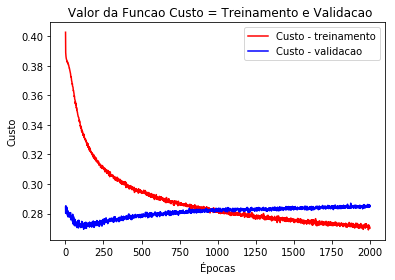

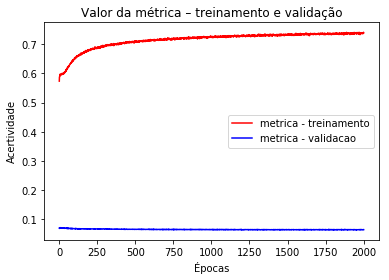

In [32]:
rna0.train(x_train_norm,y_train,x_val_norm,y_val,batch_size,epochs,loss,metric)
rna0.plot()

Confusion matrix, without normalization
[[25232  1753]
 [ 1632  1383]]


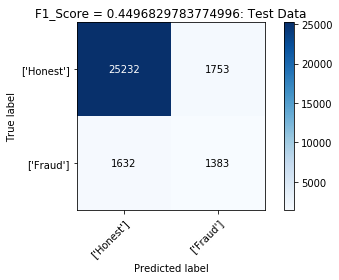

Confusion matrix, without normalization
[[25214  1772]
 [ 1595  1420]]


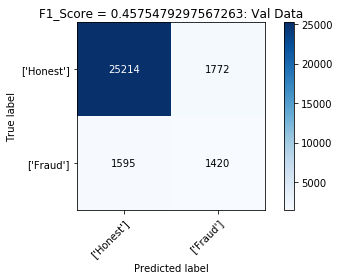

Confusion matrix, without normalization
[[121125   4806]
 [  9252  32952]]


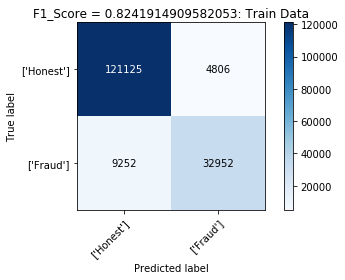

In [33]:
rna0.predict(x_data,y_data)

In [34]:
n_list1 = [100,1]
activation_list1 = ['tanh','sigmoid']
dropout_list1 = [0.3]

In [35]:
rna1 = new_rna()
rna1.build_model(data_shape,n_list1,activation_list1,dropout_list1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 20,201
Trainable params: 20,201
Non-trainable params: 0
_________________________________________________________________


Train on 168135 samples, validate on 30001 samples
Epoch 1/2000
168135/168135 [==============================] - 11s 63us/step - loss: 0.4028 - f1: 0.5719 - val_loss: 0.2805 - val_f1: 0.0687
Epoch 2/2000
168135/168135 [==============================] - 10s 58us/step - loss: 0.3886 - f1: 0.5866 - val_loss: 0.2813 - val_f1: 0.0688
Epoch 3/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.3870 - f1: 0.5888 - val_loss: 0.2800 - val_f1: 0.0687
Epoch 4/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.3853 - f1: 0.5916 - val_loss: 0.2807 - val_f1: 0.0687
Epoch 5/2000
168135/168135 [==============================] - 10s 58us/step - loss: 0.3851 - f1: 0.5934 - val_loss: 0.2812 - val_f1: 0.0695
Epoch 6/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.3844 - f1: 0.5909 - val_loss: 0.2813 - val_f1: 0.0692
Epoch 7/2000
168135/168135 [==============================] - 10s 58us/step - loss: 0.3837 - f1: 0.5947 - val

Epoch 59/2000
168135/168135 [==============================] - 10s 58us/step - loss: 0.3504 - f1: 0.6331 - val_loss: 0.2720 - val_f1: 0.0672
Epoch 60/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.3490 - f1: 0.6334 - val_loss: 0.2736 - val_f1: 0.0681
Epoch 61/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.3487 - f1: 0.6354 - val_loss: 0.2711 - val_f1: 0.0667
Epoch 62/2000
168135/168135 [==============================] - 10s 58us/step - loss: 0.3468 - f1: 0.6392 - val_loss: 0.2713 - val_f1: 0.0668
Epoch 63/2000
168135/168135 [==============================] - 13s 76us/step - loss: 0.3458 - f1: 0.6413 - val_loss: 0.2720 - val_f1: 0.0672
Epoch 64/2000
168135/168135 [==============================] - 16s 96us/step - loss: 0.3445 - f1: 0.6425 - val_loss: 0.2674 - val_f1: 0.0660
Epoch 65/2000
168135/168135 [==============================] - 13s 79us/step - loss: 0.3442 - f1: 0.6424 - val_loss: 0.2718 - val_f1: 0.0670
Epoch 66/2000

Epoch 117/2000
168135/168135 [==============================] - 11s 64us/step - loss: 0.3004 - f1: 0.7002 - val_loss: 0.2711 - val_f1: 0.0655
Epoch 118/2000
168135/168135 [==============================] - 11s 63us/step - loss: 0.3006 - f1: 0.6994 - val_loss: 0.2692 - val_f1: 0.0649
Epoch 119/2000
168135/168135 [==============================] - 11s 64us/step - loss: 0.3004 - f1: 0.7009 - val_loss: 0.2704 - val_f1: 0.0649
Epoch 120/2000
168135/168135 [==============================] - 11s 64us/step - loss: 0.3003 - f1: 0.6995 - val_loss: 0.2693 - val_f1: 0.0642
Epoch 121/2000
168135/168135 [==============================] - 11s 64us/step - loss: 0.2988 - f1: 0.7014 - val_loss: 0.2679 - val_f1: 0.0640
Epoch 122/2000
168135/168135 [==============================] - 11s 65us/step - loss: 0.2978 - f1: 0.7052 - val_loss: 0.2689 - val_f1: 0.0642
Epoch 123/2000
168135/168135 [==============================] - 11s 64us/step - loss: 0.2971 - f1: 0.7050 - val_loss: 0.2679 - val_f1: 0.0639
Epoch 

168135/168135 [==============================] - 10s 62us/step - loss: 0.2752 - f1: 0.7311 - val_loss: 0.2746 - val_f1: 0.0634
Epoch 175/2000
168135/168135 [==============================] - 10s 62us/step - loss: 0.2754 - f1: 0.7327 - val_loss: 0.2734 - val_f1: 0.0627
Epoch 176/2000
168135/168135 [==============================] - 11s 65us/step - loss: 0.2733 - f1: 0.7346 - val_loss: 0.2741 - val_f1: 0.0627
Epoch 177/2000
168135/168135 [==============================] - 11s 63us/step - loss: 0.2729 - f1: 0.7340 - val_loss: 0.2745 - val_f1: 0.0631
Epoch 178/2000
168135/168135 [==============================] - 11s 64us/step - loss: 0.2733 - f1: 0.7348 - val_loss: 0.2735 - val_f1: 0.0623
Epoch 179/2000
168135/168135 [==============================] - 11s 64us/step - loss: 0.2719 - f1: 0.7366 - val_loss: 0.2742 - val_f1: 0.0628
Epoch 180/2000
168135/168135 [==============================] - 11s 63us/step - loss: 0.2730 - f1: 0.7348 - val_loss: 0.2741 - val_f1: 0.0629
Epoch 181/2000
168135

Epoch 232/2000
168135/168135 [==============================] - 11s 65us/step - loss: 0.2603 - f1: 0.7493 - val_loss: 0.2772 - val_f1: 0.0616
Epoch 233/2000
168135/168135 [==============================] - 11s 65us/step - loss: 0.2602 - f1: 0.7501 - val_loss: 0.2786 - val_f1: 0.0622
Epoch 234/2000
168135/168135 [==============================] - 11s 63us/step - loss: 0.2580 - f1: 0.7535 - val_loss: 0.2788 - val_f1: 0.0624
Epoch 235/2000
168135/168135 [==============================] - 11s 64us/step - loss: 0.2602 - f1: 0.7493 - val_loss: 0.2779 - val_f1: 0.0620
Epoch 236/2000
168135/168135 [==============================] - 11s 64us/step - loss: 0.2592 - f1: 0.7498 - val_loss: 0.2787 - val_f1: 0.0622
Epoch 237/2000
168135/168135 [==============================] - 11s 63us/step - loss: 0.2594 - f1: 0.7511 - val_loss: 0.2784 - val_f1: 0.0619
Epoch 238/2000
168135/168135 [==============================] - 11s 65us/step - loss: 0.2585 - f1: 0.7497 - val_loss: 0.2789 - val_f1: 0.0617
Epoch 

168135/168135 [==============================] - 11s 65us/step - loss: 0.2495 - f1: 0.7630 - val_loss: 0.2810 - val_f1: 0.0617
Epoch 290/2000
168135/168135 [==============================] - 10s 62us/step - loss: 0.2496 - f1: 0.7618 - val_loss: 0.2822 - val_f1: 0.0620
Epoch 291/2000
168135/168135 [==============================] - 11s 64us/step - loss: 0.2506 - f1: 0.7594 - val_loss: 0.2809 - val_f1: 0.0611
Epoch 292/2000
168135/168135 [==============================] - 11s 64us/step - loss: 0.2492 - f1: 0.7623 - val_loss: 0.2821 - val_f1: 0.0617
Epoch 293/2000
168135/168135 [==============================] - 10s 62us/step - loss: 0.2480 - f1: 0.7642 - val_loss: 0.2815 - val_f1: 0.0614
Epoch 294/2000
168135/168135 [==============================] - 11s 64us/step - loss: 0.2503 - f1: 0.7619 - val_loss: 0.2808 - val_f1: 0.0613
Epoch 295/2000
168135/168135 [==============================] - 11s 66us/step - loss: 0.2489 - f1: 0.7598 - val_loss: 0.2820 - val_f1: 0.0615
Epoch 296/2000
168135

Epoch 347/2000
168135/168135 [==============================] - 10s 62us/step - loss: 0.2426 - f1: 0.7698 - val_loss: 0.2842 - val_f1: 0.0612
Epoch 348/2000
168135/168135 [==============================] - 11s 64us/step - loss: 0.2442 - f1: 0.7663 - val_loss: 0.2846 - val_f1: 0.0614
Epoch 349/2000
168135/168135 [==============================] - 11s 66us/step - loss: 0.2430 - f1: 0.7686 - val_loss: 0.2823 - val_f1: 0.0604
Epoch 350/2000
168135/168135 [==============================] - 11s 64us/step - loss: 0.2421 - f1: 0.7693 - val_loss: 0.2837 - val_f1: 0.0608
Epoch 351/2000
168135/168135 [==============================] - 11s 64us/step - loss: 0.2415 - f1: 0.7692 - val_loss: 0.2846 - val_f1: 0.0612
Epoch 352/2000
168135/168135 [==============================] - 11s 65us/step - loss: 0.2416 - f1: 0.7695 - val_loss: 0.2840 - val_f1: 0.0611
Epoch 353/2000
168135/168135 [==============================] - 11s 63us/step - loss: 0.2400 - f1: 0.7718 - val_loss: 0.2835 - val_f1: 0.0605
Epoch 

168135/168135 [==============================] - 11s 64us/step - loss: 0.2358 - f1: 0.7786 - val_loss: 0.2864 - val_f1: 0.0608
Epoch 405/2000
168135/168135 [==============================] - 11s 64us/step - loss: 0.2349 - f1: 0.7773 - val_loss: 0.2857 - val_f1: 0.0600
Epoch 406/2000
168135/168135 [==============================] - 11s 63us/step - loss: 0.2357 - f1: 0.7781 - val_loss: 0.2865 - val_f1: 0.0610
Epoch 407/2000
168135/168135 [==============================] - 11s 64us/step - loss: 0.2355 - f1: 0.7780 - val_loss: 0.2868 - val_f1: 0.0611
Epoch 408/2000
168135/168135 [==============================] - 11s 64us/step - loss: 0.2350 - f1: 0.7780 - val_loss: 0.2861 - val_f1: 0.0608
Epoch 409/2000
168135/168135 [==============================] - 10s 62us/step - loss: 0.2353 - f1: 0.7793 - val_loss: 0.2868 - val_f1: 0.0610
Epoch 410/2000
168135/168135 [==============================] - 11s 65us/step - loss: 0.2343 - f1: 0.7783 - val_loss: 0.2870 - val_f1: 0.0609
Epoch 411/2000
168135

Epoch 462/2000
168135/168135 [==============================] - 11s 66us/step - loss: 0.2335 - f1: 0.7803 - val_loss: 0.2870 - val_f1: 0.0600
Epoch 463/2000
168135/168135 [==============================] - 10s 62us/step - loss: 0.2306 - f1: 0.7828 - val_loss: 0.2889 - val_f1: 0.0604
Epoch 464/2000
168135/168135 [==============================] - 11s 65us/step - loss: 0.2317 - f1: 0.7809 - val_loss: 0.2888 - val_f1: 0.0607
Epoch 465/2000
168135/168135 [==============================] - 11s 64us/step - loss: 0.2310 - f1: 0.7846 - val_loss: 0.2890 - val_f1: 0.0612
Epoch 466/2000
168135/168135 [==============================] - 11s 63us/step - loss: 0.2315 - f1: 0.7802 - val_loss: 0.2879 - val_f1: 0.0602
Epoch 467/2000
168135/168135 [==============================] - 11s 65us/step - loss: 0.2298 - f1: 0.7847 - val_loss: 0.2889 - val_f1: 0.0607
Epoch 468/2000
168135/168135 [==============================] - 11s 65us/step - loss: 0.2314 - f1: 0.7824 - val_loss: 0.2893 - val_f1: 0.0605
Epoch 

168135/168135 [==============================] - 11s 64us/step - loss: 0.2266 - f1: 0.7888 - val_loss: 0.2903 - val_f1: 0.0600
Epoch 520/2000
168135/168135 [==============================] - 11s 63us/step - loss: 0.2271 - f1: 0.7871 - val_loss: 0.2902 - val_f1: 0.0598
Epoch 521/2000
168135/168135 [==============================] - 11s 64us/step - loss: 0.2270 - f1: 0.7861 - val_loss: 0.2909 - val_f1: 0.0600
Epoch 522/2000
168135/168135 [==============================] - 11s 64us/step - loss: 0.2271 - f1: 0.7844 - val_loss: 0.2904 - val_f1: 0.0603
Epoch 523/2000
168135/168135 [==============================] - 11s 64us/step - loss: 0.2262 - f1: 0.7890 - val_loss: 0.2918 - val_f1: 0.0609
Epoch 524/2000
168135/168135 [==============================] - 11s 65us/step - loss: 0.2278 - f1: 0.7841 - val_loss: 0.2916 - val_f1: 0.0607
Epoch 525/2000
168135/168135 [==============================] - 11s 64us/step - loss: 0.2267 - f1: 0.7876 - val_loss: 0.2913 - val_f1: 0.0606
Epoch 526/2000
168135

Epoch 577/2000
168135/168135 [==============================] - 11s 64us/step - loss: 0.2228 - f1: 0.7897 - val_loss: 0.2933 - val_f1: 0.0605
Epoch 578/2000
168135/168135 [==============================] - 11s 63us/step - loss: 0.2227 - f1: 0.7924 - val_loss: 0.2929 - val_f1: 0.0598
Epoch 579/2000
168135/168135 [==============================] - 11s 64us/step - loss: 0.2240 - f1: 0.7897 - val_loss: 0.2925 - val_f1: 0.0599
Epoch 580/2000
168135/168135 [==============================] - 11s 64us/step - loss: 0.2242 - f1: 0.7899 - val_loss: 0.2927 - val_f1: 0.0609
Epoch 581/2000
168135/168135 [==============================] - 11s 63us/step - loss: 0.2253 - f1: 0.7885 - val_loss: 0.2931 - val_f1: 0.0608
Epoch 582/2000
168135/168135 [==============================] - 11s 64us/step - loss: 0.2219 - f1: 0.7916 - val_loss: 0.2928 - val_f1: 0.0603
Epoch 583/2000
168135/168135 [==============================] - 11s 64us/step - loss: 0.2248 - f1: 0.7896 - val_loss: 0.2923 - val_f1: 0.0605
Epoch 

168135/168135 [==============================] - 11s 64us/step - loss: 0.2217 - f1: 0.7934 - val_loss: 0.2933 - val_f1: 0.0595
Epoch 635/2000
168135/168135 [==============================] - 11s 63us/step - loss: 0.2208 - f1: 0.7943 - val_loss: 0.2937 - val_f1: 0.0599
Epoch 636/2000
168135/168135 [==============================] - 11s 64us/step - loss: 0.2217 - f1: 0.7950 - val_loss: 0.2944 - val_f1: 0.0602
Epoch 637/2000
168135/168135 [==============================] - 11s 64us/step - loss: 0.2204 - f1: 0.7958 - val_loss: 0.2941 - val_f1: 0.0602
Epoch 638/2000
168135/168135 [==============================] - 11s 63us/step - loss: 0.2235 - f1: 0.7903 - val_loss: 0.2936 - val_f1: 0.0599
Epoch 639/2000
168135/168135 [==============================] - 11s 65us/step - loss: 0.2200 - f1: 0.7931 - val_loss: 0.2939 - val_f1: 0.0599
Epoch 640/2000
168135/168135 [==============================] - 10s 61us/step - loss: 0.2211 - f1: 0.7927 - val_loss: 0.2935 - val_f1: 0.0595
Epoch 641/2000
168135

Epoch 692/2000
168135/168135 [==============================] - 11s 64us/step - loss: 0.2188 - f1: 0.7945 - val_loss: 0.2952 - val_f1: 0.0605
Epoch 693/2000
168135/168135 [==============================] - 11s 64us/step - loss: 0.2181 - f1: 0.7972 - val_loss: 0.2954 - val_f1: 0.0602
Epoch 694/2000
168135/168135 [==============================] - 11s 62us/step - loss: 0.2167 - f1: 0.7971 - val_loss: 0.2949 - val_f1: 0.0597
Epoch 695/2000
168135/168135 [==============================] - 11s 64us/step - loss: 0.2182 - f1: 0.7969 - val_loss: 0.2953 - val_f1: 0.0597
Epoch 696/2000
168135/168135 [==============================] - 11s 64us/step - loss: 0.2169 - f1: 0.7974 - val_loss: 0.2960 - val_f1: 0.0603
Epoch 697/2000
168135/168135 [==============================] - 11s 64us/step - loss: 0.2179 - f1: 0.7976 - val_loss: 0.2950 - val_f1: 0.0595
Epoch 698/2000
168135/168135 [==============================] - 11s 65us/step - loss: 0.2167 - f1: 0.7977 - val_loss: 0.2960 - val_f1: 0.0599
Epoch 

168135/168135 [==============================] - 11s 64us/step - loss: 0.2165 - f1: 0.7981 - val_loss: 0.2965 - val_f1: 0.0600
Epoch 750/2000
168135/168135 [==============================] - 11s 63us/step - loss: 0.2160 - f1: 0.7990 - val_loss: 0.2967 - val_f1: 0.0599
Epoch 751/2000
168135/168135 [==============================] - 11s 64us/step - loss: 0.2159 - f1: 0.7976 - val_loss: 0.2965 - val_f1: 0.0603
Epoch 752/2000
168135/168135 [==============================] - 11s 64us/step - loss: 0.2143 - f1: 0.7998 - val_loss: 0.2970 - val_f1: 0.0596
Epoch 753/2000
168135/168135 [==============================] - 11s 64us/step - loss: 0.2156 - f1: 0.8011 - val_loss: 0.2975 - val_f1: 0.0598
Epoch 754/2000
168135/168135 [==============================] - 11s 65us/step - loss: 0.2147 - f1: 0.8023 - val_loss: 0.2968 - val_f1: 0.0598
Epoch 755/2000
168135/168135 [==============================] - 11s 65us/step - loss: 0.2161 - f1: 0.7986 - val_loss: 0.2963 - val_f1: 0.0595
Epoch 756/2000
168135

Epoch 807/2000
168135/168135 [==============================] - 10s 62us/step - loss: 0.2154 - f1: 0.8019 - val_loss: 0.2982 - val_f1: 0.0604
Epoch 808/2000
168135/168135 [==============================] - 11s 65us/step - loss: 0.2145 - f1: 0.8004 - val_loss: 0.2982 - val_f1: 0.0597
Epoch 809/2000
168135/168135 [==============================] - 11s 64us/step - loss: 0.2127 - f1: 0.8028 - val_loss: 0.2978 - val_f1: 0.0598
Epoch 810/2000
168135/168135 [==============================] - 11s 63us/step - loss: 0.2133 - f1: 0.8035 - val_loss: 0.2977 - val_f1: 0.0598
Epoch 811/2000
168135/168135 [==============================] - 11s 64us/step - loss: 0.2127 - f1: 0.8023 - val_loss: 0.2988 - val_f1: 0.0598
Epoch 812/2000
168135/168135 [==============================] - 11s 65us/step - loss: 0.2134 - f1: 0.8014 - val_loss: 0.2980 - val_f1: 0.0597
Epoch 813/2000
168135/168135 [==============================] - 11s 65us/step - loss: 0.2131 - f1: 0.8028 - val_loss: 0.2986 - val_f1: 0.0596
Epoch 

168135/168135 [==============================] - 11s 66us/step - loss: 0.2119 - f1: 0.8043 - val_loss: 0.2983 - val_f1: 0.0602
Epoch 865/2000
168135/168135 [==============================] - 11s 64us/step - loss: 0.2124 - f1: 0.8039 - val_loss: 0.2995 - val_f1: 0.0607
Epoch 866/2000
168135/168135 [==============================] - 11s 63us/step - loss: 0.2113 - f1: 0.8028 - val_loss: 0.2995 - val_f1: 0.0602
Epoch 867/2000
168135/168135 [==============================] - 11s 64us/step - loss: 0.2105 - f1: 0.8040 - val_loss: 0.3003 - val_f1: 0.0601
Epoch 868/2000
168135/168135 [==============================] - 11s 64us/step - loss: 0.2113 - f1: 0.8061 - val_loss: 0.2993 - val_f1: 0.0593
Epoch 869/2000
168135/168135 [==============================] - 11s 63us/step - loss: 0.2117 - f1: 0.8037 - val_loss: 0.2997 - val_f1: 0.0596
Epoch 870/2000
168135/168135 [==============================] - 11s 65us/step - loss: 0.2107 - f1: 0.8031 - val_loss: 0.2993 - val_f1: 0.0601
Epoch 871/2000
168135

Epoch 922/2000
168135/168135 [==============================] - 11s 64us/step - loss: 0.2091 - f1: 0.8046 - val_loss: 0.3010 - val_f1: 0.0595
Epoch 923/2000
168135/168135 [==============================] - 11s 64us/step - loss: 0.2091 - f1: 0.8065 - val_loss: 0.3010 - val_f1: 0.0595
Epoch 924/2000
168135/168135 [==============================] - 11s 63us/step - loss: 0.2108 - f1: 0.8039 - val_loss: 0.3003 - val_f1: 0.0600
Epoch 925/2000
168135/168135 [==============================] - 11s 64us/step - loss: 0.2099 - f1: 0.8064 - val_loss: 0.3005 - val_f1: 0.0596
Epoch 926/2000
168135/168135 [==============================] - 11s 65us/step - loss: 0.2109 - f1: 0.8033 - val_loss: 0.2996 - val_f1: 0.0594
Epoch 927/2000
168135/168135 [==============================] - 11s 65us/step - loss: 0.2096 - f1: 0.8052 - val_loss: 0.3003 - val_f1: 0.0596
Epoch 928/2000
168135/168135 [==============================] - 11s 65us/step - loss: 0.2113 - f1: 0.8044 - val_loss: 0.3001 - val_f1: 0.0598
Epoch 

168135/168135 [==============================] - 11s 64us/step - loss: 0.2098 - f1: 0.8042 - val_loss: 0.3010 - val_f1: 0.0594
Epoch 980/2000
168135/168135 [==============================] - 11s 64us/step - loss: 0.2068 - f1: 0.8106 - val_loss: 0.3017 - val_f1: 0.0592
Epoch 981/2000
168135/168135 [==============================] - 11s 63us/step - loss: 0.2076 - f1: 0.8095 - val_loss: 0.3020 - val_f1: 0.0596
Epoch 982/2000
168135/168135 [==============================] - 11s 65us/step - loss: 0.2081 - f1: 0.8076 - val_loss: 0.3017 - val_f1: 0.0598
Epoch 983/2000
168135/168135 [==============================] - 11s 64us/step - loss: 0.2097 - f1: 0.8064 - val_loss: 0.3009 - val_f1: 0.0596
Epoch 984/2000
168135/168135 [==============================] - 11s 63us/step - loss: 0.2090 - f1: 0.8050 - val_loss: 0.3018 - val_f1: 0.0598
Epoch 985/2000
168135/168135 [==============================] - 11s 64us/step - loss: 0.2087 - f1: 0.8077 - val_loss: 0.3018 - val_f1: 0.0593
Epoch 986/2000
168135

168135/168135 [==============================] - 9s 56us/step - loss: 0.2063 - f1: 0.8096 - val_loss: 0.3031 - val_f1: 0.0588
Epoch 1060/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2052 - f1: 0.8105 - val_loss: 0.3028 - val_f1: 0.0592
Epoch 1061/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.2059 - f1: 0.8086 - val_loss: 0.3043 - val_f1: 0.0598
Epoch 1062/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2055 - f1: 0.8121 - val_loss: 0.3035 - val_f1: 0.0595
Epoch 1063/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.2080 - f1: 0.8084 - val_loss: 0.3033 - val_f1: 0.0592
Epoch 1064/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2071 - f1: 0.8077 - val_loss: 0.3028 - val_f1: 0.0595
Epoch 1065/2000
168135/168135 [==============================] - 10s 58us/step - loss: 0.2063 - f1: 0.8096 - val_loss: 0.3023 - val_f1: 0.0590
Epoch 1066/2000
168

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 9s 56us/step - loss: 0.2038 - f1: 0.8127 - val_loss: 0.3043 - val_f1: 0.0590
Epoch 1098/2000
168135/168135 [==============================] - 10s 58us/step - loss: 0.2056 - f1: 0.8087 - val_loss: 0.3050 - val_f1: 0.0596
Epoch 1112/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2042 - f1: 0.8116 - val_loss: 0.3045 - val_f1: 0.0596
Epoch 1113/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2050 - f1: 0.8113 - val_loss: 0.3042 - val_f1: 0.0597
Epoch 1114/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.2049 - f1: 0.8104 - val_loss: 0.3041 - val_f1: 0.0591
Epoch 1115/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2041 - f1: 0.8114 - val_loss: 0.3055 - val_f1: 0.0598
Epoch 1116/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2047 - f1: 0.8110 - val_loss: 0.3042 - val_f1: 0.0596
Epoch 1117/2000
1681

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 9s 56us/step - loss: 0.2040 - f1: 0.8126 - val_loss: 0.3037 - val_f1: 0.0595
Epoch 1168/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2028 - f1: 0.8132 - val_loss: 0.3041 - val_f1: 0.0586
Epoch 1169/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2021 - f1: 0.8129 - val_loss: 0.3048 - val_f1: 0.0595
Epoch 1170/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2044 - f1: 0.8118 - val_loss: 0.3043 - val_f1: 0.0596
Epoch 1171/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2038 - f1: 0.8117 - val_loss: 0.3036 - val_f1: 0.0590
Epoch 1172/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.2040 - f1: 0.8122 - val_loss: 0.3040 - val_f1: 0.0596
Epoch 1173/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2034 - f1: 0.8127 - val_loss: 0.3042 - val_f1: 0.0593
Epoch 1174/2000
16813

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 9s 55us/step - loss: 0.2025 - f1: 0.8126 - val_loss: 0.3057 - val_f1: 0.0594
Epoch 1215/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.2038 - f1: 0.8136 - val_loss: 0.3050 - val_f1: 0.0594
Epoch 1233/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.2025 - f1: 0.8131 - val_loss: 0.3052 - val_f1: 0.0591
Epoch 1234/2000
168135/168135 [==============================] - 10s 58us/step - loss: 0.2020 - f1: 0.8144 - val_loss: 0.3060 - val_f1: 0.0596
Epoch 1235/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.2028 - f1: 0.8150 - val_loss: 0.3048 - val_f1: 0.0591
Epoch 1236/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.2024 - f1: 0.8151 - val_loss: 0.3050 - val_f1: 0.0589
Epoch 1237/2000
168135/168135 [==============================] - 10s 58us/step - loss: 0.2032 - f1: 0.8141 - val_loss: 0.3044 - val_f1: 0.0589
Epoch 1238/2000


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 9s 56us/step - loss: 0.2011 - f1: 0.8162 - val_loss: 0.3066 - val_f1: 0.0591
Epoch 1282/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.2019 - f1: 0.8143 - val_loss: 0.3066 - val_f1: 0.0592
Epoch 1283/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2031 - f1: 0.8138 - val_loss: 0.3051 - val_f1: 0.0587
Epoch 1284/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2009 - f1: 0.8156 - val_loss: 0.3059 - val_f1: 0.0593
Epoch 1285/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2027 - f1: 0.8127 - val_loss: 0.3055 - val_f1: 0.0592
Epoch 1286/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2015 - f1: 0.8137 - val_loss: 0.3057 - val_f1: 0.0586
Epoch 1287/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2013 - f1: 0.8140 - val_loss: 0.3061 - val_f1: 0.0596
Epoch 1288/2000
16813

Epoch 1339/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2015 - f1: 0.8151 - val_loss: 0.3065 - val_f1: 0.0590
Epoch 1340/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2015 - f1: 0.8146 - val_loss: 0.3065 - val_f1: 0.0591
Epoch 1341/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.1994 - f1: 0.8159 - val_loss: 0.3069 - val_f1: 0.0582
Epoch 1342/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.2005 - f1: 0.8143 - val_loss: 0.3071 - val_f1: 0.0589
Epoch 1343/2000
168135/168135 [==============================] - 9s 54us/step - loss: 0.2010 - f1: 0.8164 - val_loss: 0.3071 - val_f1: 0.0595
Epoch 1344/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.1995 - f1: 0.8163 - val_loss: 0.3071 - val_f1: 0.0595
Epoch 1345/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.1999 - f1: 0.8170 - val_loss: 0.3076 - val_f1: 0.0594
Epoch

168135/168135 [==============================] - 9s 55us/step - loss: 0.1977 - f1: 0.8192 - val_loss: 0.3086 - val_f1: 0.0587
Epoch 1510/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.1976 - f1: 0.8190 - val_loss: 0.3084 - val_f1: 0.0589
Epoch 1521/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.1975 - f1: 0.8185 - val_loss: 0.3088 - val_f1: 0.0587
Epoch 1522/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.1974 - f1: 0.8160 - val_loss: 0.3088 - val_f1: 0.0594
Epoch 1523/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.1986 - f1: 0.8195 - val_loss: 0.3086 - val_f1: 0.0584
Epoch 1524/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.1966 - f1: 0.8189 - val_loss: 0.3087 - val_f1: 0.0597
Epoch 1525/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.1968 - f1: 0.8203 - val_loss: 0.3082 - val_f1: 0.0591
Epoch 1526/2000
16813

168135/168135 [==============================] - 10s 59us/step - loss: 0.1953 - f1: 0.8210 - val_loss: 0.3096 - val_f1: 0.0588
Epoch 1650/2000
168135/168135 [==============================] - 10s 61us/step - loss: 0.1938 - f1: 0.8240 - val_loss: 0.3105 - val_f1: 0.0586
Epoch 1651/2000
168135/168135 [==============================] - 10s 62us/step - loss: 0.1942 - f1: 0.8232 - val_loss: 0.3103 - val_f1: 0.0589
Epoch 1652/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.1958 - f1: 0.8202 - val_loss: 0.3106 - val_f1: 0.0588
Epoch 1653/2000
168135/168135 [==============================] - 10s 61us/step - loss: 0.1953 - f1: 0.8212 - val_loss: 0.3097 - val_f1: 0.0588
Epoch 1654/2000
168135/168135 [==============================] - 10s 61us/step - loss: 0.1953 - f1: 0.8214 - val_loss: 0.3108 - val_f1: 0.0586
Epoch 1655/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.1945 - f1: 0.8215 - val_loss: 0.3099 - val_f1: 0.0585
Epoch 1656/2000

168135/168135 [==============================] - 10s 60us/step - loss: 0.1952 - f1: 0.8213 - val_loss: 0.3099 - val_f1: 0.0585
Epoch 1707/2000
168135/168135 [==============================] - 10s 61us/step - loss: 0.1932 - f1: 0.8241 - val_loss: 0.3106 - val_f1: 0.0590
Epoch 1708/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.1947 - f1: 0.8225 - val_loss: 0.3106 - val_f1: 0.0590
Epoch 1709/2000
168135/168135 [==============================] - 10s 61us/step - loss: 0.1950 - f1: 0.8221 - val_loss: 0.3100 - val_f1: 0.0583
Epoch 1710/2000
168135/168135 [==============================] - 10s 62us/step - loss: 0.1935 - f1: 0.8240 - val_loss: 0.3112 - val_f1: 0.0585
Epoch 1711/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.1961 - f1: 0.8211 - val_loss: 0.3088 - val_f1: 0.0591
Epoch 1712/2000
168135/168135 [==============================] - 10s 61us/step - loss: 0.1946 - f1: 0.8228 - val_loss: 0.3097 - val_f1: 0.0588
Epoch 1713/2000

168135/168135 [==============================] - 10s 62us/step - loss: 0.1950 - f1: 0.8190 - val_loss: 0.3101 - val_f1: 0.0591
Epoch 1764/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.1919 - f1: 0.8235 - val_loss: 0.3113 - val_f1: 0.0586
Epoch 1765/2000
168135/168135 [==============================] - 10s 61us/step - loss: 0.1951 - f1: 0.8205 - val_loss: 0.3105 - val_f1: 0.0584
Epoch 1766/2000
168135/168135 [==============================] - 10s 61us/step - loss: 0.1933 - f1: 0.8240 - val_loss: 0.3113 - val_f1: 0.0580
Epoch 1767/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.1944 - f1: 0.8203 - val_loss: 0.3104 - val_f1: 0.0588
Epoch 1768/2000
168135/168135 [==============================] - 10s 61us/step - loss: 0.1938 - f1: 0.8241 - val_loss: 0.3105 - val_f1: 0.0586
Epoch 1769/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.1947 - f1: 0.8217 - val_loss: 0.3108 - val_f1: 0.0594
Epoch 1770/2000

168135/168135 [==============================] - 10s 62us/step - loss: 0.1930 - f1: 0.8235 - val_loss: 0.3106 - val_f1: 0.0588
Epoch 1821/2000
168135/168135 [==============================] - 10s 61us/step - loss: 0.1928 - f1: 0.8240 - val_loss: 0.3113 - val_f1: 0.0590
Epoch 1822/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.1961 - f1: 0.8215 - val_loss: 0.3100 - val_f1: 0.0590
Epoch 1823/2000
168135/168135 [==============================] - 10s 62us/step - loss: 0.1942 - f1: 0.8228 - val_loss: 0.3102 - val_f1: 0.0590
Epoch 1824/2000
168135/168135 [==============================] - 10s 61us/step - loss: 0.1921 - f1: 0.8230 - val_loss: 0.3118 - val_f1: 0.0589
Epoch 1825/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.1931 - f1: 0.8230 - val_loss: 0.3118 - val_f1: 0.0591
Epoch 1826/2000
168135/168135 [==============================] - 10s 61us/step - loss: 0.1918 - f1: 0.8242 - val_loss: 0.3116 - val_f1: 0.0586
Epoch 1827/2000

168135/168135 [==============================] - 10s 61us/step - loss: 0.1936 - f1: 0.8234 - val_loss: 0.3107 - val_f1: 0.0587
Epoch 1878/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.1918 - f1: 0.8232 - val_loss: 0.3118 - val_f1: 0.0586
Epoch 1879/2000
168135/168135 [==============================] - 10s 61us/step - loss: 0.1928 - f1: 0.8265 - val_loss: 0.3106 - val_f1: 0.0582
Epoch 1880/2000
168135/168135 [==============================] - 10s 61us/step - loss: 0.1934 - f1: 0.8232 - val_loss: 0.3105 - val_f1: 0.0590
Epoch 1881/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.1936 - f1: 0.8222 - val_loss: 0.3110 - val_f1: 0.0586
Epoch 1882/2000
168135/168135 [==============================] - 10s 62us/step - loss: 0.1930 - f1: 0.8248 - val_loss: 0.3102 - val_f1: 0.0590
Epoch 1883/2000
168135/168135 [==============================] - 10s 61us/step - loss: 0.1936 - f1: 0.8231 - val_loss: 0.3097 - val_f1: 0.0588
Epoch 1884/2000

168135/168135 [==============================] - 10s 59us/step - loss: 0.1915 - f1: 0.8251 - val_loss: 0.3117 - val_f1: 0.0588
Epoch 1935/2000
168135/168135 [==============================] - 10s 62us/step - loss: 0.1931 - f1: 0.8248 - val_loss: 0.3110 - val_f1: 0.0583
Epoch 1936/2000
168135/168135 [==============================] - 10s 61us/step - loss: 0.1926 - f1: 0.8236 - val_loss: 0.3104 - val_f1: 0.0586
Epoch 1937/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.1922 - f1: 0.8240 - val_loss: 0.3114 - val_f1: 0.0590
Epoch 1938/2000
168135/168135 [==============================] - 10s 61us/step - loss: 0.1929 - f1: 0.8243 - val_loss: 0.3113 - val_f1: 0.0582
Epoch 1939/2000
168135/168135 [==============================] - 10s 61us/step - loss: 0.1921 - f1: 0.8243 - val_loss: 0.3122 - val_f1: 0.0589
Epoch 1940/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.1909 - f1: 0.8251 - val_loss: 0.3114 - val_f1: 0.0588
Epoch 1941/2000

168135/168135 [==============================] - 10s 57us/step - loss: 0.1919 - f1: 0.8241 - val_loss: 0.3120 - val_f1: 0.0586
Epoch 1992/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.1901 - f1: 0.8275 - val_loss: 0.3121 - val_f1: 0.0586
Epoch 1993/2000
168135/168135 [==============================] - 9s 54us/step - loss: 0.1909 - f1: 0.8254 - val_loss: 0.3125 - val_f1: 0.0586
Epoch 1994/2000
168135/168135 [==============================] - 11s 67us/step - loss: 0.1895 - f1: 0.8280 - val_loss: 0.3135 - val_f1: 0.0587
Epoch 1995/2000
168135/168135 [==============================] - 10s 61us/step - loss: 0.1932 - f1: 0.8215 - val_loss: 0.3123 - val_f1: 0.0588
Epoch 1996/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.1918 - f1: 0.8246 - val_loss: 0.3116 - val_f1: 0.0589
Epoch 1997/2000
168135/168135 [==============================] - 10s 61us/step - loss: 0.1910 - f1: 0.8257 - val_loss: 0.3125 - val_f1: 0.0591
Epoch 1998/2000
1

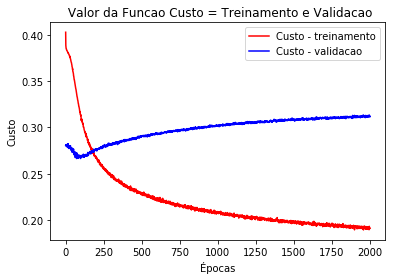

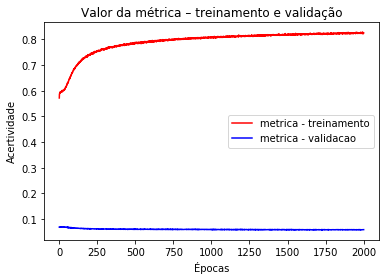

In [36]:
rna1.train(x_train_norm,y_train,x_val_norm,y_val,batch_size,epochs,loss,metric)
rna1.plot()

Confusion matrix, without normalization
[[25519  1466]
 [ 1813  1202]]


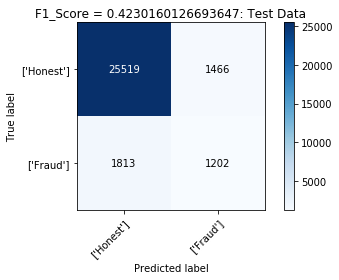

Confusion matrix, without normalization
[[25517  1469]
 [ 1757  1258]]


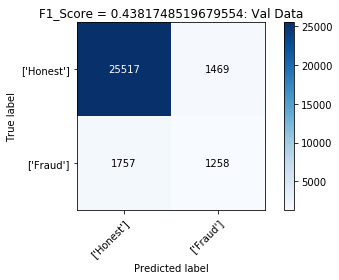

Confusion matrix, without normalization
[[123905   2026]
 [  2157  40047]]


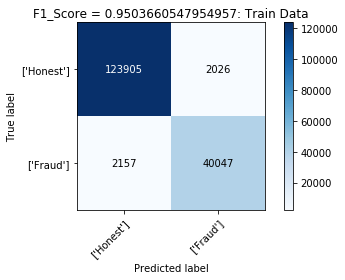

In [37]:
rna1.predict(x_data,y_data)

In [38]:
n_list2 = [50,50,1]
activation_list2 = ['tanh','tanh','sigmoid']
dropout_list2 = [0.3,0.3]

In [39]:
rna2 = new_rna()
rna2.build_model(data_shape,n_list2,activation_list2,dropout_list2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 12,651
Trainable params: 12,651
Non-trainable params: 0
_________________________________________________________________


Train on 168135 samples, validate on 30001 samples
Epoch 1/2000
168135/168135 [==============================] - 14s 85us/step - loss: 0.4100 - f1: 0.5619 - val_loss: 0.2791 - val_f1: 0.0692
Epoch 2/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.3928 - f1: 0.5861 - val_loss: 0.2817 - val_f1: 0.0709
Epoch 3/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.3905 - f1: 0.5905 - val_loss: 0.2793 - val_f1: 0.0708
Epoch 4/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.3891 - f1: 0.5945 - val_loss: 0.2811 - val_f1: 0.0707
Epoch 5/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.3876 - f1: 0.5967 - val_loss: 0.2813 - val_f1: 0.0709
Epoch 6/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.3874 - f1: 0.5986 - val_loss: 0.2820 - val_f1: 0.0711
Epoch 7/2000
168135/168135 [==============================] - 13s 78us/step - loss: 0.3865 - f1: 0.5959 - val

Epoch 59/2000
168135/168135 [==============================] - 13s 79us/step - loss: 0.3632 - f1: 0.6199 - val_loss: 0.2739 - val_f1: 0.0687
Epoch 60/2000
168135/168135 [==============================] - 13s 79us/step - loss: 0.3627 - f1: 0.6206 - val_loss: 0.2753 - val_f1: 0.0689
Epoch 61/2000
168135/168135 [==============================] - 13s 79us/step - loss: 0.3625 - f1: 0.6191 - val_loss: 0.2743 - val_f1: 0.0682
Epoch 62/2000
168135/168135 [==============================] - 13s 79us/step - loss: 0.3627 - f1: 0.6191 - val_loss: 0.2735 - val_f1: 0.0685
Epoch 63/2000
168135/168135 [==============================] - 13s 79us/step - loss: 0.3623 - f1: 0.6207 - val_loss: 0.2760 - val_f1: 0.0690
Epoch 64/2000
168135/168135 [==============================] - 13s 78us/step - loss: 0.3615 - f1: 0.6215 - val_loss: 0.2744 - val_f1: 0.0689
Epoch 65/2000
168135/168135 [==============================] - 13s 80us/step - loss: 0.3608 - f1: 0.6220 - val_loss: 0.2753 - val_f1: 0.0690
Epoch 66/2000

Epoch 117/2000
168135/168135 [==============================] - 13s 80us/step - loss: 0.3408 - f1: 0.6527 - val_loss: 0.2744 - val_f1: 0.0675
Epoch 118/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.3406 - f1: 0.6524 - val_loss: 0.2724 - val_f1: 0.0674
Epoch 119/2000
168135/168135 [==============================] - 13s 77us/step - loss: 0.3407 - f1: 0.6540 - val_loss: 0.2727 - val_f1: 0.0674
Epoch 120/2000
168135/168135 [==============================] - 13s 79us/step - loss: 0.3409 - f1: 0.6519 - val_loss: 0.2744 - val_f1: 0.0677
Epoch 121/2000
168135/168135 [==============================] - 13s 79us/step - loss: 0.3391 - f1: 0.6553 - val_loss: 0.2739 - val_f1: 0.0677
Epoch 122/2000
168135/168135 [==============================] - 13s 80us/step - loss: 0.3394 - f1: 0.6537 - val_loss: 0.2712 - val_f1: 0.0671
Epoch 123/2000
168135/168135 [==============================] - 14s 80us/step - loss: 0.3393 - f1: 0.6582 - val_loss: 0.2738 - val_f1: 0.0676
Epoch 

168135/168135 [==============================] - 14s 82us/step - loss: 0.3282 - f1: 0.6702 - val_loss: 0.2747 - val_f1: 0.0672
Epoch 175/2000
168135/168135 [==============================] - 13s 79us/step - loss: 0.3270 - f1: 0.6745 - val_loss: 0.2744 - val_f1: 0.0671
Epoch 176/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.3271 - f1: 0.6730 - val_loss: 0.2741 - val_f1: 0.0670
Epoch 177/2000
168135/168135 [==============================] - 13s 80us/step - loss: 0.3272 - f1: 0.6731 - val_loss: 0.2733 - val_f1: 0.0667
Epoch 178/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.3268 - f1: 0.6740 - val_loss: 0.2750 - val_f1: 0.0673
Epoch 179/2000
168135/168135 [==============================] - 13s 79us/step - loss: 0.3269 - f1: 0.6728 - val_loss: 0.2747 - val_f1: 0.0671
Epoch 180/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.3274 - f1: 0.6720 - val_loss: 0.2745 - val_f1: 0.0671
Epoch 181/2000
168135

Epoch 232/2000
168135/168135 [==============================] - 13s 78us/step - loss: 0.3186 - f1: 0.6859 - val_loss: 0.2749 - val_f1: 0.0666
Epoch 233/2000
168135/168135 [==============================] - 13s 80us/step - loss: 0.3188 - f1: 0.6842 - val_loss: 0.2751 - val_f1: 0.0667
Epoch 234/2000
168135/168135 [==============================] - 13s 80us/step - loss: 0.3192 - f1: 0.6849 - val_loss: 0.2755 - val_f1: 0.0666
Epoch 235/2000
168135/168135 [==============================] - 14s 80us/step - loss: 0.3196 - f1: 0.6862 - val_loss: 0.2766 - val_f1: 0.0667
Epoch 236/2000
168135/168135 [==============================] - 13s 79us/step - loss: 0.3184 - f1: 0.6881 - val_loss: 0.2767 - val_f1: 0.0668
Epoch 237/2000
168135/168135 [==============================] - 13s 79us/step - loss: 0.3188 - f1: 0.6854 - val_loss: 0.2742 - val_f1: 0.0661
Epoch 238/2000
168135/168135 [==============================] - 13s 78us/step - loss: 0.3195 - f1: 0.6837 - val_loss: 0.2754 - val_f1: 0.0669
Epoch 

168135/168135 [==============================] - 13s 77us/step - loss: 0.3153 - f1: 0.6913 - val_loss: 0.2776 - val_f1: 0.0666
Epoch 290/2000
168135/168135 [==============================] - 13s 79us/step - loss: 0.3148 - f1: 0.6932 - val_loss: 0.2788 - val_f1: 0.0669
Epoch 291/2000
168135/168135 [==============================] - 13s 79us/step - loss: 0.3130 - f1: 0.6940 - val_loss: 0.2801 - val_f1: 0.0672
Epoch 292/2000
168135/168135 [==============================] - 13s 80us/step - loss: 0.3128 - f1: 0.6915 - val_loss: 0.2780 - val_f1: 0.0665
Epoch 293/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.3121 - f1: 0.6952 - val_loss: 0.2785 - val_f1: 0.0666
Epoch 294/2000
168135/168135 [==============================] - 13s 79us/step - loss: 0.3131 - f1: 0.6944 - val_loss: 0.2808 - val_f1: 0.0673
Epoch 295/2000
168135/168135 [==============================] - 13s 79us/step - loss: 0.3127 - f1: 0.6958 - val_loss: 0.2793 - val_f1: 0.0668
Epoch 296/2000
168135

Epoch 347/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.3104 - f1: 0.6981 - val_loss: 0.2793 - val_f1: 0.0667
Epoch 348/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.3078 - f1: 0.7012 - val_loss: 0.2817 - val_f1: 0.0673
Epoch 349/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.3087 - f1: 0.7000 - val_loss: 0.2815 - val_f1: 0.0669
Epoch 350/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.3082 - f1: 0.7020 - val_loss: 0.2785 - val_f1: 0.0664
Epoch 351/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.3088 - f1: 0.7006 - val_loss: 0.2815 - val_f1: 0.0671
Epoch 352/2000
168135/168135 [==============================] - 13s 80us/step - loss: 0.3086 - f1: 0.6992 - val_loss: 0.2802 - val_f1: 0.0667
Epoch 353/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.3082 - f1: 0.7016 - val_loss: 0.2794 - val_f1: 0.0667
Epoch 

168135/168135 [==============================] - 13s 79us/step - loss: 0.3051 - f1: 0.7089 - val_loss: 0.2798 - val_f1: 0.0669
Epoch 405/2000
168135/168135 [==============================] - 14s 80us/step - loss: 0.3050 - f1: 0.7029 - val_loss: 0.2774 - val_f1: 0.0663
Epoch 406/2000
168135/168135 [==============================] - 14s 80us/step - loss: 0.3045 - f1: 0.7048 - val_loss: 0.2814 - val_f1: 0.0669
Epoch 407/2000
168135/168135 [==============================] - 13s 80us/step - loss: 0.3057 - f1: 0.7061 - val_loss: 0.2821 - val_f1: 0.0673
Epoch 408/2000
168135/168135 [==============================] - 14s 80us/step - loss: 0.3033 - f1: 0.7105 - val_loss: 0.2784 - val_f1: 0.0666
Epoch 409/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.3051 - f1: 0.7044 - val_loss: 0.2806 - val_f1: 0.0667
Epoch 410/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.3042 - f1: 0.7068 - val_loss: 0.2775 - val_f1: 0.0663
Epoch 411/2000
168135

Epoch 462/2000
168135/168135 [==============================] - 13s 80us/step - loss: 0.3000 - f1: 0.7120 - val_loss: 0.2811 - val_f1: 0.0668
Epoch 463/2000
168135/168135 [==============================] - 14s 80us/step - loss: 0.3021 - f1: 0.7111 - val_loss: 0.2754 - val_f1: 0.0656
Epoch 464/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.3022 - f1: 0.7112 - val_loss: 0.2809 - val_f1: 0.0665
Epoch 465/2000
168135/168135 [==============================] - 13s 80us/step - loss: 0.3006 - f1: 0.7121 - val_loss: 0.2833 - val_f1: 0.0672
Epoch 466/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.3031 - f1: 0.7088 - val_loss: 0.2830 - val_f1: 0.0670
Epoch 467/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.3022 - f1: 0.7088 - val_loss: 0.2836 - val_f1: 0.0670
Epoch 468/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.3025 - f1: 0.7097 - val_loss: 0.2803 - val_f1: 0.0664
Epoch 

168135/168135 [==============================] - 14s 81us/step - loss: 0.2997 - f1: 0.7137 - val_loss: 0.2819 - val_f1: 0.0665
Epoch 520/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.3002 - f1: 0.7130 - val_loss: 0.2843 - val_f1: 0.0671
Epoch 521/2000
168135/168135 [==============================] - 13s 80us/step - loss: 0.2990 - f1: 0.7152 - val_loss: 0.2826 - val_f1: 0.0667
Epoch 522/2000
168135/168135 [==============================] - 13s 79us/step - loss: 0.2998 - f1: 0.7128 - val_loss: 0.2818 - val_f1: 0.0666
Epoch 523/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.2996 - f1: 0.7156 - val_loss: 0.2814 - val_f1: 0.0666
Epoch 524/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2997 - f1: 0.7116 - val_loss: 0.2821 - val_f1: 0.0665
Epoch 525/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2976 - f1: 0.7181 - val_loss: 0.2820 - val_f1: 0.0665
Epoch 526/2000
168135

Epoch 577/2000
168135/168135 [==============================] - 13s 80us/step - loss: 0.2959 - f1: 0.7180 - val_loss: 0.2822 - val_f1: 0.0663
Epoch 578/2000
168135/168135 [==============================] - 13s 79us/step - loss: 0.2975 - f1: 0.7172 - val_loss: 0.2809 - val_f1: 0.0663
Epoch 579/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.2969 - f1: 0.7143 - val_loss: 0.2796 - val_f1: 0.0660
Epoch 580/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.2974 - f1: 0.7155 - val_loss: 0.2854 - val_f1: 0.0671
Epoch 581/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2970 - f1: 0.7173 - val_loss: 0.2827 - val_f1: 0.0661
Epoch 582/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2977 - f1: 0.7156 - val_loss: 0.2832 - val_f1: 0.0669
Epoch 583/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2972 - f1: 0.7163 - val_loss: 0.2835 - val_f1: 0.0668
Epoch 

168135/168135 [==============================] - 13s 79us/step - loss: 0.2957 - f1: 0.7182 - val_loss: 0.2819 - val_f1: 0.0662
Epoch 635/2000
168135/168135 [==============================] - 13s 80us/step - loss: 0.2950 - f1: 0.7192 - val_loss: 0.2825 - val_f1: 0.0663
Epoch 636/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2953 - f1: 0.7174 - val_loss: 0.2830 - val_f1: 0.0664
Epoch 637/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2967 - f1: 0.7172 - val_loss: 0.2812 - val_f1: 0.0659
Epoch 638/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2961 - f1: 0.7183 - val_loss: 0.2834 - val_f1: 0.0663
Epoch 639/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2956 - f1: 0.7140 - val_loss: 0.2830 - val_f1: 0.0661
Epoch 640/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2950 - f1: 0.7199 - val_loss: 0.2809 - val_f1: 0.0660
Epoch 641/2000
168135

Epoch 692/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2936 - f1: 0.7208 - val_loss: 0.2831 - val_f1: 0.0659
Epoch 693/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2935 - f1: 0.7211 - val_loss: 0.2846 - val_f1: 0.0666
Epoch 694/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2936 - f1: 0.7205 - val_loss: 0.2817 - val_f1: 0.0662
Epoch 695/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.2943 - f1: 0.7204 - val_loss: 0.2805 - val_f1: 0.0658
Epoch 696/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2929 - f1: 0.7226 - val_loss: 0.2865 - val_f1: 0.0667
Epoch 697/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2934 - f1: 0.7207 - val_loss: 0.2825 - val_f1: 0.0656
Epoch 698/2000
168135/168135 [==============================] - 13s 79us/step - loss: 0.2929 - f1: 0.7211 - val_loss: 0.2824 - val_f1: 0.0661
Epoch 

168135/168135 [==============================] - 14s 81us/step - loss: 0.2924 - f1: 0.7230 - val_loss: 0.2821 - val_f1: 0.0660
Epoch 750/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2919 - f1: 0.7225 - val_loss: 0.2845 - val_f1: 0.0663
Epoch 751/2000
168135/168135 [==============================] - 14s 80us/step - loss: 0.2920 - f1: 0.7229 - val_loss: 0.2858 - val_f1: 0.0670
Epoch 752/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2927 - f1: 0.7229 - val_loss: 0.2843 - val_f1: 0.0663
Epoch 753/2000
168135/168135 [==============================] - 13s 80us/step - loss: 0.2925 - f1: 0.7218 - val_loss: 0.2844 - val_f1: 0.0658
Epoch 754/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2910 - f1: 0.7264 - val_loss: 0.2848 - val_f1: 0.0661
Epoch 755/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2942 - f1: 0.7209 - val_loss: 0.2821 - val_f1: 0.0657
Epoch 756/2000
168135

Epoch 807/2000
168135/168135 [==============================] - 13s 80us/step - loss: 0.2916 - f1: 0.7238 - val_loss: 0.2843 - val_f1: 0.0664
Epoch 808/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2910 - f1: 0.7258 - val_loss: 0.2864 - val_f1: 0.0663
Epoch 809/2000
168135/168135 [==============================] - 13s 80us/step - loss: 0.2905 - f1: 0.7251 - val_loss: 0.2852 - val_f1: 0.0665
Epoch 810/2000
168135/168135 [==============================] - 14s 80us/step - loss: 0.2906 - f1: 0.7234 - val_loss: 0.2841 - val_f1: 0.0666
Epoch 811/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2912 - f1: 0.7223 - val_loss: 0.2839 - val_f1: 0.0662
Epoch 812/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2904 - f1: 0.7242 - val_loss: 0.2861 - val_f1: 0.0667
Epoch 813/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.2919 - f1: 0.7238 - val_loss: 0.2878 - val_f1: 0.0669
Epoch 

168135/168135 [==============================] - 14s 80us/step - loss: 0.2916 - f1: 0.7234 - val_loss: 0.2822 - val_f1: 0.0660
Epoch 865/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2895 - f1: 0.7261 - val_loss: 0.2819 - val_f1: 0.0656
Epoch 866/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.2895 - f1: 0.7273 - val_loss: 0.2859 - val_f1: 0.0660
Epoch 867/2000
168135/168135 [==============================] - 13s 80us/step - loss: 0.2904 - f1: 0.7247 - val_loss: 0.2831 - val_f1: 0.0658
Epoch 868/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2902 - f1: 0.7247 - val_loss: 0.2832 - val_f1: 0.0664
Epoch 869/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2895 - f1: 0.7252 - val_loss: 0.2858 - val_f1: 0.0667
Epoch 870/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.2892 - f1: 0.7255 - val_loss: 0.2847 - val_f1: 0.0664
Epoch 871/2000
168135

Epoch 922/2000
168135/168135 [==============================] - 13s 79us/step - loss: 0.2896 - f1: 0.7260 - val_loss: 0.2869 - val_f1: 0.0665
Epoch 923/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2889 - f1: 0.7274 - val_loss: 0.2864 - val_f1: 0.0668
Epoch 924/2000
168135/168135 [==============================] - 14s 80us/step - loss: 0.2889 - f1: 0.7278 - val_loss: 0.2840 - val_f1: 0.0664
Epoch 925/2000
168135/168135 [==============================] - 13s 80us/step - loss: 0.2889 - f1: 0.7264 - val_loss: 0.2867 - val_f1: 0.0663
Epoch 926/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2884 - f1: 0.7280 - val_loss: 0.2865 - val_f1: 0.0669
Epoch 927/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2887 - f1: 0.7262 - val_loss: 0.2823 - val_f1: 0.0661
Epoch 928/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.2873 - f1: 0.7284 - val_loss: 0.2867 - val_f1: 0.0670
Epoch 

168135/168135 [==============================] - 13s 79us/step - loss: 0.2875 - f1: 0.7300 - val_loss: 0.2864 - val_f1: 0.0668
Epoch 980/2000
168135/168135 [==============================] - 14s 80us/step - loss: 0.2874 - f1: 0.7288 - val_loss: 0.2831 - val_f1: 0.0660
Epoch 981/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.2873 - f1: 0.7283 - val_loss: 0.2845 - val_f1: 0.0665
Epoch 982/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2876 - f1: 0.7306 - val_loss: 0.2849 - val_f1: 0.0664
Epoch 983/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2866 - f1: 0.7308 - val_loss: 0.2862 - val_f1: 0.0666
Epoch 984/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.2870 - f1: 0.7287 - val_loss: 0.2835 - val_f1: 0.0660
Epoch 985/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.2867 - f1: 0.7306 - val_loss: 0.2863 - val_f1: 0.0665
Epoch 986/2000
168135

168135/168135 [==============================] - 14s 82us/step - loss: 0.2849 - f1: 0.7311 - val_loss: 0.2858 - val_f1: 0.0665
Epoch 1037/2000
168135/168135 [==============================] - 13s 80us/step - loss: 0.2861 - f1: 0.7335 - val_loss: 0.2919 - val_f1: 0.0671
Epoch 1038/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2863 - f1: 0.7294 - val_loss: 0.2836 - val_f1: 0.0657
Epoch 1039/2000
168135/168135 [==============================] - 14s 80us/step - loss: 0.2873 - f1: 0.7285 - val_loss: 0.2809 - val_f1: 0.0656
Epoch 1040/2000
168135/168135 [==============================] - 14s 80us/step - loss: 0.2866 - f1: 0.7298 - val_loss: 0.2844 - val_f1: 0.0664
Epoch 1041/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2871 - f1: 0.7294 - val_loss: 0.2816 - val_f1: 0.0660
Epoch 1042/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2872 - f1: 0.7275 - val_loss: 0.2886 - val_f1: 0.0671
Epoch 1043/2000

168135/168135 [==============================] - 14s 81us/step - loss: 0.2857 - f1: 0.7307 - val_loss: 0.2866 - val_f1: 0.0666
Epoch 1094/2000
168135/168135 [==============================] - 13s 79us/step - loss: 0.2862 - f1: 0.7317 - val_loss: 0.2854 - val_f1: 0.0665
Epoch 1095/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2858 - f1: 0.7328 - val_loss: 0.2891 - val_f1: 0.0668
Epoch 1096/2000
168135/168135 [==============================] - 13s 80us/step - loss: 0.2848 - f1: 0.7325 - val_loss: 0.2859 - val_f1: 0.0667
Epoch 1097/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2853 - f1: 0.7284 - val_loss: 0.2875 - val_f1: 0.0669
Epoch 1098/2000
168135/168135 [==============================] - 14s 80us/step - loss: 0.2856 - f1: 0.7325 - val_loss: 0.2831 - val_f1: 0.0662
Epoch 1099/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.2857 - f1: 0.7328 - val_loss: 0.2887 - val_f1: 0.0669
Epoch 1100/2000

168135/168135 [==============================] - 14s 81us/step - loss: 0.2854 - f1: 0.7302 - val_loss: 0.2853 - val_f1: 0.0664
Epoch 1151/2000
168135/168135 [==============================] - 14s 80us/step - loss: 0.2843 - f1: 0.7315 - val_loss: 0.2863 - val_f1: 0.0666
Epoch 1152/2000
168135/168135 [==============================] - 13s 80us/step - loss: 0.2846 - f1: 0.7315 - val_loss: 0.2857 - val_f1: 0.0662
Epoch 1153/2000
168135/168135 [==============================] - 14s 80us/step - loss: 0.2861 - f1: 0.7311 - val_loss: 0.2847 - val_f1: 0.0661
Epoch 1154/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2864 - f1: 0.7284 - val_loss: 0.2849 - val_f1: 0.0666
Epoch 1155/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2840 - f1: 0.7332 - val_loss: 0.2853 - val_f1: 0.0661
Epoch 1156/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2859 - f1: 0.7313 - val_loss: 0.2860 - val_f1: 0.0664
Epoch 1157/2000

168135/168135 [==============================] - 14s 81us/step - loss: 0.2839 - f1: 0.7309 - val_loss: 0.2886 - val_f1: 0.0664
Epoch 1208/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2846 - f1: 0.7338 - val_loss: 0.2850 - val_f1: 0.0663
Epoch 1209/2000
168135/168135 [==============================] - 13s 80us/step - loss: 0.2844 - f1: 0.7335 - val_loss: 0.2871 - val_f1: 0.0666
Epoch 1210/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.2838 - f1: 0.7336 - val_loss: 0.2898 - val_f1: 0.0672
Epoch 1211/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.2846 - f1: 0.7316 - val_loss: 0.2882 - val_f1: 0.0667
Epoch 1212/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2848 - f1: 0.7338 - val_loss: 0.2851 - val_f1: 0.0664
Epoch 1213/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.2845 - f1: 0.7327 - val_loss: 0.2895 - val_f1: 0.0668
Epoch 1214/2000

168135/168135 [==============================] - 14s 80us/step - loss: 0.2833 - f1: 0.7365 - val_loss: 0.2846 - val_f1: 0.0660
Epoch 1265/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2840 - f1: 0.7339 - val_loss: 0.2876 - val_f1: 0.0668
Epoch 1266/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2841 - f1: 0.7326 - val_loss: 0.2854 - val_f1: 0.0664
Epoch 1267/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2847 - f1: 0.7331 - val_loss: 0.2855 - val_f1: 0.0660
Epoch 1268/2000
168135/168135 [==============================] - 13s 79us/step - loss: 0.2834 - f1: 0.7340 - val_loss: 0.2896 - val_f1: 0.0669
Epoch 1269/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2817 - f1: 0.7367 - val_loss: 0.2845 - val_f1: 0.0661
Epoch 1270/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2836 - f1: 0.7327 - val_loss: 0.2842 - val_f1: 0.0661
Epoch 1271/2000

168135/168135 [==============================] - 14s 81us/step - loss: 0.2839 - f1: 0.7307 - val_loss: 0.2871 - val_f1: 0.0664
Epoch 1322/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2832 - f1: 0.7347 - val_loss: 0.2901 - val_f1: 0.0670
Epoch 1323/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.2831 - f1: 0.7335 - val_loss: 0.2881 - val_f1: 0.0669
Epoch 1324/2000
168135/168135 [==============================] - 13s 79us/step - loss: 0.2824 - f1: 0.7363 - val_loss: 0.2851 - val_f1: 0.0665
Epoch 1325/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2835 - f1: 0.7330 - val_loss: 0.2840 - val_f1: 0.0662
Epoch 1326/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2827 - f1: 0.7354 - val_loss: 0.2869 - val_f1: 0.0665
Epoch 1327/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.2818 - f1: 0.7365 - val_loss: 0.2862 - val_f1: 0.0665
Epoch 1328/2000

168135/168135 [==============================] - 14s 81us/step - loss: 0.2811 - f1: 0.7385 - val_loss: 0.2933 - val_f1: 0.0671
Epoch 1379/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2825 - f1: 0.7339 - val_loss: 0.2854 - val_f1: 0.0663
Epoch 1380/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2817 - f1: 0.7339 - val_loss: 0.2861 - val_f1: 0.0662
Epoch 1381/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.2829 - f1: 0.7337 - val_loss: 0.2851 - val_f1: 0.0662
Epoch 1382/2000
168135/168135 [==============================] - 13s 80us/step - loss: 0.2829 - f1: 0.7323 - val_loss: 0.2869 - val_f1: 0.0665
Epoch 1383/2000
168135/168135 [==============================] - 13s 80us/step - loss: 0.2821 - f1: 0.7355 - val_loss: 0.2847 - val_f1: 0.0664
Epoch 1384/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2822 - f1: 0.7369 - val_loss: 0.2866 - val_f1: 0.0664
Epoch 1385/2000

168135/168135 [==============================] - 13s 76us/step - loss: 0.2808 - f1: 0.7350 - val_loss: 0.2880 - val_f1: 0.0669
Epoch 1436/2000
168135/168135 [==============================] - 13s 76us/step - loss: 0.2824 - f1: 0.7351 - val_loss: 0.2880 - val_f1: 0.0666
Epoch 1437/2000
168135/168135 [==============================] - 13s 77us/step - loss: 0.2823 - f1: 0.7352 - val_loss: 0.2849 - val_f1: 0.0660
Epoch 1438/2000
168135/168135 [==============================] - 13s 77us/step - loss: 0.2825 - f1: 0.7358 - val_loss: 0.2833 - val_f1: 0.0660
Epoch 1439/2000
168135/168135 [==============================] - 13s 76us/step - loss: 0.2822 - f1: 0.7353 - val_loss: 0.2898 - val_f1: 0.0670
Epoch 1440/2000
168135/168135 [==============================] - 13s 76us/step - loss: 0.2802 - f1: 0.7384 - val_loss: 0.2862 - val_f1: 0.0658
Epoch 1441/2000
168135/168135 [==============================] - 13s 77us/step - loss: 0.2815 - f1: 0.7361 - val_loss: 0.2850 - val_f1: 0.0660
Epoch 1442/2000

168135/168135 [==============================] - 13s 76us/step - loss: 0.2811 - f1: 0.7381 - val_loss: 0.2867 - val_f1: 0.0662
Epoch 1493/2000
168135/168135 [==============================] - 13s 77us/step - loss: 0.2809 - f1: 0.7369 - val_loss: 0.2880 - val_f1: 0.0664
Epoch 1494/2000
168135/168135 [==============================] - 13s 75us/step - loss: 0.2816 - f1: 0.7366 - val_loss: 0.2914 - val_f1: 0.0669
Epoch 1495/2000
168135/168135 [==============================] - 13s 76us/step - loss: 0.2808 - f1: 0.7360 - val_loss: 0.2875 - val_f1: 0.0661
Epoch 1496/2000
168135/168135 [==============================] - 13s 77us/step - loss: 0.2808 - f1: 0.7370 - val_loss: 0.2872 - val_f1: 0.0663
Epoch 1497/2000
168135/168135 [==============================] - 13s 77us/step - loss: 0.2812 - f1: 0.7380 - val_loss: 0.2851 - val_f1: 0.0662
Epoch 1498/2000
168135/168135 [==============================] - 13s 76us/step - loss: 0.2807 - f1: 0.7359 - val_loss: 0.2847 - val_f1: 0.0660
Epoch 1499/2000

168135/168135 [==============================] - 13s 80us/step - loss: 0.2812 - f1: 0.7386 - val_loss: 0.2882 - val_f1: 0.0665
Epoch 1550/2000
168135/168135 [==============================] - 13s 74us/step - loss: 0.2805 - f1: 0.7408 - val_loss: 0.2868 - val_f1: 0.0663
Epoch 1551/2000
168135/168135 [==============================] - 13s 76us/step - loss: 0.2817 - f1: 0.7370 - val_loss: 0.2879 - val_f1: 0.0664
Epoch 1552/2000
168135/168135 [==============================] - 13s 78us/step - loss: 0.2809 - f1: 0.7363 - val_loss: 0.2878 - val_f1: 0.0663
Epoch 1553/2000
168135/168135 [==============================] - 13s 76us/step - loss: 0.2795 - f1: 0.7369 - val_loss: 0.2912 - val_f1: 0.0669
Epoch 1554/2000
168135/168135 [==============================] - 12s 73us/step - loss: 0.2809 - f1: 0.7373 - val_loss: 0.2865 - val_f1: 0.0662
Epoch 1555/2000
168135/168135 [==============================] - 13s 77us/step - loss: 0.2799 - f1: 0.7391 - val_loss: 0.2862 - val_f1: 0.0661
Epoch 1556/2000

168135/168135 [==============================] - 13s 76us/step - loss: 0.2797 - f1: 0.7389 - val_loss: 0.2898 - val_f1: 0.0667
Epoch 1607/2000
168135/168135 [==============================] - 13s 75us/step - loss: 0.2804 - f1: 0.7391 - val_loss: 0.2874 - val_f1: 0.0661
Epoch 1608/2000
168135/168135 [==============================] - 13s 76us/step - loss: 0.2800 - f1: 0.7401 - val_loss: 0.2915 - val_f1: 0.0668
Epoch 1609/2000
168135/168135 [==============================] - 13s 77us/step - loss: 0.2801 - f1: 0.7395 - val_loss: 0.2916 - val_f1: 0.0671
Epoch 1610/2000
168135/168135 [==============================] - 13s 76us/step - loss: 0.2791 - f1: 0.7400 - val_loss: 0.2891 - val_f1: 0.0669
Epoch 1611/2000
168135/168135 [==============================] - 13s 76us/step - loss: 0.2803 - f1: 0.7405 - val_loss: 0.2921 - val_f1: 0.0672
Epoch 1612/2000
168135/168135 [==============================] - 13s 75us/step - loss: 0.2802 - f1: 0.7389 - val_loss: 0.2912 - val_f1: 0.0670
Epoch 1613/2000

168135/168135 [==============================] - 13s 77us/step - loss: 0.2788 - f1: 0.7403 - val_loss: 0.2863 - val_f1: 0.0663
Epoch 1664/2000
168135/168135 [==============================] - 13s 76us/step - loss: 0.2795 - f1: 0.7392 - val_loss: 0.2845 - val_f1: 0.0659
Epoch 1665/2000
168135/168135 [==============================] - 13s 78us/step - loss: 0.2787 - f1: 0.7392 - val_loss: 0.2891 - val_f1: 0.0668
Epoch 1666/2000
168135/168135 [==============================] - 13s 75us/step - loss: 0.2791 - f1: 0.7413 - val_loss: 0.2905 - val_f1: 0.0664
Epoch 1667/2000
168135/168135 [==============================] - 13s 76us/step - loss: 0.2792 - f1: 0.7385 - val_loss: 0.2896 - val_f1: 0.0668
Epoch 1668/2000
168135/168135 [==============================] - 13s 77us/step - loss: 0.2800 - f1: 0.7385 - val_loss: 0.2870 - val_f1: 0.0662
Epoch 1669/2000
168135/168135 [==============================] - 13s 77us/step - loss: 0.2796 - f1: 0.7376 - val_loss: 0.2883 - val_f1: 0.0664
Epoch 1670/2000

168135/168135 [==============================] - 13s 76us/step - loss: 0.2794 - f1: 0.7389 - val_loss: 0.2879 - val_f1: 0.0660
Epoch 1721/2000
168135/168135 [==============================] - 13s 76us/step - loss: 0.2795 - f1: 0.7383 - val_loss: 0.2906 - val_f1: 0.0667
Epoch 1722/2000
168135/168135 [==============================] - 13s 76us/step - loss: 0.2794 - f1: 0.7398 - val_loss: 0.2906 - val_f1: 0.0665
Epoch 1723/2000
168135/168135 [==============================] - 13s 76us/step - loss: 0.2796 - f1: 0.7385 - val_loss: 0.2862 - val_f1: 0.0661
Epoch 1724/2000
168135/168135 [==============================] - 13s 76us/step - loss: 0.2779 - f1: 0.7416 - val_loss: 0.2909 - val_f1: 0.0668
Epoch 1725/2000
168135/168135 [==============================] - 13s 77us/step - loss: 0.2789 - f1: 0.7393 - val_loss: 0.2846 - val_f1: 0.0656
Epoch 1726/2000
168135/168135 [==============================] - 13s 77us/step - loss: 0.2778 - f1: 0.7414 - val_loss: 0.2885 - val_f1: 0.0666
Epoch 1727/2000

168135/168135 [==============================] - 13s 77us/step - loss: 0.2779 - f1: 0.7393 - val_loss: 0.2904 - val_f1: 0.0671
Epoch 1778/2000
168135/168135 [==============================] - 13s 77us/step - loss: 0.2786 - f1: 0.7401 - val_loss: 0.2896 - val_f1: 0.0665
Epoch 1779/2000
168135/168135 [==============================] - 13s 75us/step - loss: 0.2775 - f1: 0.7418 - val_loss: 0.2877 - val_f1: 0.0665
Epoch 1780/2000
168135/168135 [==============================] - 13s 78us/step - loss: 0.2791 - f1: 0.7385 - val_loss: 0.2856 - val_f1: 0.0664
Epoch 1781/2000
168135/168135 [==============================] - 13s 78us/step - loss: 0.2775 - f1: 0.7411 - val_loss: 0.2931 - val_f1: 0.0673
Epoch 1782/2000
168135/168135 [==============================] - 13s 77us/step - loss: 0.2786 - f1: 0.7419 - val_loss: 0.2891 - val_f1: 0.0664
Epoch 1783/2000
168135/168135 [==============================] - 13s 76us/step - loss: 0.2782 - f1: 0.7398 - val_loss: 0.2922 - val_f1: 0.0670
Epoch 1784/2000

168135/168135 [==============================] - 13s 76us/step - loss: 0.2778 - f1: 0.7417 - val_loss: 0.2898 - val_f1: 0.0666
Epoch 1835/2000
168135/168135 [==============================] - 13s 76us/step - loss: 0.2766 - f1: 0.7424 - val_loss: 0.2906 - val_f1: 0.0665
Epoch 1836/2000
168135/168135 [==============================] - 13s 77us/step - loss: 0.2784 - f1: 0.7386 - val_loss: 0.2884 - val_f1: 0.0661
Epoch 1837/2000
168135/168135 [==============================] - 12s 73us/step - loss: 0.2773 - f1: 0.7413 - val_loss: 0.2892 - val_f1: 0.0663
Epoch 1838/2000
168135/168135 [==============================] - 13s 76us/step - loss: 0.2782 - f1: 0.7408 - val_loss: 0.2894 - val_f1: 0.0663
Epoch 1839/2000
168135/168135 [==============================] - 13s 76us/step - loss: 0.2773 - f1: 0.7413 - val_loss: 0.2896 - val_f1: 0.0663
Epoch 1840/2000
168135/168135 [==============================] - 13s 77us/step - loss: 0.2781 - f1: 0.7404 - val_loss: 0.2907 - val_f1: 0.0666
Epoch 1841/2000

168135/168135 [==============================] - 13s 77us/step - loss: 0.2788 - f1: 0.7381 - val_loss: 0.2893 - val_f1: 0.0662
Epoch 1892/2000
168135/168135 [==============================] - 13s 78us/step - loss: 0.2785 - f1: 0.7409 - val_loss: 0.2874 - val_f1: 0.0663
Epoch 1893/2000
168135/168135 [==============================] - 13s 76us/step - loss: 0.2764 - f1: 0.7443 - val_loss: 0.2892 - val_f1: 0.0667
Epoch 1894/2000
168135/168135 [==============================] - 12s 74us/step - loss: 0.2768 - f1: 0.7419 - val_loss: 0.2917 - val_f1: 0.0668
Epoch 1895/2000
168135/168135 [==============================] - 13s 76us/step - loss: 0.2771 - f1: 0.7430 - val_loss: 0.2875 - val_f1: 0.0660
Epoch 1896/2000
168135/168135 [==============================] - 13s 77us/step - loss: 0.2774 - f1: 0.7424 - val_loss: 0.2904 - val_f1: 0.0666
Epoch 1897/2000
168135/168135 [==============================] - 13s 77us/step - loss: 0.2768 - f1: 0.7411 - val_loss: 0.2866 - val_f1: 0.0659
Epoch 1898/2000

168135/168135 [==============================] - 12s 74us/step - loss: 0.2782 - f1: 0.7415 - val_loss: 0.2941 - val_f1: 0.0670
Epoch 1949/2000
168135/168135 [==============================] - 13s 76us/step - loss: 0.2769 - f1: 0.7427 - val_loss: 0.2859 - val_f1: 0.0663
Epoch 1950/2000
168135/168135 [==============================] - 13s 77us/step - loss: 0.2786 - f1: 0.7395 - val_loss: 0.2875 - val_f1: 0.0661
Epoch 1951/2000
168135/168135 [==============================] - 13s 76us/step - loss: 0.2770 - f1: 0.7423 - val_loss: 0.2915 - val_f1: 0.0665
Epoch 1952/2000
168135/168135 [==============================] - 13s 77us/step - loss: 0.2782 - f1: 0.7425 - val_loss: 0.2861 - val_f1: 0.0660
Epoch 1953/2000
168135/168135 [==============================] - 13s 78us/step - loss: 0.2777 - f1: 0.7427 - val_loss: 0.2918 - val_f1: 0.0669
Epoch 1954/2000
168135/168135 [==============================] - 13s 77us/step - loss: 0.2774 - f1: 0.7420 - val_loss: 0.2908 - val_f1: 0.0661
Epoch 1955/2000

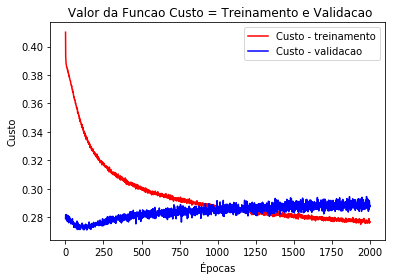

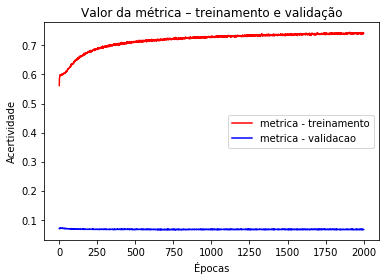

In [40]:
rna2.train(x_train_norm,y_train,x_val_norm,y_val,batch_size,epochs,loss,metric)
rna2.plot()

Confusion matrix, without normalization
[[24968  2017]
 [ 1530  1485]]


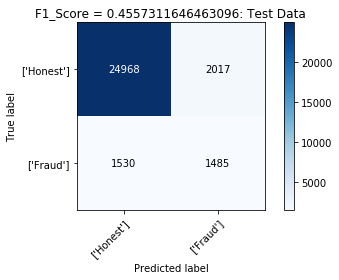

Confusion matrix, without normalization
[[25019  1967]
 [ 1529  1486]]


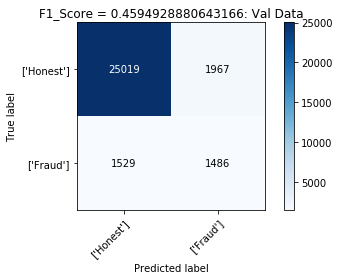

Confusion matrix, without normalization
[[120080   5851]
 [  7908  34296]]


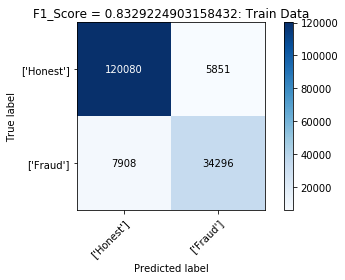

In [41]:
rna2.predict(x_data,y_data)

In [42]:
n_list3 = [100,100,1]
activation_list3 = ['tanh', 'tanh', 'sigmoid']
dropout_list3 = [0.3,0.3,0.3]

In [43]:
rna3 = new_rna()
rna3.build_model(data_shape,n_list3,activation_list3,dropout_list3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 30,301
Trainable params: 30,301
Non-trainable params: 0
_________________________________________________________________


Train on 168135 samples, validate on 30001 samples
Epoch 1/2000
168135/168135 [==============================] - 15s 87us/step - loss: 0.4089 - f1: 0.5621 - val_loss: 0.2819 - val_f1: 0.0697
Epoch 2/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.3914 - f1: 0.5844 - val_loss: 0.2802 - val_f1: 0.0703
Epoch 3/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.3884 - f1: 0.5926 - val_loss: 0.2801 - val_f1: 0.0702
Epoch 4/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.3868 - f1: 0.5930 - val_loss: 0.2796 - val_f1: 0.0699
Epoch 5/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.3859 - f1: 0.5946 - val_loss: 0.2805 - val_f1: 0.0705
Epoch 6/2000
168135/168135 [==============================] - 14s 84us/step - loss: 0.3853 - f1: 0.5966 - val_loss: 0.2827 - val_f1: 0.0710
Epoch 7/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.3845 - f1: 0.5982 - val

Epoch 59/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.3524 - f1: 0.6282 - val_loss: 0.2685 - val_f1: 0.0679
Epoch 60/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.3515 - f1: 0.6333 - val_loss: 0.2677 - val_f1: 0.0676
Epoch 61/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.3513 - f1: 0.6350 - val_loss: 0.2660 - val_f1: 0.0672
Epoch 62/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.3500 - f1: 0.6337 - val_loss: 0.2656 - val_f1: 0.0669
Epoch 63/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.3486 - f1: 0.6370 - val_loss: 0.2687 - val_f1: 0.0678
Epoch 64/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.3484 - f1: 0.6372 - val_loss: 0.2657 - val_f1: 0.0672
Epoch 65/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.3480 - f1: 0.6375 - val_loss: 0.2660 - val_f1: 0.0670
Epoch 66/2000

Epoch 117/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.3076 - f1: 0.6919 - val_loss: 0.2616 - val_f1: 0.0636
Epoch 118/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.3075 - f1: 0.6944 - val_loss: 0.2617 - val_f1: 0.0635
Epoch 119/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.3065 - f1: 0.6972 - val_loss: 0.2637 - val_f1: 0.0641
Epoch 120/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.3065 - f1: 0.6934 - val_loss: 0.2623 - val_f1: 0.0639
Epoch 121/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.3048 - f1: 0.6947 - val_loss: 0.2630 - val_f1: 0.0641
Epoch 122/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.3042 - f1: 0.6965 - val_loss: 0.2638 - val_f1: 0.0643
Epoch 123/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.3034 - f1: 0.6978 - val_loss: 0.2633 - val_f1: 0.0641
Epoch 

168135/168135 [==============================] - 14s 83us/step - loss: 0.2802 - f1: 0.7264 - val_loss: 0.2651 - val_f1: 0.0617
Epoch 175/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2815 - f1: 0.7296 - val_loss: 0.2656 - val_f1: 0.0621
Epoch 176/2000
168135/168135 [==============================] - 14s 84us/step - loss: 0.2794 - f1: 0.7296 - val_loss: 0.2648 - val_f1: 0.0619
Epoch 177/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.2792 - f1: 0.7281 - val_loss: 0.2658 - val_f1: 0.0625
Epoch 178/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.2780 - f1: 0.7323 - val_loss: 0.2649 - val_f1: 0.0616
Epoch 179/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.2791 - f1: 0.7291 - val_loss: 0.2684 - val_f1: 0.0626
Epoch 180/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.2800 - f1: 0.7296 - val_loss: 0.2670 - val_f1: 0.0625
Epoch 181/2000
168135

Epoch 232/2000
168135/168135 [==============================] - 13s 80us/step - loss: 0.2633 - f1: 0.7477 - val_loss: 0.2704 - val_f1: 0.0618
Epoch 233/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.2634 - f1: 0.7467 - val_loss: 0.2696 - val_f1: 0.0611
Epoch 234/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.2630 - f1: 0.7478 - val_loss: 0.2707 - val_f1: 0.0616
Epoch 235/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.2602 - f1: 0.7512 - val_loss: 0.2697 - val_f1: 0.0603
Epoch 236/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.2617 - f1: 0.7487 - val_loss: 0.2694 - val_f1: 0.0614
Epoch 237/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.2621 - f1: 0.7487 - val_loss: 0.2699 - val_f1: 0.0607
Epoch 238/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.2621 - f1: 0.7494 - val_loss: 0.2704 - val_f1: 0.0610
Epoch 

168135/168135 [==============================] - 14s 83us/step - loss: 0.2524 - f1: 0.7616 - val_loss: 0.2735 - val_f1: 0.0608
Epoch 290/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.2520 - f1: 0.7608 - val_loss: 0.2726 - val_f1: 0.0607
Epoch 291/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.2537 - f1: 0.7594 - val_loss: 0.2718 - val_f1: 0.0599
Epoch 292/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.2501 - f1: 0.7622 - val_loss: 0.2738 - val_f1: 0.0598
Epoch 293/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.2513 - f1: 0.7636 - val_loss: 0.2739 - val_f1: 0.0605
Epoch 294/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2513 - f1: 0.7629 - val_loss: 0.2762 - val_f1: 0.0604
Epoch 295/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.2500 - f1: 0.7635 - val_loss: 0.2746 - val_f1: 0.0602
Epoch 296/2000
168135

Epoch 347/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.2441 - f1: 0.7710 - val_loss: 0.2759 - val_f1: 0.0604
Epoch 348/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.2438 - f1: 0.7686 - val_loss: 0.2765 - val_f1: 0.0607
Epoch 349/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.2435 - f1: 0.7733 - val_loss: 0.2745 - val_f1: 0.0592
Epoch 350/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.2429 - f1: 0.7710 - val_loss: 0.2782 - val_f1: 0.0601
Epoch 351/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2417 - f1: 0.7735 - val_loss: 0.2785 - val_f1: 0.0602
Epoch 352/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.2428 - f1: 0.7720 - val_loss: 0.2773 - val_f1: 0.0603
Epoch 353/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.2418 - f1: 0.7726 - val_loss: 0.2785 - val_f1: 0.0604
Epoch 

168135/168135 [==============================] - 14s 82us/step - loss: 0.2374 - f1: 0.7741 - val_loss: 0.2804 - val_f1: 0.0605
Epoch 405/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.2378 - f1: 0.7768 - val_loss: 0.2809 - val_f1: 0.0597
Epoch 406/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.2386 - f1: 0.7756 - val_loss: 0.2802 - val_f1: 0.0602
Epoch 407/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.2351 - f1: 0.7801 - val_loss: 0.2805 - val_f1: 0.0603
Epoch 408/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2372 - f1: 0.7785 - val_loss: 0.2811 - val_f1: 0.0592
Epoch 409/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.2368 - f1: 0.7784 - val_loss: 0.2781 - val_f1: 0.0594
Epoch 410/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.2367 - f1: 0.7770 - val_loss: 0.2808 - val_f1: 0.0597
Epoch 411/2000
168135

Epoch 462/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.2322 - f1: 0.7841 - val_loss: 0.2836 - val_f1: 0.0589
Epoch 463/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.2322 - f1: 0.7867 - val_loss: 0.2825 - val_f1: 0.0596
Epoch 464/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.2315 - f1: 0.7853 - val_loss: 0.2823 - val_f1: 0.0595
Epoch 465/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.2315 - f1: 0.7836 - val_loss: 0.2823 - val_f1: 0.0580
Epoch 466/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.2316 - f1: 0.7838 - val_loss: 0.2820 - val_f1: 0.0592
Epoch 467/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.2322 - f1: 0.7833 - val_loss: 0.2829 - val_f1: 0.0585
Epoch 468/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.2320 - f1: 0.7841 - val_loss: 0.2840 - val_f1: 0.0584
Epoch 

168135/168135 [==============================] - 14s 80us/step - loss: 0.2270 - f1: 0.7876 - val_loss: 0.2859 - val_f1: 0.0593
Epoch 520/2000
168135/168135 [==============================] - 13s 80us/step - loss: 0.2270 - f1: 0.7900 - val_loss: 0.2846 - val_f1: 0.0592
Epoch 521/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2264 - f1: 0.7898 - val_loss: 0.2838 - val_f1: 0.0587
Epoch 522/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2290 - f1: 0.7861 - val_loss: 0.2828 - val_f1: 0.0592
Epoch 523/2000
168135/168135 [==============================] - 14s 84us/step - loss: 0.2268 - f1: 0.7896 - val_loss: 0.2864 - val_f1: 0.0588
Epoch 524/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2264 - f1: 0.7883 - val_loss: 0.2847 - val_f1: 0.0590
Epoch 525/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2280 - f1: 0.7881 - val_loss: 0.2860 - val_f1: 0.0596
Epoch 526/2000
168135

Epoch 577/2000
168135/168135 [==============================] - 14s 85us/step - loss: 0.2237 - f1: 0.7912 - val_loss: 0.2894 - val_f1: 0.0591
Epoch 578/2000
168135/168135 [==============================] - 14s 85us/step - loss: 0.2237 - f1: 0.7928 - val_loss: 0.2899 - val_f1: 0.0593
Epoch 579/2000
168135/168135 [==============================] - 14s 86us/step - loss: 0.2246 - f1: 0.7939 - val_loss: 0.2872 - val_f1: 0.0583
Epoch 580/2000
168135/168135 [==============================] - 15s 87us/step - loss: 0.2233 - f1: 0.7921 - val_loss: 0.2858 - val_f1: 0.0585
Epoch 581/2000
168135/168135 [==============================] - 14s 85us/step - loss: 0.2246 - f1: 0.7925 - val_loss: 0.2890 - val_f1: 0.0585
Epoch 582/2000
168135/168135 [==============================] - 14s 86us/step - loss: 0.2235 - f1: 0.7920 - val_loss: 0.2866 - val_f1: 0.0588
Epoch 583/2000
168135/168135 [==============================] - 15s 86us/step - loss: 0.2239 - f1: 0.7908 - val_loss: 0.2863 - val_f1: 0.0592
Epoch 

168135/168135 [==============================] - 14s 82us/step - loss: 0.2220 - f1: 0.7950 - val_loss: 0.2890 - val_f1: 0.0592
Epoch 635/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.2203 - f1: 0.7959 - val_loss: 0.2885 - val_f1: 0.0594
Epoch 636/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.2213 - f1: 0.7954 - val_loss: 0.2904 - val_f1: 0.0591
Epoch 637/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2216 - f1: 0.7954 - val_loss: 0.2884 - val_f1: 0.0585
Epoch 638/2000
168135/168135 [==============================] - 14s 80us/step - loss: 0.2203 - f1: 0.7956 - val_loss: 0.2885 - val_f1: 0.0582
Epoch 639/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2205 - f1: 0.7982 - val_loss: 0.2908 - val_f1: 0.0589
Epoch 640/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.2213 - f1: 0.7962 - val_loss: 0.2894 - val_f1: 0.0581
Epoch 641/2000
168135

Epoch 692/2000
168135/168135 [==============================] - 14s 84us/step - loss: 0.2176 - f1: 0.7996 - val_loss: 0.2906 - val_f1: 0.0587
Epoch 693/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.2184 - f1: 0.7995 - val_loss: 0.2902 - val_f1: 0.0580
Epoch 694/2000
168135/168135 [==============================] - 14s 84us/step - loss: 0.2193 - f1: 0.7980 - val_loss: 0.2901 - val_f1: 0.0586
Epoch 695/2000
168135/168135 [==============================] - 14s 84us/step - loss: 0.2176 - f1: 0.7962 - val_loss: 0.2912 - val_f1: 0.0587
Epoch 696/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.2176 - f1: 0.7989 - val_loss: 0.2894 - val_f1: 0.0590
Epoch 697/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.2186 - f1: 0.7980 - val_loss: 0.2880 - val_f1: 0.0580
Epoch 698/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.2165 - f1: 0.7998 - val_loss: 0.2904 - val_f1: 0.0587
Epoch 

168135/168135 [==============================] - 14s 83us/step - loss: 0.2155 - f1: 0.8022 - val_loss: 0.2918 - val_f1: 0.0583
Epoch 750/2000
168135/168135 [==============================] - 14s 84us/step - loss: 0.2162 - f1: 0.8008 - val_loss: 0.2900 - val_f1: 0.0587
Epoch 751/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.2156 - f1: 0.8029 - val_loss: 0.2933 - val_f1: 0.0584
Epoch 752/2000
168135/168135 [==============================] - 14s 84us/step - loss: 0.2150 - f1: 0.8039 - val_loss: 0.2911 - val_f1: 0.0581
Epoch 753/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.2154 - f1: 0.7998 - val_loss: 0.2946 - val_f1: 0.0577
Epoch 754/2000
168135/168135 [==============================] - 14s 84us/step - loss: 0.2164 - f1: 0.8007 - val_loss: 0.2926 - val_f1: 0.0574
Epoch 755/2000
168135/168135 [==============================] - 14s 84us/step - loss: 0.2151 - f1: 0.8020 - val_loss: 0.2944 - val_f1: 0.0581
Epoch 756/2000
168135

Epoch 807/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.2128 - f1: 0.8055 - val_loss: 0.2948 - val_f1: 0.0582
Epoch 808/2000
168135/168135 [==============================] - 14s 85us/step - loss: 0.2130 - f1: 0.8060 - val_loss: 0.2922 - val_f1: 0.0591
Epoch 809/2000
168135/168135 [==============================] - 14s 84us/step - loss: 0.2133 - f1: 0.8054 - val_loss: 0.2934 - val_f1: 0.0567
Epoch 810/2000
168135/168135 [==============================] - 14s 84us/step - loss: 0.2132 - f1: 0.8047 - val_loss: 0.2898 - val_f1: 0.0581
Epoch 811/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.2131 - f1: 0.8047 - val_loss: 0.2939 - val_f1: 0.0575
Epoch 812/2000
168135/168135 [==============================] - 14s 84us/step - loss: 0.2145 - f1: 0.8041 - val_loss: 0.2946 - val_f1: 0.0584
Epoch 813/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.2156 - f1: 0.8008 - val_loss: 0.2904 - val_f1: 0.0584
Epoch 

168135/168135 [==============================] - 14s 83us/step - loss: 0.2130 - f1: 0.8040 - val_loss: 0.2902 - val_f1: 0.0576
Epoch 865/2000
168135/168135 [==============================] - 14s 85us/step - loss: 0.2108 - f1: 0.8085 - val_loss: 0.2948 - val_f1: 0.0575
Epoch 866/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2101 - f1: 0.8079 - val_loss: 0.2960 - val_f1: 0.0585
Epoch 867/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.2111 - f1: 0.8065 - val_loss: 0.2937 - val_f1: 0.0586
Epoch 868/2000
168135/168135 [==============================] - 14s 84us/step - loss: 0.2119 - f1: 0.8072 - val_loss: 0.2933 - val_f1: 0.0580
Epoch 869/2000
168135/168135 [==============================] - 14s 84us/step - loss: 0.2106 - f1: 0.8069 - val_loss: 0.2951 - val_f1: 0.0591
Epoch 870/2000
168135/168135 [==============================] - 14s 84us/step - loss: 0.2119 - f1: 0.8061 - val_loss: 0.2942 - val_f1: 0.0583
Epoch 871/2000
168135

Epoch 922/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.2089 - f1: 0.8084 - val_loss: 0.2973 - val_f1: 0.0570
Epoch 923/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.2096 - f1: 0.8089 - val_loss: 0.2945 - val_f1: 0.0585
Epoch 924/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.2080 - f1: 0.8104 - val_loss: 0.2940 - val_f1: 0.0582
Epoch 925/2000
168135/168135 [==============================] - 14s 85us/step - loss: 0.2092 - f1: 0.8087 - val_loss: 0.2953 - val_f1: 0.0582
Epoch 926/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.2094 - f1: 0.8093 - val_loss: 0.2979 - val_f1: 0.0580
Epoch 927/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.2108 - f1: 0.8086 - val_loss: 0.2945 - val_f1: 0.0588
Epoch 928/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.2105 - f1: 0.8067 - val_loss: 0.2946 - val_f1: 0.0589
Epoch 

168135/168135 [==============================] - 14s 83us/step - loss: 0.2065 - f1: 0.8112 - val_loss: 0.2982 - val_f1: 0.0585
Epoch 980/2000
168135/168135 [==============================] - 14s 84us/step - loss: 0.2082 - f1: 0.8115 - val_loss: 0.2976 - val_f1: 0.0582
Epoch 981/2000
168135/168135 [==============================] - 14s 84us/step - loss: 0.2067 - f1: 0.8115 - val_loss: 0.2974 - val_f1: 0.0588
Epoch 982/2000
168135/168135 [==============================] - 14s 84us/step - loss: 0.2070 - f1: 0.8127 - val_loss: 0.2974 - val_f1: 0.0586
Epoch 983/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.2093 - f1: 0.8066 - val_loss: 0.2966 - val_f1: 0.0578
Epoch 984/2000
168135/168135 [==============================] - 14s 85us/step - loss: 0.2078 - f1: 0.8111 - val_loss: 0.2941 - val_f1: 0.0580
Epoch 985/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.2068 - f1: 0.8091 - val_loss: 0.2961 - val_f1: 0.0586
Epoch 986/2000
168135

168135/168135 [==============================] - 14s 83us/step - loss: 0.2050 - f1: 0.8135 - val_loss: 0.2972 - val_f1: 0.0577
Epoch 1037/2000
168135/168135 [==============================] - 14s 84us/step - loss: 0.2082 - f1: 0.8101 - val_loss: 0.2960 - val_f1: 0.0585
Epoch 1038/2000
168135/168135 [==============================] - 14s 84us/step - loss: 0.2063 - f1: 0.8117 - val_loss: 0.2971 - val_f1: 0.0579
Epoch 1039/2000
168135/168135 [==============================] - 14s 84us/step - loss: 0.2069 - f1: 0.8108 - val_loss: 0.2949 - val_f1: 0.0573
Epoch 1040/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.2064 - f1: 0.8129 - val_loss: 0.2971 - val_f1: 0.0582
Epoch 1041/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.2064 - f1: 0.8116 - val_loss: 0.2969 - val_f1: 0.0591
Epoch 1042/2000
168135/168135 [==============================] - 14s 84us/step - loss: 0.2070 - f1: 0.8104 - val_loss: 0.2965 - val_f1: 0.0581
Epoch 1043/2000

168135/168135 [==============================] - 14s 84us/step - loss: 0.2040 - f1: 0.8167 - val_loss: 0.2977 - val_f1: 0.0583
Epoch 1094/2000
168135/168135 [==============================] - 14s 84us/step - loss: 0.2048 - f1: 0.8128 - val_loss: 0.2995 - val_f1: 0.0585
Epoch 1095/2000
168135/168135 [==============================] - 14s 84us/step - loss: 0.2052 - f1: 0.8151 - val_loss: 0.2991 - val_f1: 0.0579
Epoch 1096/2000
168135/168135 [==============================] - 14s 85us/step - loss: 0.2069 - f1: 0.8111 - val_loss: 0.2956 - val_f1: 0.0576
Epoch 1097/2000
168135/168135 [==============================] - 14s 81us/step - loss: 0.2037 - f1: 0.8141 - val_loss: 0.2984 - val_f1: 0.0583
Epoch 1098/2000
168135/168135 [==============================] - 14s 84us/step - loss: 0.2048 - f1: 0.8132 - val_loss: 0.2984 - val_f1: 0.0583
Epoch 1099/2000
168135/168135 [==============================] - 14s 85us/step - loss: 0.2033 - f1: 0.8157 - val_loss: 0.2983 - val_f1: 0.0589
Epoch 1100/2000

168135/168135 [==============================] - 14s 84us/step - loss: 0.2040 - f1: 0.8139 - val_loss: 0.2974 - val_f1: 0.0593
Epoch 1151/2000
168135/168135 [==============================] - 14s 84us/step - loss: 0.2037 - f1: 0.8158 - val_loss: 0.2993 - val_f1: 0.0592
Epoch 1152/2000
168135/168135 [==============================] - 14s 85us/step - loss: 0.2022 - f1: 0.8160 - val_loss: 0.2976 - val_f1: 0.0574
Epoch 1153/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.2029 - f1: 0.8152 - val_loss: 0.2990 - val_f1: 0.0591
Epoch 1154/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.2024 - f1: 0.8169 - val_loss: 0.2990 - val_f1: 0.0579
Epoch 1155/2000
168135/168135 [==============================] - 14s 85us/step - loss: 0.2025 - f1: 0.8160 - val_loss: 0.2993 - val_f1: 0.0580
Epoch 1156/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.2013 - f1: 0.8184 - val_loss: 0.3004 - val_f1: 0.0575
Epoch 1157/2000

168135/168135 [==============================] - 14s 85us/step - loss: 0.2028 - f1: 0.8154 - val_loss: 0.2988 - val_f1: 0.0573
Epoch 1208/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.2024 - f1: 0.8160 - val_loss: 0.2993 - val_f1: 0.0582
Epoch 1209/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.2017 - f1: 0.8159 - val_loss: 0.3007 - val_f1: 0.0585
Epoch 1210/2000
168135/168135 [==============================] - 14s 84us/step - loss: 0.2008 - f1: 0.8176 - val_loss: 0.3002 - val_f1: 0.0584
Epoch 1211/2000
168135/168135 [==============================] - 14s 84us/step - loss: 0.2007 - f1: 0.8168 - val_loss: 0.2988 - val_f1: 0.0579
Epoch 1212/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.2016 - f1: 0.8178 - val_loss: 0.3036 - val_f1: 0.0583
Epoch 1213/2000
168135/168135 [==============================] - 14s 84us/step - loss: 0.2035 - f1: 0.8168 - val_loss: 0.3002 - val_f1: 0.0592
Epoch 1214/2000

168135/168135 [==============================] - 14s 84us/step - loss: 0.2026 - f1: 0.8153 - val_loss: 0.2998 - val_f1: 0.0576
Epoch 1265/2000
168135/168135 [==============================] - 14s 84us/step - loss: 0.2014 - f1: 0.8164 - val_loss: 0.3007 - val_f1: 0.0584
Epoch 1266/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.2008 - f1: 0.8174 - val_loss: 0.3026 - val_f1: 0.0577
Epoch 1267/2000
168135/168135 [==============================] - 14s 84us/step - loss: 0.2014 - f1: 0.8163 - val_loss: 0.3029 - val_f1: 0.0582
Epoch 1268/2000
168135/168135 [==============================] - 14s 84us/step - loss: 0.2008 - f1: 0.8177 - val_loss: 0.3035 - val_f1: 0.0583
Epoch 1269/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.2006 - f1: 0.8184 - val_loss: 0.2992 - val_f1: 0.0575
Epoch 1270/2000
168135/168135 [==============================] - 14s 84us/step - loss: 0.2013 - f1: 0.8174 - val_loss: 0.3023 - val_f1: 0.0577
Epoch 1271/2000

168135/168135 [==============================] - 14s 84us/step - loss: 0.1984 - f1: 0.8206 - val_loss: 0.3026 - val_f1: 0.0580
Epoch 1322/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.2006 - f1: 0.8173 - val_loss: 0.3006 - val_f1: 0.0586
Epoch 1323/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.1991 - f1: 0.8193 - val_loss: 0.3021 - val_f1: 0.0576
Epoch 1324/2000
168135/168135 [==============================] - 14s 85us/step - loss: 0.2003 - f1: 0.8176 - val_loss: 0.2990 - val_f1: 0.0566
Epoch 1325/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.2018 - f1: 0.8170 - val_loss: 0.3004 - val_f1: 0.0581
Epoch 1326/2000
168135/168135 [==============================] - 14s 85us/step - loss: 0.2011 - f1: 0.8176 - val_loss: 0.3012 - val_f1: 0.0575
Epoch 1327/2000
168135/168135 [==============================] - 14s 84us/step - loss: 0.1977 - f1: 0.8222 - val_loss: 0.3054 - val_f1: 0.0580
Epoch 1328/2000

168135/168135 [==============================] - 14s 84us/step - loss: 0.1968 - f1: 0.8224 - val_loss: 0.3015 - val_f1: 0.0581
Epoch 1379/2000
168135/168135 [==============================] - 14s 82us/step - loss: 0.2002 - f1: 0.8186 - val_loss: 0.3004 - val_f1: 0.0577
Epoch 1380/2000
168135/168135 [==============================] - 14s 84us/step - loss: 0.1983 - f1: 0.8218 - val_loss: 0.3035 - val_f1: 0.0583
Epoch 1381/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.1982 - f1: 0.8200 - val_loss: 0.3042 - val_f1: 0.0584
Epoch 1382/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.1979 - f1: 0.8195 - val_loss: 0.3017 - val_f1: 0.0588
Epoch 1383/2000
168135/168135 [==============================] - 14s 86us/step - loss: 0.1980 - f1: 0.8216 - val_loss: 0.3022 - val_f1: 0.0583
Epoch 1384/2000
168135/168135 [==============================] - 14s 84us/step - loss: 0.1992 - f1: 0.8210 - val_loss: 0.3021 - val_f1: 0.0581
Epoch 1385/2000

168135/168135 [==============================] - 14s 82us/step - loss: 0.1980 - f1: 0.8229 - val_loss: 0.3021 - val_f1: 0.0576
Epoch 1436/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.1968 - f1: 0.8224 - val_loss: 0.3023 - val_f1: 0.0585
Epoch 1437/2000
168135/168135 [==============================] - 14s 84us/step - loss: 0.1983 - f1: 0.8194 - val_loss: 0.3014 - val_f1: 0.0578
Epoch 1438/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.1966 - f1: 0.8240 - val_loss: 0.3013 - val_f1: 0.0591
Epoch 1439/2000
168135/168135 [==============================] - 14s 84us/step - loss: 0.1971 - f1: 0.8232 - val_loss: 0.3044 - val_f1: 0.0588
Epoch 1440/2000
168135/168135 [==============================] - 14s 84us/step - loss: 0.1979 - f1: 0.8204 - val_loss: 0.3074 - val_f1: 0.0578
Epoch 1441/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.1976 - f1: 0.8209 - val_loss: 0.3024 - val_f1: 0.0579
Epoch 1442/2000

168135/168135 [==============================] - 14s 84us/step - loss: 0.1967 - f1: 0.8231 - val_loss: 0.3037 - val_f1: 0.0586
Epoch 1493/2000
168135/168135 [==============================] - 14s 85us/step - loss: 0.1979 - f1: 0.8205 - val_loss: 0.3014 - val_f1: 0.0579
Epoch 1494/2000
168135/168135 [==============================] - 14s 84us/step - loss: 0.1976 - f1: 0.8208 - val_loss: 0.3017 - val_f1: 0.0575
Epoch 1495/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.1961 - f1: 0.8219 - val_loss: 0.3058 - val_f1: 0.0579
Epoch 1496/2000
168135/168135 [==============================] - 14s 83us/step - loss: 0.1979 - f1: 0.8207 - val_loss: 0.3005 - val_f1: 0.0584
Epoch 1497/2000
168135/168135 [==============================] - 14s 85us/step - loss: 0.1976 - f1: 0.8203 - val_loss: 0.3012 - val_f1: 0.0585
Epoch 1498/2000
168135/168135 [==============================] - 14s 84us/step - loss: 0.1981 - f1: 0.8203 - val_loss: 0.3011 - val_f1: 0.0579
Epoch 1499/2000

168135/168135 [==============================] - 14s 84us/step - loss: 0.1959 - f1: 0.8233 - val_loss: 0.3072 - val_f1: 0.0587
Epoch 1550/2000
168135/168135 [==============================] - 14s 84us/step - loss: 0.1959 - f1: 0.8232 - val_loss: 0.3039 - val_f1: 0.0585
Epoch 1551/2000
168135/168135 [==============================] - 14s 84us/step - loss: 0.1973 - f1: 0.8215 - val_loss: 0.3046 - val_f1: 0.0583
Epoch 1552/2000
168135/168135 [==============================] - 14s 84us/step - loss: 0.1942 - f1: 0.8232 - val_loss: 0.3053 - val_f1: 0.0578
Epoch 1553/2000
168135/168135 [==============================] - 14s 85us/step - loss: 0.1953 - f1: 0.8218 - val_loss: 0.3082 - val_f1: 0.0588
Epoch 1554/2000
168135/168135 [==============================] - 14s 85us/step - loss: 0.1960 - f1: 0.8239 - val_loss: 0.3026 - val_f1: 0.0580
Epoch 1555/2000
168135/168135 [==============================] - 14s 84us/step - loss: 0.1937 - f1: 0.8230 - val_loss: 0.3045 - val_f1: 0.0590
Epoch 1556/2000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 13s 78us/step - loss: 0.1959 - f1: 0.8234 - val_loss: 0.3053 - val_f1: 0.0580
Epoch 1610/2000
168135/168135 [==============================] - 13s 77us/step - loss: 0.1955 - f1: 0.8235 - val_loss: 0.3025 - val_f1: 0.0574
Epoch 1611/2000
168135/168135 [==============================] - 13s 77us/step - loss: 0.1957 - f1: 0.8232 - val_loss: 0.3090 - val_f1: 0.0579
Epoch 1612/2000
168135/168135 [==============================] - 13s 76us/step - loss: 0.1949 - f1: 0.8243 - val_loss: 0.3053 - val_f1: 0.0584
Epoch 1613/2000
168135/168135 [==============================] - 13s 78us/step - loss: 0.1943 - f1: 0.8255 - val_loss: 0.3029 - val_f1: 0.0587
Epoch 1614/2000
168135/168135 [==============================] - 13s 77us/step - loss: 0.1942 - f1: 0.8237 - val_loss: 0.3029 - val_f1: 0.0583
Epoch 1615/2000
168135/168135 [==============================] - 13s 77us/step - loss: 0.1951 - f1: 0.8255 - val_loss: 0.3057 - val_f1: 0.0584
Epoch 1616/2000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 13s 78us/step - loss: 0.1945 - f1: 0.8261 - val_loss: 0.3043 - val_f1: 0.0577
Epoch 1631/2000
168135/168135 [==============================] - 13s 78us/step - loss: 0.1950 - f1: 0.8234 - val_loss: 0.3055 - val_f1: 0.0582
Epoch 1632/2000
168135/168135 [==============================] - 13s 78us/step - loss: 0.1941 - f1: 0.8251 - val_loss: 0.3075 - val_f1: 0.0578
Epoch 1633/2000
168135/168135 [==============================] - 13s 75us/step - loss: 0.1937 - f1: 0.8259 - val_loss: 0.3076 - val_f1: 0.0584
Epoch 1634/2000
168135/168135 [==============================] - 13s 76us/step - loss: 0.1947 - f1: 0.8264 - val_loss: 0.3016 - val_f1: 0.0582
Epoch 1635/2000
168135/168135 [==============================] - 13s 78us/step - loss: 0.1934 - f1: 0.8265 - val_loss: 0.3059 - val_f1: 0.0577
Epoch 1636/2000
168135/168135 [==============================] - 13s 76us/step - loss: 0.1937 - f1: 0.8243 - val_loss: 0.3044 - val_f1: 0.0579
Epoch 1637/2000

165024/168135 [============================>.] - ETA: 0s - loss: 0.1940 - f1: 0.8262

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 13s 77us/step - loss: 0.1938 - f1: 0.8259 - val_loss: 0.3020 - val_f1: 0.0579
Epoch 1691/2000
168135/168135 [==============================] - 13s 78us/step - loss: 0.1934 - f1: 0.8260 - val_loss: 0.3033 - val_f1: 0.0578
Epoch 1692/2000
168135/168135 [==============================] - 13s 76us/step - loss: 0.1955 - f1: 0.8233 - val_loss: 0.3036 - val_f1: 0.0580
Epoch 1693/2000
168135/168135 [==============================] - 13s 77us/step - loss: 0.1940 - f1: 0.8243 - val_loss: 0.3075 - val_f1: 0.0586
Epoch 1694/2000
168135/168135 [==============================] - 13s 77us/step - loss: 0.1945 - f1: 0.8257 - val_loss: 0.3076 - val_f1: 0.0586
Epoch 1695/2000
168135/168135 [==============================] - 13s 79us/step - loss: 0.1959 - f1: 0.8249 - val_loss: 0.3014 - val_f1: 0.0577
Epoch 1696/2000
168135/168135 [==============================] - 13s 78us/step - loss: 0.1944 - f1: 0.8229 - val_loss: 0.3063 - val_f1: 0.0578
Epoch 1697/2000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 13s 77us/step - loss: 0.1926 - f1: 0.8277 - val_loss: 0.3031 - val_f1: 0.0584
Epoch 1745/2000
168135/168135 [==============================] - 13s 75us/step - loss: 0.1940 - f1: 0.8251 - val_loss: 0.3027 - val_f1: 0.0578
Epoch 1746/2000
168135/168135 [==============================] - 13s 77us/step - loss: 0.1941 - f1: 0.8256 - val_loss: 0.3065 - val_f1: 0.0568
Epoch 1747/2000
168135/168135 [==============================] - 13s 78us/step - loss: 0.1937 - f1: 0.8262 - val_loss: 0.3062 - val_f1: 0.0582
Epoch 1748/2000
168135/168135 [==============================] - 13s 77us/step - loss: 0.1926 - f1: 0.8267 - val_loss: 0.3039 - val_f1: 0.0584
Epoch 1749/2000
168135/168135 [==============================] - 13s 77us/step - loss: 0.1943 - f1: 0.8256 - val_loss: 0.3044 - val_f1: 0.0589
Epoch 1750/2000
168135/168135 [==============================] - 13s 77us/step - loss: 0.1921 - f1: 0.8274 - val_loss: 0.3058 - val_f1: 0.0582
Epoch 1751/2000

168135/168135 [==============================] - 13s 79us/step - loss: 0.1931 - f1: 0.8259 - val_loss: 0.3015 - val_f1: 0.0582
Epoch 1802/2000
168135/168135 [==============================] - 13s 76us/step - loss: 0.1932 - f1: 0.8262 - val_loss: 0.3068 - val_f1: 0.0586
Epoch 1803/2000
168135/168135 [==============================] - 13s 77us/step - loss: 0.1917 - f1: 0.8269 - val_loss: 0.3082 - val_f1: 0.0586
Epoch 1804/2000
168135/168135 [==============================] - 13s 77us/step - loss: 0.1927 - f1: 0.8266 - val_loss: 0.3050 - val_f1: 0.0579
Epoch 1805/2000
116896/168135 [===================>..........] - ETA: 3s - loss: 0.1912 - f1: 0.8285

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 13s 78us/step - loss: 0.1915 - f1: 0.8285 - val_loss: 0.3051 - val_f1: 0.0580
Epoch 1813/2000
168135/168135 [==============================] - 13s 76us/step - loss: 0.1930 - f1: 0.8277 - val_loss: 0.3050 - val_f1: 0.0594
Epoch 1814/2000
168135/168135 [==============================] - 13s 77us/step - loss: 0.1920 - f1: 0.8293 - val_loss: 0.3055 - val_f1: 0.0576
Epoch 1815/2000
168135/168135 [==============================] - 13s 77us/step - loss: 0.1939 - f1: 0.8249 - val_loss: 0.3061 - val_f1: 0.0585
Epoch 1816/2000
168135/168135 [==============================] - 13s 77us/step - loss: 0.1946 - f1: 0.8237 - val_loss: 0.3035 - val_f1: 0.0580
Epoch 1817/2000
168135/168135 [==============================] - 13s 79us/step - loss: 0.1927 - f1: 0.8270 - val_loss: 0.3033 - val_f1: 0.0587
Epoch 1818/2000
168135/168135 [==============================] - 13s 76us/step - loss: 0.1921 - f1: 0.8286 - val_loss: 0.3109 - val_f1: 0.0573
Epoch 1819/2000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 13s 75us/step - loss: 0.1931 - f1: 0.8267 - val_loss: 0.3059 - val_f1: 0.0576
Epoch 1835/2000
168135/168135 [==============================] - 13s 78us/step - loss: 0.1938 - f1: 0.8261 - val_loss: 0.3060 - val_f1: 0.0575
Epoch 1836/2000
168135/168135 [==============================] - 13s 78us/step - loss: 0.1927 - f1: 0.8267 - val_loss: 0.3049 - val_f1: 0.0572
Epoch 1837/2000
168135/168135 [==============================] - 13s 77us/step - loss: 0.1938 - f1: 0.8247 - val_loss: 0.3053 - val_f1: 0.0575
Epoch 1838/2000
168135/168135 [==============================] - 13s 77us/step - loss: 0.1924 - f1: 0.8266 - val_loss: 0.3048 - val_f1: 0.0580
Epoch 1839/2000
168135/168135 [==============================] - 13s 77us/step - loss: 0.1932 - f1: 0.8239 - val_loss: 0.3068 - val_f1: 0.0577
Epoch 1840/2000
168135/168135 [==============================] - 13s 77us/step - loss: 0.1916 - f1: 0.8270 - val_loss: 0.3040 - val_f1: 0.0579
Epoch 1841/2000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 13s 77us/step - loss: 0.1916 - f1: 0.8267 - val_loss: 0.3074 - val_f1: 0.0581
Epoch 1895/2000
168135/168135 [==============================] - 13s 78us/step - loss: 0.1910 - f1: 0.8274 - val_loss: 0.3057 - val_f1: 0.0578
Epoch 1896/2000
168135/168135 [==============================] - 13s 78us/step - loss: 0.1908 - f1: 0.8284 - val_loss: 0.3085 - val_f1: 0.0574
Epoch 1897/2000
168135/168135 [==============================] - 13s 76us/step - loss: 0.1930 - f1: 0.8252 - val_loss: 0.3028 - val_f1: 0.0583
Epoch 1898/2000
168135/168135 [==============================] - 13s 77us/step - loss: 0.1923 - f1: 0.8271 - val_loss: 0.3025 - val_f1: 0.0584
Epoch 1899/2000
168135/168135 [==============================] - 13s 78us/step - loss: 0.1922 - f1: 0.8257 - val_loss: 0.3056 - val_f1: 0.0584
Epoch 1900/2000
168135/168135 [==============================] - 13s 77us/step - loss: 0.1921 - f1: 0.8260 - val_loss: 0.3046 - val_f1: 0.0586
Epoch 1901/2000

168135/168135 [==============================] - 13s 76us/step - loss: 0.1921 - f1: 0.8266 - val_loss: 0.3044 - val_f1: 0.0575
Epoch 1952/2000
168135/168135 [==============================] - 13s 78us/step - loss: 0.1908 - f1: 0.8279 - val_loss: 0.3070 - val_f1: 0.0585
Epoch 1953/2000
168135/168135 [==============================] - 13s 77us/step - loss: 0.1916 - f1: 0.8282 - val_loss: 0.3060 - val_f1: 0.0580
Epoch 1954/2000
168135/168135 [==============================] - 13s 78us/step - loss: 0.1887 - f1: 0.8305 - val_loss: 0.3088 - val_f1: 0.0576
Epoch 1955/2000
168135/168135 [==============================] - 13s 77us/step - loss: 0.1907 - f1: 0.8277 - val_loss: 0.3090 - val_f1: 0.0582
Epoch 1956/2000
168135/168135 [==============================] - 13s 75us/step - loss: 0.1924 - f1: 0.8270 - val_loss: 0.3073 - val_f1: 0.0578
Epoch 1957/2000
168135/168135 [==============================] - 13s 78us/step - loss: 0.1905 - f1: 0.8281 - val_loss: 0.3113 - val_f1: 0.0590
Epoch 1958/2000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 13s 76us/step - loss: 0.1910 - f1: 0.8276 - val_loss: 0.3062 - val_f1: 0.0575
Epoch 1993/2000
168135/168135 [==============================] - 13s 75us/step - loss: 0.1929 - f1: 0.8255 - val_loss: 0.3071 - val_f1: 0.0578
Epoch 1994/2000
168135/168135 [==============================] - 13s 78us/step - loss: 0.1905 - f1: 0.8281 - val_loss: 0.3081 - val_f1: 0.0572
Epoch 1995/2000
168135/168135 [==============================] - 13s 78us/step - loss: 0.1909 - f1: 0.8285 - val_loss: 0.3115 - val_f1: 0.0583
Epoch 1996/2000
168135/168135 [==============================] - 13s 77us/step - loss: 0.1916 - f1: 0.8283 - val_loss: 0.3069 - val_f1: 0.0582
Epoch 1997/2000
168135/168135 [==============================] - 13s 77us/step - loss: 0.1890 - f1: 0.8307 - val_loss: 0.3087 - val_f1: 0.0577
Epoch 1998/2000
168135/168135 [==============================] - 13s 76us/step - loss: 0.1912 - f1: 0.8274 - val_loss: 0.3057 - val_f1: 0.0576
Epoch 1999/2000

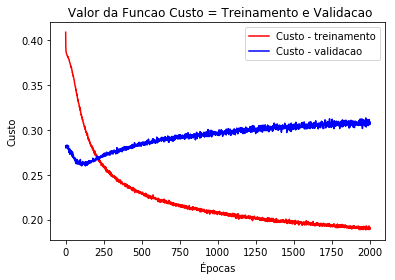

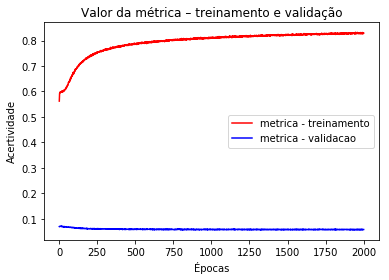

In [44]:
rna3.train(x_train_norm,y_train,x_val_norm,y_val,batch_size,epochs,loss,metric)
rna3.plot()

Confusion matrix, without normalization
[[25684  1301]
 [ 1786  1229]]


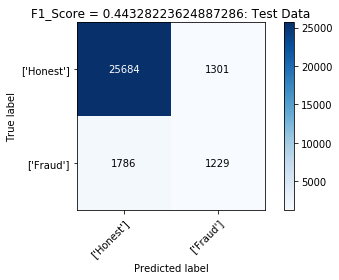

Confusion matrix, without normalization
[[25667  1319]
 [ 1779  1236]]


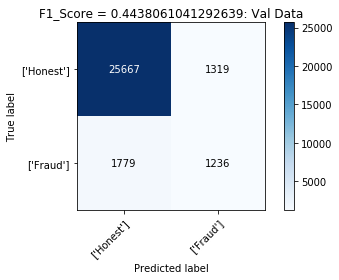

Confusion matrix, without normalization
[[124295   1636]
 [  2205  39999]]


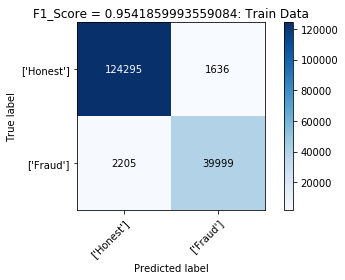

In [45]:
rna3.predict(x_data,y_data)

In [46]:
n_list4 = [50,50,50,1]
activation_list4 = ['tanh','tanh','tanh','sigmoid']
dropout_list4 = [0.3,0.3,0.3]

In [47]:
rna4 = new_rna()
rna4.build_model(data_shape,n_list4,activation_list4,dropout_list4)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total para

Train on 168135 samples, validate on 30001 samples
Epoch 1/2000
168135/168135 [==============================] - 16s 98us/step - loss: 0.4177 - f1: 0.5502 - val_loss: 0.2867 - val_f1: 0.0726
Epoch 2/2000
168135/168135 [==============================] - 16s 92us/step - loss: 0.3968 - f1: 0.5894 - val_loss: 0.2832 - val_f1: 0.0716
Epoch 3/2000
168135/168135 [==============================] - 15s 92us/step - loss: 0.3942 - f1: 0.5961 - val_loss: 0.2815 - val_f1: 0.0719
Epoch 4/2000
168135/168135 [==============================] - 15s 92us/step - loss: 0.3919 - f1: 0.5960 - val_loss: 0.2820 - val_f1: 0.0724
Epoch 5/2000
168135/168135 [==============================] - 15s 92us/step - loss: 0.3912 - f1: 0.5963 - val_loss: 0.2848 - val_f1: 0.0723
Epoch 6/2000
168135/168135 [==============================] - 16s 93us/step - loss: 0.3907 - f1: 0.5986 - val_loss: 0.2813 - val_f1: 0.0719
Epoch 7/2000
168135/168135 [==============================] - 16s 93us/step - loss: 0.3891 - f1: 0.5975 - val

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 16s 93us/step - loss: 0.3839 - f1: 0.5990 - val_loss: 0.2821 - val_f1: 0.0718
Epoch 19/2000
168135/168135 [==============================] - 15s 92us/step - loss: 0.3826 - f1: 0.6025 - val_loss: 0.2806 - val_f1: 0.0712
Epoch 20/2000
168135/168135 [==============================] - 15s 92us/step - loss: 0.3826 - f1: 0.5993 - val_loss: 0.2807 - val_f1: 0.0714
Epoch 21/2000
168135/168135 [==============================] - 15s 92us/step - loss: 0.3815 - f1: 0.6010 - val_loss: 0.2802 - val_f1: 0.0707
Epoch 22/2000
168135/168135 [==============================] - 16s 92us/step - loss: 0.3819 - f1: 0.6020 - val_loss: 0.2774 - val_f1: 0.0703
Epoch 23/2000
168135/168135 [==============================] - 15s 92us/step - loss: 0.3810 - f1: 0.6033 - val_loss: 0.2797 - val_f1: 0.0706
Epoch 24/2000
168135/168135 [==============================] - 16s 92us/step - loss: 0.3815 - f1: 0.5984 - val_loss: 0.2805 - val_f1: 0.0706
Epoch 25/2000
168135/168135

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 16s 94us/step - loss: 0.3776 - f1: 0.6030 - val_loss: 0.2803 - val_f1: 0.0707
Epoch 34/2000
168135/168135 [==============================] - 15s 92us/step - loss: 0.3766 - f1: 0.6058 - val_loss: 0.2810 - val_f1: 0.0707
Epoch 35/2000
168135/168135 [==============================] - 15s 92us/step - loss: 0.3765 - f1: 0.6048 - val_loss: 0.2766 - val_f1: 0.0700
Epoch 36/2000
168135/168135 [==============================] - 16s 92us/step - loss: 0.3753 - f1: 0.6054 - val_loss: 0.2773 - val_f1: 0.0701
Epoch 37/2000
168135/168135 [==============================] - 11s 66us/step - loss: 0.3755 - f1: 0.6048 - val_loss: 0.2802 - val_f1: 0.0707
Epoch 38/2000
168135/168135 [==============================] - 8s 49us/step - loss: 0.3752 - f1: 0.6053 - val_loss: 0.2786 - val_f1: 0.0702
Epoch 39/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.3739 - f1: 0.6077 - val_loss: 0.2803 - val_f1: 0.0705
Epoch 40/2000
168135/168135 [

168135/168135 [==============================] - 8s 48us/step - loss: 0.3537 - f1: 0.6362 - val_loss: 0.2810 - val_f1: 0.0703
Epoch 92/2000
168135/168135 [==============================] - 8s 49us/step - loss: 0.3537 - f1: 0.6367 - val_loss: 0.2739 - val_f1: 0.0685
Epoch 93/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.3532 - f1: 0.6379 - val_loss: 0.2760 - val_f1: 0.0690
Epoch 94/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.3520 - f1: 0.6401 - val_loss: 0.2773 - val_f1: 0.0696
Epoch 95/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.3519 - f1: 0.6394 - val_loss: 0.2759 - val_f1: 0.0691
Epoch 96/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.3519 - f1: 0.6402 - val_loss: 0.2756 - val_f1: 0.0689
Epoch 97/2000
 60704/168135 [=========>....................] - ETA: 4s - loss: 0.3512 - f1: 0.6393

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 47us/step - loss: 0.3492 - f1: 0.6447 - val_loss: 0.2764 - val_f1: 0.0687
Epoch 107/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.3478 - f1: 0.6483 - val_loss: 0.2770 - val_f1: 0.0690
Epoch 108/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.3487 - f1: 0.6454 - val_loss: 0.2753 - val_f1: 0.0689
Epoch 109/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.3469 - f1: 0.6481 - val_loss: 0.2757 - val_f1: 0.0692
Epoch 110/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.3476 - f1: 0.6472 - val_loss: 0.2749 - val_f1: 0.0682
Epoch 111/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.3461 - f1: 0.6483 - val_loss: 0.2761 - val_f1: 0.0689
Epoch 112/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.3466 - f1: 0.6476 - val_loss: 0.2806 - val_f1: 0.0701
Epoch 113/2000
168135/168135

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 47us/step - loss: 0.3422 - f1: 0.6546 - val_loss: 0.2784 - val_f1: 0.0696
Epoch 126/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.3428 - f1: 0.6541 - val_loss: 0.2777 - val_f1: 0.0694
Epoch 127/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.3416 - f1: 0.6585 - val_loss: 0.2767 - val_f1: 0.0694
Epoch 128/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.3416 - f1: 0.6564 - val_loss: 0.2775 - val_f1: 0.0692
Epoch 129/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.3425 - f1: 0.6553 - val_loss: 0.2763 - val_f1: 0.0693
Epoch 130/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.3416 - f1: 0.6565 - val_loss: 0.2760 - val_f1: 0.0690
Epoch 131/2000
114400/168135 [===================>..........] - ETA: 2s - loss: 0.3426 - f1: 0.6545

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 46us/step - loss: 0.3367 - f1: 0.6664 - val_loss: 0.2769 - val_f1: 0.0691
Epoch 149/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.3374 - f1: 0.6626 - val_loss: 0.2776 - val_f1: 0.0692
Epoch 150/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.3367 - f1: 0.6644 - val_loss: 0.2787 - val_f1: 0.0698
Epoch 151/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.3358 - f1: 0.6665 - val_loss: 0.2784 - val_f1: 0.0695
Epoch 152/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.3371 - f1: 0.6620 - val_loss: 0.2757 - val_f1: 0.0692
Epoch 153/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.3360 - f1: 0.6637 - val_loss: 0.2766 - val_f1: 0.0694
Epoch 154/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.3356 - f1: 0.6650 - val_loss: 0.2783 - val_f1: 0.0697
Epoch 155/2000
168135/168135

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 47us/step - loss: 0.3332 - f1: 0.6702 - val_loss: 0.2784 - val_f1: 0.0695
Epoch 167/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.3325 - f1: 0.6714 - val_loss: 0.2800 - val_f1: 0.0699
Epoch 168/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.3331 - f1: 0.6698 - val_loss: 0.2757 - val_f1: 0.0689
Epoch 169/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.3344 - f1: 0.6698 - val_loss: 0.2747 - val_f1: 0.0690
Epoch 170/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.3310 - f1: 0.6712 - val_loss: 0.2768 - val_f1: 0.0693
Epoch 171/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.3323 - f1: 0.6698 - val_loss: 0.2774 - val_f1: 0.0693
Epoch 172/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.3316 - f1: 0.6713 - val_loss: 0.2791 - val_f1: 0.0698
Epoch 173/2000
 28928/168135

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 46us/step - loss: 0.3315 - f1: 0.6724 - val_loss: 0.2754 - val_f1: 0.0687
Epoch 182/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.3293 - f1: 0.6760 - val_loss: 0.2790 - val_f1: 0.0695
Epoch 183/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.3314 - f1: 0.6724 - val_loss: 0.2763 - val_f1: 0.0689
Epoch 184/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.3302 - f1: 0.6729 - val_loss: 0.2766 - val_f1: 0.0688
Epoch 185/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.3305 - f1: 0.6720 - val_loss: 0.2811 - val_f1: 0.0696
Epoch 186/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.3295 - f1: 0.6743 - val_loss: 0.2792 - val_f1: 0.0694
Epoch 187/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.3296 - f1: 0.6753 - val_loss: 0.2775 - val_f1: 0.0691
Epoch 188/2000
168135/168135

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 47us/step - loss: 0.3247 - f1: 0.6829 - val_loss: 0.2784 - val_f1: 0.0690
Epoch 211/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.3241 - f1: 0.6818 - val_loss: 0.2791 - val_f1: 0.0691
Epoch 212/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.3256 - f1: 0.6802 - val_loss: 0.2832 - val_f1: 0.0698
Epoch 213/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.3254 - f1: 0.6837 - val_loss: 0.2793 - val_f1: 0.0693
Epoch 214/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.3257 - f1: 0.6796 - val_loss: 0.2777 - val_f1: 0.0692
Epoch 215/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.3252 - f1: 0.6823 - val_loss: 0.2806 - val_f1: 0.0695
Epoch 216/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.3253 - f1: 0.6818 - val_loss: 0.2764 - val_f1: 0.0685
Epoch 217/2000
168135/168135

168135/168135 [==============================] - 8s 47us/step - loss: 0.3189 - f1: 0.6913 - val_loss: 0.2785 - val_f1: 0.0688
Epoch 269/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.3188 - f1: 0.6928 - val_loss: 0.2808 - val_f1: 0.0694
Epoch 270/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.3195 - f1: 0.6886 - val_loss: 0.2792 - val_f1: 0.0689
Epoch 271/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.3193 - f1: 0.6915 - val_loss: 0.2807 - val_f1: 0.0694
Epoch 272/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.3178 - f1: 0.6914 - val_loss: 0.2766 - val_f1: 0.0684
Epoch 273/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.3180 - f1: 0.6894 - val_loss: 0.2801 - val_f1: 0.0690
Epoch 274/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.3177 - f1: 0.6927 - val_loss: 0.2792 - val_f1: 0.0689
Epoch 275/2000
168135/168135

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 47us/step - loss: 0.3162 - f1: 0.6953 - val_loss: 0.2818 - val_f1: 0.0691
Epoch 298/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.3153 - f1: 0.6952 - val_loss: 0.2784 - val_f1: 0.0688
Epoch 299/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.3164 - f1: 0.6943 - val_loss: 0.2818 - val_f1: 0.0699
Epoch 300/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.3147 - f1: 0.6958 - val_loss: 0.2796 - val_f1: 0.0688
Epoch 301/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.3157 - f1: 0.6945 - val_loss: 0.2796 - val_f1: 0.0690
Epoch 302/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.3157 - f1: 0.6935 - val_loss: 0.2827 - val_f1: 0.0692
Epoch 303/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.3142 - f1: 0.6937 - val_loss: 0.2805 - val_f1: 0.0691
Epoch 304/2000
168135/168135

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 46us/step - loss: 0.3150 - f1: 0.6964 - val_loss: 0.2791 - val_f1: 0.0686
Epoch 327/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.3141 - f1: 0.6974 - val_loss: 0.2834 - val_f1: 0.0696
Epoch 328/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.3139 - f1: 0.6952 - val_loss: 0.2783 - val_f1: 0.0685
Epoch 329/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.3139 - f1: 0.6977 - val_loss: 0.2806 - val_f1: 0.0691
Epoch 330/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.3128 - f1: 0.6984 - val_loss: 0.2791 - val_f1: 0.0689
Epoch 331/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.3131 - f1: 0.7002 - val_loss: 0.2846 - val_f1: 0.0696
Epoch 332/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.3122 - f1: 0.6998 - val_loss: 0.2811 - val_f1: 0.0690
Epoch 333/2000
 16960/168135

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 48us/step - loss: 0.3128 - f1: 0.6991 - val_loss: 0.2767 - val_f1: 0.0683
Epoch 344/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.3120 - f1: 0.6988 - val_loss: 0.2771 - val_f1: 0.0681
Epoch 345/2000
168135/168135 [==============================] - 8s 49us/step - loss: 0.3131 - f1: 0.6969 - val_loss: 0.2805 - val_f1: 0.0689
Epoch 346/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.3121 - f1: 0.6995 - val_loss: 0.2838 - val_f1: 0.0694
Epoch 347/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.3130 - f1: 0.7002 - val_loss: 0.2839 - val_f1: 0.0692
Epoch 348/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.3130 - f1: 0.6978 - val_loss: 0.2804 - val_f1: 0.0689
Epoch 349/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.3122 - f1: 0.6994 - val_loss: 0.2782 - val_f1: 0.0682
Epoch 350/2000
168135/168135

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 48us/step - loss: 0.3117 - f1: 0.6997 - val_loss: 0.2796 - val_f1: 0.0688
Epoch 371/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.3116 - f1: 0.7011 - val_loss: 0.2796 - val_f1: 0.0686
Epoch 372/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.3090 - f1: 0.7029 - val_loss: 0.2817 - val_f1: 0.0693
Epoch 373/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.3100 - f1: 0.7011 - val_loss: 0.2804 - val_f1: 0.0687
Epoch 374/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.3112 - f1: 0.7015 - val_loss: 0.2832 - val_f1: 0.0691
Epoch 375/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.3097 - f1: 0.7017 - val_loss: 0.2778 - val_f1: 0.0684
Epoch 376/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.3096 - f1: 0.7049 - val_loss: 0.2783 - val_f1: 0.0681
Epoch 377/2000
168135/168135

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 48us/step - loss: 0.3078 - f1: 0.7052 - val_loss: 0.2763 - val_f1: 0.0678
Epoch 409/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.3077 - f1: 0.7058 - val_loss: 0.2830 - val_f1: 0.0695
Epoch 410/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.3086 - f1: 0.7054 - val_loss: 0.2820 - val_f1: 0.0688
Epoch 411/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.3069 - f1: 0.7066 - val_loss: 0.2809 - val_f1: 0.0686
Epoch 412/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.3078 - f1: 0.7025 - val_loss: 0.2839 - val_f1: 0.0695
Epoch 413/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.3084 - f1: 0.7045 - val_loss: 0.2818 - val_f1: 0.0689
Epoch 414/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.3076 - f1: 0.7054 - val_loss: 0.2853 - val_f1: 0.0694
Epoch 415/2000
168135/168135

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 47us/step - loss: 0.3062 - f1: 0.7074 - val_loss: 0.2759 - val_f1: 0.0676
Epoch 452/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.3060 - f1: 0.7093 - val_loss: 0.2773 - val_f1: 0.0679
Epoch 453/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.3057 - f1: 0.7096 - val_loss: 0.2798 - val_f1: 0.0681
Epoch 454/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.3049 - f1: 0.7109 - val_loss: 0.2793 - val_f1: 0.0683
Epoch 455/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.3043 - f1: 0.7112 - val_loss: 0.2790 - val_f1: 0.0686
Epoch 456/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.3053 - f1: 0.7105 - val_loss: 0.2836 - val_f1: 0.0692
Epoch 457/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.3054 - f1: 0.7100 - val_loss: 0.2797 - val_f1: 0.0682
Epoch 458/2000
168135/168135

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 48us/step - loss: 0.3044 - f1: 0.7086 - val_loss: 0.2818 - val_f1: 0.0687
Epoch 495/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.3046 - f1: 0.7119 - val_loss: 0.2838 - val_f1: 0.0687
Epoch 496/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.3035 - f1: 0.7129 - val_loss: 0.2817 - val_f1: 0.0684
Epoch 497/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.3028 - f1: 0.7127 - val_loss: 0.2818 - val_f1: 0.0684
Epoch 498/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.3031 - f1: 0.7122 - val_loss: 0.2828 - val_f1: 0.0689
Epoch 499/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.3032 - f1: 0.7118 - val_loss: 0.2810 - val_f1: 0.0682
Epoch 500/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.3023 - f1: 0.7113 - val_loss: 0.2837 - val_f1: 0.0688
Epoch 501/2000
168135/168135

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 48us/step - loss: 0.3033 - f1: 0.7123 - val_loss: 0.2805 - val_f1: 0.0683
Epoch 534/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.3024 - f1: 0.7125 - val_loss: 0.2832 - val_f1: 0.0684
Epoch 535/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.3026 - f1: 0.7121 - val_loss: 0.2799 - val_f1: 0.0676
Epoch 536/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.3017 - f1: 0.7129 - val_loss: 0.2766 - val_f1: 0.0672
Epoch 537/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.3024 - f1: 0.7116 - val_loss: 0.2822 - val_f1: 0.0685
Epoch 538/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.3034 - f1: 0.7111 - val_loss: 0.2801 - val_f1: 0.0681
Epoch 539/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.3019 - f1: 0.7142 - val_loss: 0.2811 - val_f1: 0.0680
Epoch 540/2000
168135/168135

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 48us/step - loss: 0.3014 - f1: 0.7144 - val_loss: 0.2802 - val_f1: 0.0683
Epoch 572/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.3000 - f1: 0.7134 - val_loss: 0.2817 - val_f1: 0.0680
Epoch 573/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.3003 - f1: 0.7153 - val_loss: 0.2804 - val_f1: 0.0682
Epoch 574/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.3011 - f1: 0.7146 - val_loss: 0.2800 - val_f1: 0.0678
Epoch 575/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.3013 - f1: 0.7164 - val_loss: 0.2834 - val_f1: 0.0685
Epoch 576/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.3002 - f1: 0.7176 - val_loss: 0.2863 - val_f1: 0.0691
Epoch 577/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.3008 - f1: 0.7136 - val_loss: 0.2803 - val_f1: 0.0679
Epoch 578/2000
168135/168135

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 47us/step - loss: 0.3006 - f1: 0.7155 - val_loss: 0.2808 - val_f1: 0.0681
Epoch 599/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.3003 - f1: 0.7153 - val_loss: 0.2833 - val_f1: 0.0686
Epoch 600/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.2992 - f1: 0.7157 - val_loss: 0.2828 - val_f1: 0.0680
Epoch 601/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.3002 - f1: 0.7160 - val_loss: 0.2824 - val_f1: 0.0685
Epoch 602/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2993 - f1: 0.7154 - val_loss: 0.2832 - val_f1: 0.0686
Epoch 603/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2990 - f1: 0.7176 - val_loss: 0.2823 - val_f1: 0.0683
Epoch 604/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.3010 - f1: 0.7165 - val_loss: 0.2820 - val_f1: 0.0684
Epoch 605/2000
168135/168135

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 48us/step - loss: 0.2983 - f1: 0.7189 - val_loss: 0.2846 - val_f1: 0.0691
Epoch 660/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2986 - f1: 0.7191 - val_loss: 0.2806 - val_f1: 0.0675
Epoch 661/2000
168135/168135 [==============================] - 8s 49us/step - loss: 0.2981 - f1: 0.7183 - val_loss: 0.2799 - val_f1: 0.0675
Epoch 662/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.2978 - f1: 0.7167 - val_loss: 0.2802 - val_f1: 0.0679
Epoch 663/2000
168135/168135 [==============================] - 8s 49us/step - loss: 0.2982 - f1: 0.7200 - val_loss: 0.2859 - val_f1: 0.0688
Epoch 664/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2975 - f1: 0.7183 - val_loss: 0.2843 - val_f1: 0.0687
Epoch 665/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2982 - f1: 0.7155 - val_loss: 0.2856 - val_f1: 0.0689
Epoch 666/2000
168135/168135

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 48us/step - loss: 0.2971 - f1: 0.7161 - val_loss: 0.2828 - val_f1: 0.0682
Epoch 688/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.2973 - f1: 0.7179 - val_loss: 0.2765 - val_f1: 0.0665
Epoch 689/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2968 - f1: 0.7201 - val_loss: 0.2822 - val_f1: 0.0676
Epoch 690/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2975 - f1: 0.7211 - val_loss: 0.2833 - val_f1: 0.0682
Epoch 691/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2965 - f1: 0.7197 - val_loss: 0.2813 - val_f1: 0.0676
Epoch 692/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2979 - f1: 0.7161 - val_loss: 0.2827 - val_f1: 0.0685
Epoch 693/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2974 - f1: 0.7197 - val_loss: 0.2771 - val_f1: 0.0670
Epoch 694/2000
168135/168135

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 48us/step - loss: 0.2952 - f1: 0.7226 - val_loss: 0.2846 - val_f1: 0.0686
Epoch 718/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2970 - f1: 0.7204 - val_loss: 0.2792 - val_f1: 0.0673
Epoch 719/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2958 - f1: 0.7207 - val_loss: 0.2799 - val_f1: 0.0676
Epoch 720/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2966 - f1: 0.7209 - val_loss: 0.2858 - val_f1: 0.0684
Epoch 721/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2968 - f1: 0.7205 - val_loss: 0.2792 - val_f1: 0.0674
Epoch 722/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.2957 - f1: 0.7216 - val_loss: 0.2833 - val_f1: 0.0681
Epoch 723/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2952 - f1: 0.7200 - val_loss: 0.2849 - val_f1: 0.0683
Epoch 724/2000
168135/168135

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 46us/step - loss: 0.2972 - f1: 0.7207 - val_loss: 0.2834 - val_f1: 0.0683
Epoch 749/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.2955 - f1: 0.7230 - val_loss: 0.2872 - val_f1: 0.0683
Epoch 750/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2949 - f1: 0.7201 - val_loss: 0.2835 - val_f1: 0.0680
Epoch 751/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.2970 - f1: 0.7194 - val_loss: 0.2800 - val_f1: 0.0678
Epoch 752/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2959 - f1: 0.7225 - val_loss: 0.2812 - val_f1: 0.0677
Epoch 753/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2959 - f1: 0.7217 - val_loss: 0.2793 - val_f1: 0.0676
Epoch 754/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2962 - f1: 0.7213 - val_loss: 0.2809 - val_f1: 0.0677
Epoch 755/2000
168135/168135

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 48us/step - loss: 0.2946 - f1: 0.7207 - val_loss: 0.2843 - val_f1: 0.0683
Epoch 779/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2974 - f1: 0.7196 - val_loss: 0.2828 - val_f1: 0.0679
Epoch 780/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2953 - f1: 0.7224 - val_loss: 0.2848 - val_f1: 0.0682
Epoch 781/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2953 - f1: 0.7200 - val_loss: 0.2833 - val_f1: 0.0680
Epoch 782/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2952 - f1: 0.7213 - val_loss: 0.2855 - val_f1: 0.0681
Epoch 783/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2967 - f1: 0.7192 - val_loss: 0.2858 - val_f1: 0.0687
Epoch 784/2000
168135/168135 [==============================] - 8s 50us/step - loss: 0.2947 - f1: 0.7218 - val_loss: 0.2870 - val_f1: 0.0687
Epoch 785/2000
168135/168135

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 46us/step - loss: 0.2943 - f1: 0.7229 - val_loss: 0.2864 - val_f1: 0.0685
Epoch 810/2000
168135/168135 [==============================] - 8s 49us/step - loss: 0.2927 - f1: 0.7236 - val_loss: 0.2823 - val_f1: 0.0679
Epoch 811/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2928 - f1: 0.7271 - val_loss: 0.2846 - val_f1: 0.0680
Epoch 812/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2933 - f1: 0.7245 - val_loss: 0.2802 - val_f1: 0.0675
Epoch 813/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2935 - f1: 0.7233 - val_loss: 0.2868 - val_f1: 0.0684
Epoch 814/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2939 - f1: 0.7242 - val_loss: 0.2854 - val_f1: 0.0685
Epoch 815/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2949 - f1: 0.7226 - val_loss: 0.2844 - val_f1: 0.0682
Epoch 816/2000
168135/168135

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 47us/step - loss: 0.2933 - f1: 0.7218 - val_loss: 0.2865 - val_f1: 0.0685
Epoch 840/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2946 - f1: 0.7244 - val_loss: 0.2821 - val_f1: 0.0679
Epoch 841/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2932 - f1: 0.7238 - val_loss: 0.2837 - val_f1: 0.0679
Epoch 842/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2928 - f1: 0.7242 - val_loss: 0.2853 - val_f1: 0.0678
Epoch 843/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2934 - f1: 0.7233 - val_loss: 0.2828 - val_f1: 0.0682
Epoch 844/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2938 - f1: 0.7219 - val_loss: 0.2807 - val_f1: 0.0678
Epoch 845/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2939 - f1: 0.7244 - val_loss: 0.2842 - val_f1: 0.0681
Epoch 846/2000
168135/168135

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 48us/step - loss: 0.2927 - f1: 0.7254 - val_loss: 0.2876 - val_f1: 0.0684
Epoch 870/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2924 - f1: 0.7268 - val_loss: 0.2813 - val_f1: 0.0677
Epoch 871/2000
168135/168135 [==============================] - 8s 51us/step - loss: 0.2930 - f1: 0.7258 - val_loss: 0.2863 - val_f1: 0.0686
Epoch 872/2000
168135/168135 [==============================] - 9s 51us/step - loss: 0.2926 - f1: 0.7251 - val_loss: 0.2850 - val_f1: 0.0684
Epoch 873/2000
168135/168135 [==============================] - 8s 50us/step - loss: 0.2926 - f1: 0.7242 - val_loss: 0.2825 - val_f1: 0.0679
Epoch 874/2000
168135/168135 [==============================] - 9s 51us/step - loss: 0.2938 - f1: 0.7224 - val_loss: 0.2841 - val_f1: 0.0683
Epoch 875/2000
168135/168135 [==============================] - 8s 50us/step - loss: 0.2917 - f1: 0.7280 - val_loss: 0.2841 - val_f1: 0.0681
Epoch 876/2000
168135/168135

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 50us/step - loss: 0.2922 - f1: 0.7271 - val_loss: 0.2870 - val_f1: 0.0678
Epoch 898/2000
168135/168135 [==============================] - 9s 51us/step - loss: 0.2934 - f1: 0.7241 - val_loss: 0.2771 - val_f1: 0.0664
Epoch 899/2000
168135/168135 [==============================] - 9s 51us/step - loss: 0.2929 - f1: 0.7248 - val_loss: 0.2827 - val_f1: 0.0679
Epoch 900/2000
168135/168135 [==============================] - 8s 50us/step - loss: 0.2919 - f1: 0.7243 - val_loss: 0.2820 - val_f1: 0.0675
Epoch 901/2000
168135/168135 [==============================] - 9s 51us/step - loss: 0.2924 - f1: 0.7250 - val_loss: 0.2877 - val_f1: 0.0687
Epoch 902/2000
168135/168135 [==============================] - 8s 49us/step - loss: 0.2922 - f1: 0.7259 - val_loss: 0.2871 - val_f1: 0.0682
Epoch 903/2000
168135/168135 [==============================] - 9s 51us/step - loss: 0.2928 - f1: 0.7253 - val_loss: 0.2829 - val_f1: 0.0678
Epoch 904/2000
168135/168135

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 47us/step - loss: 0.2908 - f1: 0.7269 - val_loss: 0.2800 - val_f1: 0.0672
Epoch 925/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2914 - f1: 0.7267 - val_loss: 0.2836 - val_f1: 0.0682
Epoch 926/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2911 - f1: 0.7262 - val_loss: 0.2793 - val_f1: 0.0669
Epoch 927/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2923 - f1: 0.7245 - val_loss: 0.2894 - val_f1: 0.0683
Epoch 928/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.2919 - f1: 0.7259 - val_loss: 0.2873 - val_f1: 0.0683
Epoch 929/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2921 - f1: 0.7271 - val_loss: 0.2805 - val_f1: 0.0673
Epoch 930/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.2920 - f1: 0.7259 - val_loss: 0.2833 - val_f1: 0.0676
Epoch 931/2000
168135/168135

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 48us/step - loss: 0.2926 - f1: 0.7251 - val_loss: 0.2839 - val_f1: 0.0679
Epoch 952/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2911 - f1: 0.7255 - val_loss: 0.2843 - val_f1: 0.0680
Epoch 953/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2912 - f1: 0.7278 - val_loss: 0.2837 - val_f1: 0.0676
Epoch 954/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.2921 - f1: 0.7256 - val_loss: 0.2881 - val_f1: 0.0683
Epoch 955/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2911 - f1: 0.7267 - val_loss: 0.2838 - val_f1: 0.0679
Epoch 956/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2907 - f1: 0.7287 - val_loss: 0.2836 - val_f1: 0.0675
Epoch 957/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2911 - f1: 0.7275 - val_loss: 0.2871 - val_f1: 0.0682
Epoch 958/2000
168135/168135

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 49us/step - loss: 0.2903 - f1: 0.7284 - val_loss: 0.2857 - val_f1: 0.0679
Epoch 996/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2906 - f1: 0.7284 - val_loss: 0.2806 - val_f1: 0.0671
Epoch 997/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2907 - f1: 0.7283 - val_loss: 0.2816 - val_f1: 0.0673
Epoch 998/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2903 - f1: 0.7295 - val_loss: 0.2855 - val_f1: 0.0681
Epoch 999/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2917 - f1: 0.7281 - val_loss: 0.2850 - val_f1: 0.0678
Epoch 1000/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2896 - f1: 0.7257 - val_loss: 0.2846 - val_f1: 0.0679
Epoch 1001/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2902 - f1: 0.7273 - val_loss: 0.2862 - val_f1: 0.0683
Epoch 1002/2000
168135/168

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 47us/step - loss: 0.2891 - f1: 0.7301 - val_loss: 0.2820 - val_f1: 0.0671
Epoch 1033/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2899 - f1: 0.7281 - val_loss: 0.2858 - val_f1: 0.0679
Epoch 1034/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2887 - f1: 0.7322 - val_loss: 0.2826 - val_f1: 0.0673
Epoch 1035/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2900 - f1: 0.7295 - val_loss: 0.2827 - val_f1: 0.0676
Epoch 1036/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.2893 - f1: 0.7306 - val_loss: 0.2856 - val_f1: 0.0676
Epoch 1037/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2903 - f1: 0.7265 - val_loss: 0.2867 - val_f1: 0.0679
Epoch 1038/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2903 - f1: 0.7286 - val_loss: 0.2835 - val_f1: 0.0679
Epoch 1039/2000
168135

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 47us/step - loss: 0.2895 - f1: 0.7313 - val_loss: 0.2835 - val_f1: 0.0677
Epoch 1070/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2888 - f1: 0.7304 - val_loss: 0.2795 - val_f1: 0.0667
Epoch 1071/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2887 - f1: 0.7298 - val_loss: 0.2814 - val_f1: 0.0670
Epoch 1072/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2892 - f1: 0.7285 - val_loss: 0.2872 - val_f1: 0.0680
Epoch 1073/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2890 - f1: 0.7303 - val_loss: 0.2815 - val_f1: 0.0673
Epoch 1074/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2881 - f1: 0.7323 - val_loss: 0.2841 - val_f1: 0.0674
Epoch 1075/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.2892 - f1: 0.7312 - val_loss: 0.2823 - val_f1: 0.0673
Epoch 1076/2000
168135

Epoch 1127/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2890 - f1: 0.7300 - val_loss: 0.2829 - val_f1: 0.0674
Epoch 1128/2000
 64224/168135 [==========>...................] - ETA: 4s - loss: 0.2878 - f1: 0.7298

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 48us/step - loss: 0.2891 - f1: 0.7302 - val_loss: 0.2813 - val_f1: 0.0667
Epoch 1137/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2894 - f1: 0.7282 - val_loss: 0.2858 - val_f1: 0.0674
Epoch 1138/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2882 - f1: 0.7296 - val_loss: 0.2871 - val_f1: 0.0681
Epoch 1139/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2892 - f1: 0.7287 - val_loss: 0.2852 - val_f1: 0.0675
Epoch 1140/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2880 - f1: 0.7316 - val_loss: 0.2854 - val_f1: 0.0677
Epoch 1141/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2884 - f1: 0.7294 - val_loss: 0.2871 - val_f1: 0.0675
Epoch 1142/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2882 - f1: 0.7297 - val_loss: 0.2878 - val_f1: 0.0683
Epoch 1143/2000
168135

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 48us/step - loss: 0.2891 - f1: 0.7292 - val_loss: 0.2823 - val_f1: 0.0670
Epoch 1163/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.2872 - f1: 0.7344 - val_loss: 0.2862 - val_f1: 0.0675
Epoch 1164/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2885 - f1: 0.7301 - val_loss: 0.2898 - val_f1: 0.0680
Epoch 1165/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2886 - f1: 0.7279 - val_loss: 0.2832 - val_f1: 0.0676
Epoch 1166/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2887 - f1: 0.7304 - val_loss: 0.2846 - val_f1: 0.0673
Epoch 1167/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2863 - f1: 0.7305 - val_loss: 0.2817 - val_f1: 0.0674
Epoch 1168/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2871 - f1: 0.7328 - val_loss: 0.2833 - val_f1: 0.0673
Epoch 1169/2000
168135

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 48us/step - loss: 0.2886 - f1: 0.7296 - val_loss: 0.2858 - val_f1: 0.0675
Epoch 1195/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.2867 - f1: 0.7310 - val_loss: 0.2899 - val_f1: 0.0684
Epoch 1196/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2878 - f1: 0.7300 - val_loss: 0.2884 - val_f1: 0.0681
Epoch 1197/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2883 - f1: 0.7273 - val_loss: 0.2849 - val_f1: 0.0675
Epoch 1198/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2892 - f1: 0.7276 - val_loss: 0.2859 - val_f1: 0.0676
Epoch 1199/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2880 - f1: 0.7321 - val_loss: 0.2867 - val_f1: 0.0680
Epoch 1200/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2867 - f1: 0.7332 - val_loss: 0.2806 - val_f1: 0.0670
Epoch 1201/2000
168135

Epoch 1252/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2878 - f1: 0.7314 - val_loss: 0.2846 - val_f1: 0.0675
Epoch 1253/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2867 - f1: 0.7310 - val_loss: 0.2839 - val_f1: 0.0673
Epoch 1254/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2870 - f1: 0.7313 - val_loss: 0.2876 - val_f1: 0.0679
Epoch 1255/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2866 - f1: 0.7311 - val_loss: 0.2847 - val_f1: 0.0677
Epoch 1256/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.2866 - f1: 0.7339 - val_loss: 0.2918 - val_f1: 0.0684
Epoch 1257/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2871 - f1: 0.7327 - val_loss: 0.2906 - val_f1: 0.0685
Epoch 1258/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2873 - f1: 0.7325 - val_loss: 0.2870 - val_f1: 0.0675
Epoch 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 48us/step - loss: 0.2861 - f1: 0.7335 - val_loss: 0.2837 - val_f1: 0.0673
Epoch 1298/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2870 - f1: 0.7322 - val_loss: 0.2854 - val_f1: 0.0680
Epoch 1299/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2883 - f1: 0.7297 - val_loss: 0.2833 - val_f1: 0.0673
Epoch 1300/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.2854 - f1: 0.7333 - val_loss: 0.2877 - val_f1: 0.0678
Epoch 1301/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2870 - f1: 0.7331 - val_loss: 0.2836 - val_f1: 0.0670
Epoch 1302/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2857 - f1: 0.7350 - val_loss: 0.2891 - val_f1: 0.0684
Epoch 1303/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2867 - f1: 0.7351 - val_loss: 0.2854 - val_f1: 0.0675
Epoch 1304/2000
168135

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 47us/step - loss: 0.2854 - f1: 0.7350 - val_loss: 0.2855 - val_f1: 0.0673
Epoch 1329/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2853 - f1: 0.7331 - val_loss: 0.2866 - val_f1: 0.0677
Epoch 1330/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2866 - f1: 0.7333 - val_loss: 0.2838 - val_f1: 0.0672
Epoch 1331/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2868 - f1: 0.7321 - val_loss: 0.2827 - val_f1: 0.0674
Epoch 1332/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.2850 - f1: 0.7352 - val_loss: 0.2845 - val_f1: 0.0674
Epoch 1333/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2853 - f1: 0.7337 - val_loss: 0.2827 - val_f1: 0.0674
Epoch 1334/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2844 - f1: 0.7343 - val_loss: 0.2843 - val_f1: 0.0669
Epoch 1335/2000
168135

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 46us/step - loss: 0.2848 - f1: 0.7346 - val_loss: 0.2853 - val_f1: 0.0672
Epoch 1357/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2858 - f1: 0.7335 - val_loss: 0.2882 - val_f1: 0.0676
Epoch 1358/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.2859 - f1: 0.7349 - val_loss: 0.2883 - val_f1: 0.0682
Epoch 1359/2000
168135/168135 [==============================] - 8s 49us/step - loss: 0.2852 - f1: 0.7323 - val_loss: 0.2817 - val_f1: 0.0669
Epoch 1360/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2873 - f1: 0.7334 - val_loss: 0.2850 - val_f1: 0.0677
Epoch 1361/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2853 - f1: 0.7338 - val_loss: 0.2831 - val_f1: 0.0671
Epoch 1362/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2854 - f1: 0.7338 - val_loss: 0.2875 - val_f1: 0.0676
Epoch 1363/2000
168135

Epoch 1414/2000
110048/168135 [==================>...........] - ETA: 2s - loss: 0.2853 - f1: 0.73

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 47us/step - loss: 0.2853 - f1: 0.7353 - val_loss: 0.2848 - val_f1: 0.0677
Epoch 1425/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2832 - f1: 0.7366 - val_loss: 0.2910 - val_f1: 0.0682
Epoch 1426/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2848 - f1: 0.7338 - val_loss: 0.2824 - val_f1: 0.0670
Epoch 1427/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2848 - f1: 0.7358 - val_loss: 0.2882 - val_f1: 0.0676
Epoch 1428/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2849 - f1: 0.7362 - val_loss: 0.2840 - val_f1: 0.0667
Epoch 1429/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2855 - f1: 0.7328 - val_loss: 0.2810 - val_f1: 0.0667
Epoch 1430/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2849 - f1: 0.7342 - val_loss: 0.2823 - val_f1: 0.0668
Epoch 1431/2000
168135

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 48us/step - loss: 0.2847 - f1: 0.7363 - val_loss: 0.2865 - val_f1: 0.0673
Epoch 1479/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.2846 - f1: 0.7359 - val_loss: 0.2882 - val_f1: 0.0678
Epoch 1480/2000
168135/168135 [==============================] - 8s 49us/step - loss: 0.2832 - f1: 0.7375 - val_loss: 0.2846 - val_f1: 0.0675
Epoch 1481/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2843 - f1: 0.7355 - val_loss: 0.2813 - val_f1: 0.0665
Epoch 1482/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2838 - f1: 0.7369 - val_loss: 0.2860 - val_f1: 0.0673
Epoch 1483/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2843 - f1: 0.7373 - val_loss: 0.2848 - val_f1: 0.0672
Epoch 1484/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2843 - f1: 0.7357 - val_loss: 0.2904 - val_f1: 0.0682
Epoch 1485/2000
168135

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 47us/step - loss: 0.2835 - f1: 0.7359 - val_loss: 0.2904 - val_f1: 0.0682
Epoch 1520/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2845 - f1: 0.7359 - val_loss: 0.2891 - val_f1: 0.0679
Epoch 1521/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.2838 - f1: 0.7354 - val_loss: 0.2802 - val_f1: 0.0665
Epoch 1522/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2841 - f1: 0.7357 - val_loss: 0.2848 - val_f1: 0.0674
Epoch 1523/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2828 - f1: 0.7386 - val_loss: 0.2890 - val_f1: 0.0677
Epoch 1524/2000
168135/168135 [==============================] - 8s 49us/step - loss: 0.2837 - f1: 0.7371 - val_loss: 0.2894 - val_f1: 0.0676
Epoch 1525/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2839 - f1: 0.7364 - val_loss: 0.2854 - val_f1: 0.0672
Epoch 1526/2000
168135

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 48us/step - loss: 0.2836 - f1: 0.7359 - val_loss: 0.2842 - val_f1: 0.0667
Epoch 1549/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2845 - f1: 0.7349 - val_loss: 0.2870 - val_f1: 0.0675
Epoch 1550/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2840 - f1: 0.7391 - val_loss: 0.2865 - val_f1: 0.0675
Epoch 1551/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2824 - f1: 0.7389 - val_loss: 0.2893 - val_f1: 0.0677
Epoch 1552/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2851 - f1: 0.7357 - val_loss: 0.2858 - val_f1: 0.0676
Epoch 1553/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.2838 - f1: 0.7358 - val_loss: 0.2908 - val_f1: 0.0681
Epoch 1554/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2830 - f1: 0.7377 - val_loss: 0.2866 - val_f1: 0.0674
Epoch 1555/2000
168135

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 48us/step - loss: 0.2826 - f1: 0.7402 - val_loss: 0.2891 - val_f1: 0.0678
Epoch 1590/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2826 - f1: 0.7379 - val_loss: 0.2886 - val_f1: 0.0680
Epoch 1591/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2837 - f1: 0.7369 - val_loss: 0.2864 - val_f1: 0.0674
Epoch 1592/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.2849 - f1: 0.7340 - val_loss: 0.2888 - val_f1: 0.0676
Epoch 1593/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2840 - f1: 0.7348 - val_loss: 0.2850 - val_f1: 0.0673
Epoch 1594/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2841 - f1: 0.7372 - val_loss: 0.2877 - val_f1: 0.0676
Epoch 1595/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2834 - f1: 0.7366 - val_loss: 0.2887 - val_f1: 0.0680
Epoch 1596/2000
168135

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 46us/step - loss: 0.2833 - f1: 0.7364 - val_loss: 0.2866 - val_f1: 0.0676
Epoch 1619/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2834 - f1: 0.7374 - val_loss: 0.2829 - val_f1: 0.0668
Epoch 1620/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2839 - f1: 0.7347 - val_loss: 0.2872 - val_f1: 0.0681
Epoch 1621/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2822 - f1: 0.7389 - val_loss: 0.2861 - val_f1: 0.0674
Epoch 1622/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2819 - f1: 0.7388 - val_loss: 0.2960 - val_f1: 0.0685
Epoch 1623/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2835 - f1: 0.7383 - val_loss: 0.2859 - val_f1: 0.0669
Epoch 1624/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2822 - f1: 0.7375 - val_loss: 0.2862 - val_f1: 0.0672
Epoch 1625/2000
168135

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 48us/step - loss: 0.2825 - f1: 0.7361 - val_loss: 0.2909 - val_f1: 0.0680
Epoch 1646/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2833 - f1: 0.7374 - val_loss: 0.2908 - val_f1: 0.0683
Epoch 1647/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2830 - f1: 0.7385 - val_loss: 0.2880 - val_f1: 0.0674
Epoch 1648/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2835 - f1: 0.7370 - val_loss: 0.2910 - val_f1: 0.0681
Epoch 1649/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2827 - f1: 0.7366 - val_loss: 0.2870 - val_f1: 0.0678
Epoch 1650/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.2822 - f1: 0.7375 - val_loss: 0.2916 - val_f1: 0.0676
Epoch 1651/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2816 - f1: 0.7392 - val_loss: 0.2847 - val_f1: 0.0673
Epoch 1652/2000
168135

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 47us/step - loss: 0.2822 - f1: 0.7406 - val_loss: 0.2857 - val_f1: 0.0673
Epoch 1689/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2831 - f1: 0.7365 - val_loss: 0.2861 - val_f1: 0.0674
Epoch 1690/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2816 - f1: 0.7387 - val_loss: 0.2861 - val_f1: 0.0674
Epoch 1691/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2832 - f1: 0.7369 - val_loss: 0.2815 - val_f1: 0.0669
Epoch 1692/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.2825 - f1: 0.7386 - val_loss: 0.2854 - val_f1: 0.0671
Epoch 1693/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2818 - f1: 0.7378 - val_loss: 0.2867 - val_f1: 0.0673
Epoch 1694/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2825 - f1: 0.7389 - val_loss: 0.2853 - val_f1: 0.0672
Epoch 1695/2000
168135

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 47us/step - loss: 0.2809 - f1: 0.7384 - val_loss: 0.2875 - val_f1: 0.0674
Epoch 1718/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2822 - f1: 0.7382 - val_loss: 0.2822 - val_f1: 0.0666
Epoch 1719/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2808 - f1: 0.7395 - val_loss: 0.2859 - val_f1: 0.0673
Epoch 1720/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2808 - f1: 0.7403 - val_loss: 0.2846 - val_f1: 0.0668
Epoch 1721/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.2824 - f1: 0.7381 - val_loss: 0.2914 - val_f1: 0.0684
Epoch 1722/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2804 - f1: 0.7415 - val_loss: 0.2890 - val_f1: 0.0679
Epoch 1723/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2826 - f1: 0.7372 - val_loss: 0.2822 - val_f1: 0.0668
Epoch 1724/2000
168135

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 49us/step - loss: 0.2830 - f1: 0.7384 - val_loss: 0.2877 - val_f1: 0.0676
Epoch 1747/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.2820 - f1: 0.7399 - val_loss: 0.2844 - val_f1: 0.0667
Epoch 1748/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2822 - f1: 0.7365 - val_loss: 0.2899 - val_f1: 0.0677
Epoch 1749/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.2809 - f1: 0.7408 - val_loss: 0.2915 - val_f1: 0.0683
Epoch 1750/2000
168135/168135 [==============================] - 8s 49us/step - loss: 0.2811 - f1: 0.7372 - val_loss: 0.2893 - val_f1: 0.0678
Epoch 1751/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2826 - f1: 0.7379 - val_loss: 0.2903 - val_f1: 0.0678
Epoch 1752/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2825 - f1: 0.7386 - val_loss: 0.2952 - val_f1: 0.0682
Epoch 1753/2000
168135

Epoch 1804/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2831 - f1: 0.7383 - val_loss: 0.2862 - val_f1: 0.0672
Epoch 1805/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2816 - f1: 0.7385 - val_loss: 0.2848 - val_f1: 0.0673
Epoch 1806/2000
152896/168135 [==========================>...] - ETA: 0s - loss: 0.2809 - f1: 0.7393

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 48us/step - loss: 0.2825 - f1: 0.7366 - val_loss: 0.2874 - val_f1: 0.0670
Epoch 1817/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.2806 - f1: 0.7391 - val_loss: 0.2873 - val_f1: 0.0671
Epoch 1818/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2828 - f1: 0.7367 - val_loss: 0.2890 - val_f1: 0.0682
Epoch 1819/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2814 - f1: 0.7399 - val_loss: 0.2897 - val_f1: 0.0677
Epoch 1820/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2820 - f1: 0.7397 - val_loss: 0.2915 - val_f1: 0.0679
Epoch 1821/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2816 - f1: 0.7355 - val_loss: 0.2877 - val_f1: 0.0679
Epoch 1822/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2801 - f1: 0.7416 - val_loss: 0.2857 - val_f1: 0.0672
Epoch 1823/2000
168135

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 48us/step - loss: 0.2816 - f1: 0.7390 - val_loss: 0.2853 - val_f1: 0.0671
Epoch 1837/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2815 - f1: 0.7376 - val_loss: 0.2804 - val_f1: 0.0661
Epoch 1838/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2822 - f1: 0.7375 - val_loss: 0.2841 - val_f1: 0.0669
Epoch 1839/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2806 - f1: 0.7397 - val_loss: 0.2855 - val_f1: 0.0671
Epoch 1840/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2814 - f1: 0.7388 - val_loss: 0.2894 - val_f1: 0.0677
Epoch 1841/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.2815 - f1: 0.7396 - val_loss: 0.2853 - val_f1: 0.0669
Epoch 1842/2000
 77376/168135 [============>.................] - ETA: 4s - loss: 0.2805 - f1: 0.7376

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 46us/step - loss: 0.2822 - f1: 0.7371 - val_loss: 0.2887 - val_f1: 0.0673
Epoch 1863/2000
168135/168135 [==============================] - 8s 49us/step - loss: 0.2837 - f1: 0.7370 - val_loss: 0.2886 - val_f1: 0.0681
Epoch 1864/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2812 - f1: 0.7391 - val_loss: 0.2833 - val_f1: 0.0669
Epoch 1865/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2825 - f1: 0.7371 - val_loss: 0.2888 - val_f1: 0.0674
Epoch 1866/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2806 - f1: 0.7398 - val_loss: 0.2864 - val_f1: 0.0667
Epoch 1867/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2815 - f1: 0.7396 - val_loss: 0.2860 - val_f1: 0.0674
Epoch 1868/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2796 - f1: 0.7414 - val_loss: 0.2885 - val_f1: 0.0674
Epoch 1869/2000
168135

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 48us/step - loss: 0.2806 - f1: 0.7399 - val_loss: 0.2867 - val_f1: 0.0671
Epoch 1884/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2800 - f1: 0.7417 - val_loss: 0.2890 - val_f1: 0.0675
Epoch 1885/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2816 - f1: 0.7413 - val_loss: 0.2809 - val_f1: 0.0660
Epoch 1886/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2818 - f1: 0.7399 - val_loss: 0.2902 - val_f1: 0.0675
Epoch 1887/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2804 - f1: 0.7394 - val_loss: 0.2927 - val_f1: 0.0680
Epoch 1888/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2814 - f1: 0.7392 - val_loss: 0.2851 - val_f1: 0.0672
Epoch 1889/2000
 68768/168135 [===========>..................] - ETA: 4s - loss: 0.2772 - f1: 0.74

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 47us/step - loss: 0.2813 - f1: 0.7386 - val_loss: 0.2936 - val_f1: 0.0682
Epoch 1901/2000
168135/168135 [==============================] - 8s 49us/step - loss: 0.2807 - f1: 0.7418 - val_loss: 0.2846 - val_f1: 0.0670
Epoch 1902/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2807 - f1: 0.7430 - val_loss: 0.2894 - val_f1: 0.0674
Epoch 1903/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2816 - f1: 0.7387 - val_loss: 0.2859 - val_f1: 0.0668
Epoch 1904/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2805 - f1: 0.7394 - val_loss: 0.2911 - val_f1: 0.0680
Epoch 1905/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2814 - f1: 0.7396 - val_loss: 0.2863 - val_f1: 0.0668
Epoch 1906/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.2817 - f1: 0.7399 - val_loss: 0.2888 - val_f1: 0.0674
Epoch 1907/2000
168135

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 48us/step - loss: 0.2810 - f1: 0.7415 - val_loss: 0.2916 - val_f1: 0.0678
Epoch 1931/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2804 - f1: 0.7424 - val_loss: 0.2848 - val_f1: 0.0669
Epoch 1932/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2812 - f1: 0.7395 - val_loss: 0.2912 - val_f1: 0.0684
Epoch 1933/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2813 - f1: 0.7394 - val_loss: 0.2860 - val_f1: 0.0676
Epoch 1934/2000
168135/168135 [==============================] - 8s 46us/step - loss: 0.2810 - f1: 0.7391 - val_loss: 0.2917 - val_f1: 0.0678
Epoch 1935/2000
168135/168135 [==============================] - 8s 49us/step - loss: 0.2802 - f1: 0.7403 - val_loss: 0.2832 - val_f1: 0.0663
Epoch 1936/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2799 - f1: 0.7409 - val_loss: 0.2903 - val_f1: 0.0680
Epoch 1937/2000
168135

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 8s 47us/step - loss: 0.2806 - f1: 0.7399 - val_loss: 0.2849 - val_f1: 0.0667
Epoch 1979/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2813 - f1: 0.7383 - val_loss: 0.2904 - val_f1: 0.0678
Epoch 1980/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2814 - f1: 0.7389 - val_loss: 0.2938 - val_f1: 0.0678
Epoch 1981/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2811 - f1: 0.7387 - val_loss: 0.2846 - val_f1: 0.0670
Epoch 1982/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2803 - f1: 0.7405 - val_loss: 0.2854 - val_f1: 0.0666
Epoch 1983/2000
168135/168135 [==============================] - 8s 48us/step - loss: 0.2801 - f1: 0.7396 - val_loss: 0.2865 - val_f1: 0.0666
Epoch 1984/2000
168135/168135 [==============================] - 8s 47us/step - loss: 0.2796 - f1: 0.7414 - val_loss: 0.2858 - val_f1: 0.0663
Epoch 1985/2000
168135

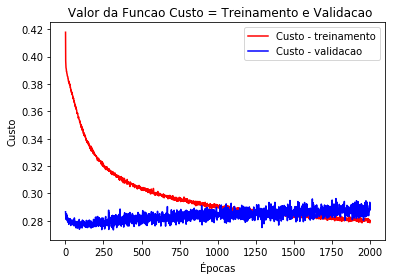

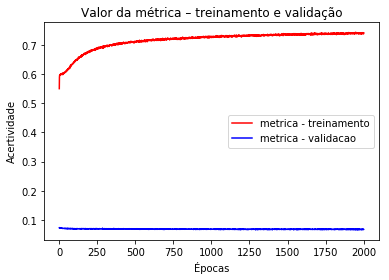

In [48]:
rna4.train(x_train_norm,y_train,x_val_norm,y_val,batch_size,epochs,loss,metric)
rna4.plot()

Confusion matrix, without normalization
[[24922  2063]
 [ 1497  1518]]


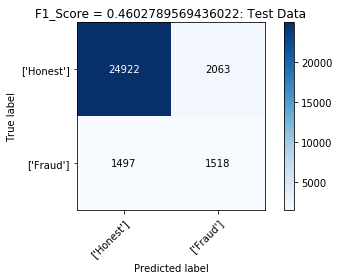

Confusion matrix, without normalization
[[24984  2002]
 [ 1499  1516]]


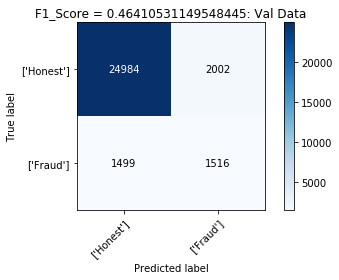

Confusion matrix, without normalization
[[119768   6163]
 [  7857  34347]]


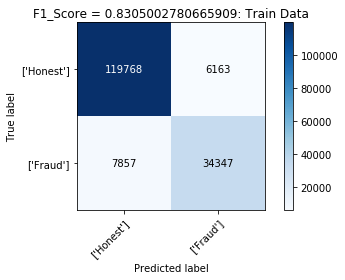

In [49]:
rna4.predict(x_data,y_data)

In [50]:
n_list5 = [100,100,100,1]
activation_list5 = ['tanh','tanh','tanh','sigmoid']
dropout_list5 = [0.3,0.3,0.3]

In [51]:
rna5 = new_rna()
rna5.build_model(data_shape,n_list5,activation_list5,dropout_list5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total para

Train on 168135 samples, validate on 30001 samples
Epoch 1/2000
168135/168135 [==============================] - 10s 58us/step - loss: 0.4143 - f1: 0.5505 - val_loss: 0.2856 - val_f1: 0.0721
Epoch 2/2000
168135/168135 [==============================] - 9s 53us/step - loss: 0.3940 - f1: 0.5864 - val_loss: 0.2769 - val_f1: 0.0707
Epoch 3/2000
168135/168135 [==============================] - 9s 53us/step - loss: 0.3911 - f1: 0.5936 - val_loss: 0.2812 - val_f1: 0.0716
Epoch 4/2000
168135/168135 [==============================] - 9s 53us/step - loss: 0.3896 - f1: 0.5940 - val_loss: 0.2805 - val_f1: 0.0709
Epoch 5/2000
168135/168135 [==============================] - 9s 53us/step - loss: 0.3882 - f1: 0.5985 - val_loss: 0.2790 - val_f1: 0.0712
Epoch 6/2000
168135/168135 [==============================] - 9s 54us/step - loss: 0.3879 - f1: 0.5971 - val_loss: 0.2812 - val_f1: 0.0711
Epoch 7/2000
168135/168135 [==============================] - 9s 52us/step - loss: 0.3870 - f1: 0.5980 - val_loss:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 9s 55us/step - loss: 0.3749 - f1: 0.6049 - val_loss: 0.2759 - val_f1: 0.0700
Epoch 29/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.3749 - f1: 0.6027 - val_loss: 0.2765 - val_f1: 0.0699
Epoch 30/2000
168135/168135 [==============================] - 9s 54us/step - loss: 0.3744 - f1: 0.6020 - val_loss: 0.2743 - val_f1: 0.0692
Epoch 31/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.3734 - f1: 0.6045 - val_loss: 0.2752 - val_f1: 0.0697
Epoch 32/2000
168135/168135 [==============================] - 9s 54us/step - loss: 0.3730 - f1: 0.6051 - val_loss: 0.2764 - val_f1: 0.0699
Epoch 33/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.3720 - f1: 0.6061 - val_loss: 0.2741 - val_f1: 0.0699
Epoch 34/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.3723 - f1: 0.6051 - val_loss: 0.2762 - val_f1: 0.0700
Epoch 35/2000
168135/168135 [=====

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 9s 55us/step - loss: 0.3367 - f1: 0.6554 - val_loss: 0.2673 - val_f1: 0.0670
Epoch 86/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.3364 - f1: 0.6569 - val_loss: 0.2673 - val_f1: 0.0670
Epoch 87/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.3354 - f1: 0.6562 - val_loss: 0.2681 - val_f1: 0.0671
Epoch 88/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.3334 - f1: 0.6603 - val_loss: 0.2686 - val_f1: 0.0672
Epoch 89/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.3334 - f1: 0.6618 - val_loss: 0.2680 - val_f1: 0.0669
Epoch 90/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.3328 - f1: 0.6599 - val_loss: 0.2667 - val_f1: 0.0665
Epoch 91/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.3327 - f1: 0.6610 - val_loss: 0.2675 - val_f1: 0.0667
Epoch 92/2000
168135/168135 [=====

168135/168135 [==============================] - 9s 55us/step - loss: 0.3011 - f1: 0.7053 - val_loss: 0.2700 - val_f1: 0.0646
Epoch 144/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.3014 - f1: 0.7030 - val_loss: 0.2701 - val_f1: 0.0648
Epoch 145/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.3010 - f1: 0.7051 - val_loss: 0.2729 - val_f1: 0.0656
Epoch 146/2000
131840/168135 [======================>.......] - ETA: 1s - loss: 0.3006 - f1: 0.7051

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 9s 56us/step - loss: 0.2974 - f1: 0.7101 - val_loss: 0.2724 - val_f1: 0.0656
Epoch 155/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2958 - f1: 0.7097 - val_loss: 0.2706 - val_f1: 0.0644
Epoch 156/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2951 - f1: 0.7127 - val_loss: 0.2699 - val_f1: 0.0642
Epoch 157/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2947 - f1: 0.7157 - val_loss: 0.2702 - val_f1: 0.0641
Epoch 158/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.2963 - f1: 0.7125 - val_loss: 0.2737 - val_f1: 0.0652
Epoch 159/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2941 - f1: 0.7153 - val_loss: 0.2705 - val_f1: 0.0646
Epoch 160/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2950 - f1: 0.7124 - val_loss: 0.2697 - val_f1: 0.0638
Epoch 161/2000
168135/16813

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 9s 55us/step - loss: 0.2859 - f1: 0.7250 - val_loss: 0.2725 - val_f1: 0.0645
Epoch 177/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.2886 - f1: 0.7217 - val_loss: 0.2732 - val_f1: 0.0644
Epoch 178/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2850 - f1: 0.7253 - val_loss: 0.2751 - val_f1: 0.0647
Epoch 179/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2875 - f1: 0.7211 - val_loss: 0.2736 - val_f1: 0.0641
Epoch 180/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2862 - f1: 0.7228 - val_loss: 0.2726 - val_f1: 0.0641
Epoch 181/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2859 - f1: 0.7234 - val_loss: 0.2751 - val_f1: 0.0643
Epoch 182/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2873 - f1: 0.7213 - val_loss: 0.2740 - val_f1: 0.0646
Epoch 183/2000
168135/16813

168135/168135 [==============================] - 9s 56us/step - loss: 0.2697 - f1: 0.7461 - val_loss: 0.2807 - val_f1: 0.0636
Epoch 235/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2699 - f1: 0.7452 - val_loss: 0.2806 - val_f1: 0.0635
Epoch 236/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.2706 - f1: 0.7431 - val_loss: 0.2798 - val_f1: 0.0635
Epoch 237/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2705 - f1: 0.7427 - val_loss: 0.2804 - val_f1: 0.0643
Epoch 238/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2694 - f1: 0.7462 - val_loss: 0.2802 - val_f1: 0.0635
Epoch 239/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2699 - f1: 0.7443 - val_loss: 0.2821 - val_f1: 0.0636
Epoch 240/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2683 - f1: 0.7469 - val_loss: 0.2809 - val_f1: 0.0634
Epoch 241/2000
168135/16813

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 9s 55us/step - loss: 0.2589 - f1: 0.7566 - val_loss: 0.2804 - val_f1: 0.0626
Epoch 296/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2563 - f1: 0.7619 - val_loss: 0.2857 - val_f1: 0.0631
Epoch 297/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2583 - f1: 0.7573 - val_loss: 0.2864 - val_f1: 0.0641
Epoch 298/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2553 - f1: 0.7612 - val_loss: 0.2868 - val_f1: 0.0625
Epoch 299/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.2564 - f1: 0.7593 - val_loss: 0.2830 - val_f1: 0.0621
Epoch 300/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2578 - f1: 0.7597 - val_loss: 0.2819 - val_f1: 0.0625
Epoch 301/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.2554 - f1: 0.7622 - val_loss: 0.2847 - val_f1: 0.0626
Epoch 302/2000
168135/1681

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 10s 57us/step - loss: 0.2546 - f1: 0.7634 - val_loss: 0.2861 - val_f1: 0.0625
Epoch 318/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.2540 - f1: 0.7628 - val_loss: 0.2887 - val_f1: 0.0621
Epoch 319/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.2551 - f1: 0.7618 - val_loss: 0.2847 - val_f1: 0.0621
Epoch 320/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2533 - f1: 0.7656 - val_loss: 0.2863 - val_f1: 0.0629
Epoch 321/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.2536 - f1: 0.7626 - val_loss: 0.2872 - val_f1: 0.0630
Epoch 322/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2532 - f1: 0.7645 - val_loss: 0.2887 - val_f1: 0.0626
Epoch 323/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.2528 - f1: 0.7626 - val_loss: 0.2836 - val_f1: 0.0624
Epoch 324/2000
168135/1

168135/168135 [==============================] - 10s 57us/step - loss: 0.2461 - f1: 0.7726 - val_loss: 0.2926 - val_f1: 0.0626
Epoch 376/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2467 - f1: 0.7707 - val_loss: 0.2930 - val_f1: 0.0618
Epoch 377/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2458 - f1: 0.7723 - val_loss: 0.2898 - val_f1: 0.0620
Epoch 378/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.2451 - f1: 0.7735 - val_loss: 0.2890 - val_f1: 0.0618
Epoch 379/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2461 - f1: 0.7753 - val_loss: 0.2901 - val_f1: 0.0624
Epoch 380/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.2454 - f1: 0.7742 - val_loss: 0.2919 - val_f1: 0.0617
Epoch 381/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2455 - f1: 0.7744 - val_loss: 0.2858 - val_f1: 0.0612
Epoch 382/2000
168135/168

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 9s 56us/step - loss: 0.2406 - f1: 0.7800 - val_loss: 0.2930 - val_f1: 0.0626
Epoch 424/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2417 - f1: 0.7756 - val_loss: 0.2924 - val_f1: 0.0625
Epoch 425/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2406 - f1: 0.7789 - val_loss: 0.2941 - val_f1: 0.0623
Epoch 426/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2403 - f1: 0.7792 - val_loss: 0.2935 - val_f1: 0.0624
Epoch 427/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.2395 - f1: 0.7793 - val_loss: 0.2894 - val_f1: 0.0612
Epoch 428/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.2401 - f1: 0.7788 - val_loss: 0.2882 - val_f1: 0.0620
Epoch 429/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2402 - f1: 0.7816 - val_loss: 0.2967 - val_f1: 0.0619
Epoch 430/2000
168135/1681

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 10s 57us/step - loss: 0.2372 - f1: 0.7810 - val_loss: 0.2939 - val_f1: 0.0613
Epoch 482/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2350 - f1: 0.7845 - val_loss: 0.2924 - val_f1: 0.0608
Epoch 483/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2358 - f1: 0.7840 - val_loss: 0.2941 - val_f1: 0.0610
Epoch 484/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2362 - f1: 0.7843 - val_loss: 0.2963 - val_f1: 0.0618
Epoch 485/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2357 - f1: 0.7861 - val_loss: 0.2953 - val_f1: 0.0606
Epoch 486/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2341 - f1: 0.7876 - val_loss: 0.2906 - val_f1: 0.0617
Epoch 487/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2353 - f1: 0.7855 - val_loss: 0.2983 - val_f1: 0.0626
Epoch 488/2000
168135/16813

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 9s 55us/step - loss: 0.2319 - f1: 0.7868 - val_loss: 0.2958 - val_f1: 0.0618
Epoch 529/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.2320 - f1: 0.7896 - val_loss: 0.2978 - val_f1: 0.0621
Epoch 530/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2320 - f1: 0.7878 - val_loss: 0.3021 - val_f1: 0.0619
Epoch 531/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2320 - f1: 0.7886 - val_loss: 0.2911 - val_f1: 0.0611
Epoch 532/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2312 - f1: 0.7887 - val_loss: 0.2995 - val_f1: 0.0616
Epoch 533/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2304 - f1: 0.7901 - val_loss: 0.2993 - val_f1: 0.0627
Epoch 534/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2325 - f1: 0.7873 - val_loss: 0.3008 - val_f1: 0.0616
Epoch 535/2000
168135/16813

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 9s 56us/step - loss: 0.2283 - f1: 0.7939 - val_loss: 0.2928 - val_f1: 0.0604
Epoch 576/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.2285 - f1: 0.7925 - val_loss: 0.3020 - val_f1: 0.0625
Epoch 577/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2284 - f1: 0.7941 - val_loss: 0.2944 - val_f1: 0.0621
Epoch 578/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.2279 - f1: 0.7948 - val_loss: 0.2999 - val_f1: 0.0619
Epoch 579/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2281 - f1: 0.7918 - val_loss: 0.3011 - val_f1: 0.0617
Epoch 580/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.2288 - f1: 0.7931 - val_loss: 0.2996 - val_f1: 0.0616
Epoch 581/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2290 - f1: 0.7908 - val_loss: 0.2999 - val_f1: 0.0623
Epoch 582/2000
168135/168

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 10s 57us/step - loss: 0.2259 - f1: 0.7936 - val_loss: 0.3017 - val_f1: 0.0610
Epoch 638/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2262 - f1: 0.7949 - val_loss: 0.3048 - val_f1: 0.0619
Epoch 639/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2253 - f1: 0.7963 - val_loss: 0.3020 - val_f1: 0.0619
Epoch 640/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2258 - f1: 0.7955 - val_loss: 0.3027 - val_f1: 0.0617
Epoch 641/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2248 - f1: 0.7962 - val_loss: 0.3082 - val_f1: 0.0624
Epoch 642/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2267 - f1: 0.7958 - val_loss: 0.2993 - val_f1: 0.0621
Epoch 643/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2236 - f1: 0.7975 - val_loss: 0.3009 - val_f1: 0.0614
Epoch 644/2000
168135/16813

168135/168135 [==============================] - 9s 56us/step - loss: 0.2234 - f1: 0.7964 - val_loss: 0.3007 - val_f1: 0.0618
Epoch 696/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2224 - f1: 0.7999 - val_loss: 0.3055 - val_f1: 0.0609
Epoch 697/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2221 - f1: 0.7993 - val_loss: 0.3083 - val_f1: 0.0615
Epoch 698/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2237 - f1: 0.8001 - val_loss: 0.3049 - val_f1: 0.0614
Epoch 699/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2245 - f1: 0.7953 - val_loss: 0.3037 - val_f1: 0.0619
Epoch 700/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2216 - f1: 0.7999 - val_loss: 0.3039 - val_f1: 0.0615
Epoch 701/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2233 - f1: 0.7978 - val_loss: 0.3055 - val_f1: 0.0616
Epoch 702/2000
168135/168135

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 9s 55us/step - loss: 0.2213 - f1: 0.8004 - val_loss: 0.3007 - val_f1: 0.0603
Epoch 725/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2193 - f1: 0.8028 - val_loss: 0.3042 - val_f1: 0.0614
Epoch 726/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2221 - f1: 0.7995 - val_loss: 0.3108 - val_f1: 0.0618
Epoch 727/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2208 - f1: 0.8005 - val_loss: 0.3028 - val_f1: 0.0607
Epoch 728/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2215 - f1: 0.7992 - val_loss: 0.3030 - val_f1: 0.0617
Epoch 729/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2197 - f1: 0.8006 - val_loss: 0.3043 - val_f1: 0.0610
Epoch 730/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2210 - f1: 0.8010 - val_loss: 0.2987 - val_f1: 0.0614
Epoch 731/2000
 59232/168135

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 9s 55us/step - loss: 0.2204 - f1: 0.8010 - val_loss: 0.3056 - val_f1: 0.0609
Epoch 740/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2207 - f1: 0.8001 - val_loss: 0.3051 - val_f1: 0.0620
Epoch 741/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2193 - f1: 0.8017 - val_loss: 0.3122 - val_f1: 0.0619
Epoch 742/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2202 - f1: 0.8011 - val_loss: 0.3054 - val_f1: 0.0611
Epoch 743/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2204 - f1: 0.8010 - val_loss: 0.3039 - val_f1: 0.0616
Epoch 744/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2199 - f1: 0.8026 - val_loss: 0.3075 - val_f1: 0.0619
Epoch 745/2000
125408/168135 [=====================>........] - ETA: 2s - loss: 0.2196 - f1: 0.8031

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 9s 55us/step - loss: 0.2211 - f1: 0.8010 - val_loss: 0.3056 - val_f1: 0.0617
Epoch 760/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2203 - f1: 0.8014 - val_loss: 0.3042 - val_f1: 0.0609
Epoch 761/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2218 - f1: 0.7998 - val_loss: 0.2969 - val_f1: 0.0606
Epoch 762/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2183 - f1: 0.8026 - val_loss: 0.3059 - val_f1: 0.0617
Epoch 763/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2206 - f1: 0.8020 - val_loss: 0.3023 - val_f1: 0.0612
Epoch 764/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2203 - f1: 0.7998 - val_loss: 0.3034 - val_f1: 0.0611
Epoch 765/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2195 - f1: 0.8037 - val_loss: 0.2994 - val_f1: 0.0617
Epoch 766/2000
168135/168135

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



168135/168135 [==============================] - 9s 55us/step - loss: 0.2192 - f1: 0.8014 - val_loss: 0.3062 - val_f1: 0.0609
Epoch 778/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2193 - f1: 0.8040 - val_loss: 0.3077 - val_f1: 0.0618
Epoch 779/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2188 - f1: 0.8037 - val_loss: 0.3072 - val_f1: 0.0619
Epoch 780/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2194 - f1: 0.8017 - val_loss: 0.3077 - val_f1: 0.0617
Epoch 781/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.2191 - f1: 0.8040 - val_loss: 0.3044 - val_f1: 0.0615
Epoch 782/2000
168135/168135 [==============================] - 11s 63us/step - loss: 0.2185 - f1: 0.8056 - val_loss: 0.3058 - val_f1: 0.0615
Epoch 783/2000
168135/168135 [==============================] - 17s 104us/step - loss: 0.2185 - f1: 0.8050 - val_loss: 0.3020 - val_f1: 0.0619
Epoch 784/2000
168135/16

Epoch 870/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.2168 - f1: 0.8048 - val_loss: 0.3072 - val_f1: 0.0616
Epoch 871/2000
168135/168135 [==============================] - 10s 61us/step - loss: 0.2153 - f1: 0.8051 - val_loss: 0.3070 - val_f1: 0.0603
Epoch 872/2000
168135/168135 [==============================] - 10s 62us/step - loss: 0.2156 - f1: 0.8058 - val_loss: 0.3058 - val_f1: 0.0608
Epoch 873/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.2137 - f1: 0.8073 - val_loss: 0.3112 - val_f1: 0.0610
Epoch 874/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.2158 - f1: 0.8065 - val_loss: 0.3099 - val_f1: 0.0619
Epoch 875/2000
168135/168135 [==============================] - 10s 61us/step - loss: 0.2157 - f1: 0.8052 - val_loss: 0.3082 - val_f1: 0.0607
Epoch 876/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.2162 - f1: 0.8073 - val_loss: 0.3060 - val_f1: 0.0604
Epoch 

168135/168135 [==============================] - 10s 61us/step - loss: 0.2145 - f1: 0.8074 - val_loss: 0.3098 - val_f1: 0.0610
Epoch 928/2000
168135/168135 [==============================] - 10s 61us/step - loss: 0.2131 - f1: 0.8071 - val_loss: 0.3103 - val_f1: 0.0609
Epoch 929/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.2126 - f1: 0.8094 - val_loss: 0.3043 - val_f1: 0.0598
Epoch 930/2000
168135/168135 [==============================] - 10s 61us/step - loss: 0.2141 - f1: 0.8070 - val_loss: 0.3062 - val_f1: 0.0608
Epoch 931/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.2151 - f1: 0.8074 - val_loss: 0.3107 - val_f1: 0.0600
Epoch 932/2000
168135/168135 [==============================] - 10s 61us/step - loss: 0.2134 - f1: 0.8079 - val_loss: 0.3112 - val_f1: 0.0616
Epoch 933/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.2155 - f1: 0.8067 - val_loss: 0.3063 - val_f1: 0.0612
Epoch 934/2000
168135

Epoch 985/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.2122 - f1: 0.8104 - val_loss: 0.3187 - val_f1: 0.0614
Epoch 986/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2129 - f1: 0.8123 - val_loss: 0.3136 - val_f1: 0.0607
Epoch 987/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.2130 - f1: 0.8080 - val_loss: 0.3043 - val_f1: 0.0601
Epoch 988/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2129 - f1: 0.8093 - val_loss: 0.3090 - val_f1: 0.0613
Epoch 989/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2109 - f1: 0.8096 - val_loss: 0.3047 - val_f1: 0.0603
Epoch 990/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.2127 - f1: 0.8101 - val_loss: 0.3092 - val_f1: 0.0608
Epoch 991/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2119 - f1: 0.8090 - val_loss: 0.3152 - val_f1: 0.0614
Epoch 992/

168135/168135 [==============================] - 10s 57us/step - loss: 0.2114 - f1: 0.8104 - val_loss: 0.3139 - val_f1: 0.0616
Epoch 1043/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2132 - f1: 0.8081 - val_loss: 0.3048 - val_f1: 0.0613
Epoch 1044/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.2104 - f1: 0.8110 - val_loss: 0.3090 - val_f1: 0.0601
Epoch 1045/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2100 - f1: 0.8131 - val_loss: 0.3105 - val_f1: 0.0607
Epoch 1046/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.2093 - f1: 0.8130 - val_loss: 0.3053 - val_f1: 0.0602
Epoch 1047/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.2111 - f1: 0.8107 - val_loss: 0.3028 - val_f1: 0.0597
Epoch 1048/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2105 - f1: 0.8120 - val_loss: 0.3110 - val_f1: 0.0604
Epoch 1049/2000
16

168135/168135 [==============================] - 10s 57us/step - loss: 0.2077 - f1: 0.8144 - val_loss: 0.3107 - val_f1: 0.0600
Epoch 1100/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2089 - f1: 0.8132 - val_loss: 0.3181 - val_f1: 0.0610
Epoch 1101/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.2090 - f1: 0.8120 - val_loss: 0.3119 - val_f1: 0.0606
Epoch 1102/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2088 - f1: 0.8128 - val_loss: 0.3164 - val_f1: 0.0612
Epoch 1103/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.2091 - f1: 0.8135 - val_loss: 0.3078 - val_f1: 0.0605
Epoch 1104/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.2099 - f1: 0.8121 - val_loss: 0.3112 - val_f1: 0.0604
Epoch 1105/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2099 - f1: 0.8118 - val_loss: 0.3112 - val_f1: 0.0600
Epoch 1106/2000
16

168135/168135 [==============================] - 9s 56us/step - loss: 0.2087 - f1: 0.8120 - val_loss: 0.3160 - val_f1: 0.0617
Epoch 1157/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.2091 - f1: 0.8150 - val_loss: 0.3097 - val_f1: 0.0604
Epoch 1158/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.2075 - f1: 0.8145 - val_loss: 0.3106 - val_f1: 0.0609
Epoch 1159/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2092 - f1: 0.8144 - val_loss: 0.3134 - val_f1: 0.0602
Epoch 1160/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2071 - f1: 0.8151 - val_loss: 0.3133 - val_f1: 0.0608
Epoch 1161/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2065 - f1: 0.8164 - val_loss: 0.3200 - val_f1: 0.0610
Epoch 1162/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.2068 - f1: 0.8151 - val_loss: 0.3113 - val_f1: 0.0597
Epoch 1163/2000
168

168135/168135 [==============================] - 9s 56us/step - loss: 0.2081 - f1: 0.8138 - val_loss: 0.3119 - val_f1: 0.0605
Epoch 1214/2000
168135/168135 [==============================] - 10s 58us/step - loss: 0.2052 - f1: 0.8150 - val_loss: 0.3147 - val_f1: 0.0595
Epoch 1215/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2090 - f1: 0.8135 - val_loss: 0.3116 - val_f1: 0.0609
Epoch 1216/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.2084 - f1: 0.8136 - val_loss: 0.3171 - val_f1: 0.0607
Epoch 1217/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.2054 - f1: 0.8177 - val_loss: 0.3123 - val_f1: 0.0607
Epoch 1218/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2076 - f1: 0.8145 - val_loss: 0.3148 - val_f1: 0.0613
Epoch 1219/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.2075 - f1: 0.8147 - val_loss: 0.3182 - val_f1: 0.0603
Epoch 1220/2000
16

168135/168135 [==============================] - 10s 57us/step - loss: 0.2051 - f1: 0.8190 - val_loss: 0.3069 - val_f1: 0.0597
Epoch 1271/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.2058 - f1: 0.8182 - val_loss: 0.3075 - val_f1: 0.0602
Epoch 1272/2000
168135/168135 [==============================] - 12s 70us/step - loss: 0.2052 - f1: 0.8178 - val_loss: 0.3196 - val_f1: 0.0607
Epoch 1273/2000
168135/168135 [==============================] - 11s 67us/step - loss: 0.2067 - f1: 0.8154 - val_loss: 0.3133 - val_f1: 0.0605
Epoch 1274/2000
168135/168135 [==============================] - 10s 62us/step - loss: 0.2061 - f1: 0.8166 - val_loss: 0.3122 - val_f1: 0.0609
Epoch 1275/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2037 - f1: 0.8175 - val_loss: 0.3165 - val_f1: 0.0603
Epoch 1276/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.2052 - f1: 0.8176 - val_loss: 0.3111 - val_f1: 0.0602
Epoch 1277/2000


168135/168135 [==============================] - 10s 57us/step - loss: 0.2031 - f1: 0.8187 - val_loss: 0.3134 - val_f1: 0.0603
Epoch 1328/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.2034 - f1: 0.8194 - val_loss: 0.3180 - val_f1: 0.0598
Epoch 1329/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2049 - f1: 0.8178 - val_loss: 0.3130 - val_f1: 0.0602
Epoch 1330/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.2034 - f1: 0.8191 - val_loss: 0.3191 - val_f1: 0.0603
Epoch 1331/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2041 - f1: 0.8177 - val_loss: 0.3093 - val_f1: 0.0599
Epoch 1332/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2055 - f1: 0.8187 - val_loss: 0.3106 - val_f1: 0.0600
Epoch 1333/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2044 - f1: 0.8188 - val_loss: 0.3208 - val_f1: 0.0605
Epoch 1334/2000
168

Epoch 1385/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.2032 - f1: 0.8202 - val_loss: 0.3133 - val_f1: 0.0598
Epoch 1386/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2046 - f1: 0.8174 - val_loss: 0.3141 - val_f1: 0.0592
Epoch 1387/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2036 - f1: 0.8185 - val_loss: 0.3127 - val_f1: 0.0590
Epoch 1388/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2019 - f1: 0.8217 - val_loss: 0.3130 - val_f1: 0.0595
Epoch 1389/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2037 - f1: 0.8172 - val_loss: 0.3145 - val_f1: 0.0596
Epoch 1390/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2029 - f1: 0.8190 - val_loss: 0.3090 - val_f1: 0.0598
Epoch 1391/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2037 - f1: 0.8177 - val_loss: 0.3137 - val_f1: 0.0600
Epoch

168135/168135 [==============================] - 9s 55us/step - loss: 0.2028 - f1: 0.8210 - val_loss: 0.3214 - val_f1: 0.0601
Epoch 1443/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.2024 - f1: 0.8198 - val_loss: 0.3188 - val_f1: 0.0609
Epoch 1444/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2010 - f1: 0.8230 - val_loss: 0.3210 - val_f1: 0.0599
Epoch 1445/2000
168135/168135 [==============================] - 10s 58us/step - loss: 0.2028 - f1: 0.8196 - val_loss: 0.3150 - val_f1: 0.0600
Epoch 1446/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2033 - f1: 0.8209 - val_loss: 0.3152 - val_f1: 0.0603
Epoch 1447/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.2031 - f1: 0.8209 - val_loss: 0.3191 - val_f1: 0.0595
Epoch 1448/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.2015 - f1: 0.8189 - val_loss: 0.3203 - val_f1: 0.0605
Epoch 1449/2000
168

168135/168135 [==============================] - 11s 68us/step - loss: 0.2012 - f1: 0.8220 - val_loss: 0.3161 - val_f1: 0.0597
Epoch 1500/2000
168135/168135 [==============================] - 11s 63us/step - loss: 0.2021 - f1: 0.8204 - val_loss: 0.3200 - val_f1: 0.0599
Epoch 1501/2000
168135/168135 [==============================] - 10s 61us/step - loss: 0.2004 - f1: 0.8219 - val_loss: 0.3187 - val_f1: 0.0599
Epoch 1502/2000
168135/168135 [==============================] - 10s 62us/step - loss: 0.2011 - f1: 0.8210 - val_loss: 0.3177 - val_f1: 0.0603
Epoch 1503/2000
168135/168135 [==============================] - 10s 61us/step - loss: 0.2012 - f1: 0.8201 - val_loss: 0.3194 - val_f1: 0.0597
Epoch 1504/2000
168135/168135 [==============================] - 10s 61us/step - loss: 0.2007 - f1: 0.8215 - val_loss: 0.3179 - val_f1: 0.0588
Epoch 1505/2000
168135/168135 [==============================] - 11s 63us/step - loss: 0.2013 - f1: 0.8195 - val_loss: 0.3166 - val_f1: 0.0595
Epoch 1506/2000

168135/168135 [==============================] - 10s 60us/step - loss: 0.1997 - f1: 0.8231 - val_loss: 0.3175 - val_f1: 0.0595
Epoch 1557/2000
168135/168135 [==============================] - 10s 61us/step - loss: 0.1993 - f1: 0.8241 - val_loss: 0.3172 - val_f1: 0.0600
Epoch 1558/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.2016 - f1: 0.8202 - val_loss: 0.3189 - val_f1: 0.0598
Epoch 1559/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.2017 - f1: 0.8200 - val_loss: 0.3189 - val_f1: 0.0602
Epoch 1560/2000
168135/168135 [==============================] - 10s 61us/step - loss: 0.2016 - f1: 0.8206 - val_loss: 0.3107 - val_f1: 0.0588
Epoch 1561/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.2019 - f1: 0.8201 - val_loss: 0.3178 - val_f1: 0.0597
Epoch 1562/2000
168135/168135 [==============================] - 10s 61us/step - loss: 0.1999 - f1: 0.8218 - val_loss: 0.3201 - val_f1: 0.0598
Epoch 1563/2000

168135/168135 [==============================] - 10s 59us/step - loss: 0.2006 - f1: 0.8226 - val_loss: 0.3165 - val_f1: 0.0596
Epoch 1614/2000
168135/168135 [==============================] - 10s 61us/step - loss: 0.2007 - f1: 0.8222 - val_loss: 0.3252 - val_f1: 0.0604
Epoch 1615/2000
168135/168135 [==============================] - 10s 61us/step - loss: 0.1997 - f1: 0.8244 - val_loss: 0.3246 - val_f1: 0.0600
Epoch 1616/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.1997 - f1: 0.8250 - val_loss: 0.3170 - val_f1: 0.0591
Epoch 1617/2000
168135/168135 [==============================] - 10s 61us/step - loss: 0.1989 - f1: 0.8239 - val_loss: 0.3238 - val_f1: 0.0603
Epoch 1618/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.1991 - f1: 0.8241 - val_loss: 0.3195 - val_f1: 0.0607
Epoch 1619/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.1999 - f1: 0.8218 - val_loss: 0.3189 - val_f1: 0.0595
Epoch 1620/2000

168135/168135 [==============================] - 10s 61us/step - loss: 0.1989 - f1: 0.8245 - val_loss: 0.3156 - val_f1: 0.0586
Epoch 1671/2000
168135/168135 [==============================] - 10s 59us/step - loss: 0.1974 - f1: 0.8267 - val_loss: 0.3192 - val_f1: 0.0597
Epoch 1672/2000
168135/168135 [==============================] - 10s 61us/step - loss: 0.2003 - f1: 0.8232 - val_loss: 0.3169 - val_f1: 0.0594
Epoch 1673/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.1991 - f1: 0.8246 - val_loss: 0.3136 - val_f1: 0.0590
Epoch 1674/2000
168135/168135 [==============================] - 10s 60us/step - loss: 0.1998 - f1: 0.8237 - val_loss: 0.3135 - val_f1: 0.0589
Epoch 1675/2000
168135/168135 [==============================] - 10s 61us/step - loss: 0.1983 - f1: 0.8229 - val_loss: 0.3224 - val_f1: 0.0599
Epoch 1676/2000
168135/168135 [==============================] - 10s 61us/step - loss: 0.2014 - f1: 0.8211 - val_loss: 0.3223 - val_f1: 0.0601
Epoch 1677/2000

168135/168135 [==============================] - 10s 57us/step - loss: 0.1961 - f1: 0.8267 - val_loss: 0.3282 - val_f1: 0.0604
Epoch 1728/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.1976 - f1: 0.8255 - val_loss: 0.3206 - val_f1: 0.0591
Epoch 1729/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.1988 - f1: 0.8246 - val_loss: 0.3182 - val_f1: 0.0593
Epoch 1730/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.1993 - f1: 0.8235 - val_loss: 0.3242 - val_f1: 0.0593
Epoch 1731/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.1977 - f1: 0.8239 - val_loss: 0.3180 - val_f1: 0.0597
Epoch 1732/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.2000 - f1: 0.8237 - val_loss: 0.3219 - val_f1: 0.0601
Epoch 1733/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.1991 - f1: 0.8243 - val_loss: 0.3179 - val_f1: 0.0591
Epoch 1734/2000
168

168135/168135 [==============================] - 10s 57us/step - loss: 0.1966 - f1: 0.8270 - val_loss: 0.3153 - val_f1: 0.0597
Epoch 1785/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.1985 - f1: 0.8244 - val_loss: 0.3237 - val_f1: 0.0593
Epoch 1786/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.1987 - f1: 0.8245 - val_loss: 0.3257 - val_f1: 0.0598
Epoch 1787/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.1984 - f1: 0.8242 - val_loss: 0.3148 - val_f1: 0.0584
Epoch 1788/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.1983 - f1: 0.8245 - val_loss: 0.3226 - val_f1: 0.0603
Epoch 1789/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.1969 - f1: 0.8256 - val_loss: 0.3187 - val_f1: 0.0586
Epoch 1790/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.1978 - f1: 0.8261 - val_loss: 0.3169 - val_f1: 0.0600
Epoch 1791/2000
1681

168135/168135 [==============================] - 10s 57us/step - loss: 0.1970 - f1: 0.8264 - val_loss: 0.3209 - val_f1: 0.0594
Epoch 1842/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.1962 - f1: 0.8259 - val_loss: 0.3142 - val_f1: 0.0589
Epoch 1843/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.1965 - f1: 0.8258 - val_loss: 0.3202 - val_f1: 0.0584
Epoch 1844/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.1974 - f1: 0.8244 - val_loss: 0.3198 - val_f1: 0.0600
Epoch 1845/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.1979 - f1: 0.8262 - val_loss: 0.3244 - val_f1: 0.0599
Epoch 1846/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.1959 - f1: 0.8269 - val_loss: 0.3255 - val_f1: 0.0591
Epoch 1847/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.1972 - f1: 0.8244 - val_loss: 0.3177 - val_f1: 0.0602
Epoch 1848/2000
168

168135/168135 [==============================] - 9s 55us/step - loss: 0.1965 - f1: 0.8268 - val_loss: 0.3282 - val_f1: 0.0603
Epoch 1899/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.1951 - f1: 0.8282 - val_loss: 0.3278 - val_f1: 0.0594
Epoch 1900/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.1967 - f1: 0.8264 - val_loss: 0.3246 - val_f1: 0.0592
Epoch 1901/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.1964 - f1: 0.8275 - val_loss: 0.3234 - val_f1: 0.0594
Epoch 1902/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.1958 - f1: 0.8291 - val_loss: 0.3183 - val_f1: 0.0599
Epoch 1903/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.1951 - f1: 0.8289 - val_loss: 0.3209 - val_f1: 0.0590
Epoch 1904/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.1964 - f1: 0.8273 - val_loss: 0.3205 - val_f1: 0.0596
Epoch 1905/2000
168

Epoch 1956/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.1950 - f1: 0.8290 - val_loss: 0.3248 - val_f1: 0.0596
Epoch 1957/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.1947 - f1: 0.8294 - val_loss: 0.3235 - val_f1: 0.0596
Epoch 1958/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.1952 - f1: 0.8274 - val_loss: 0.3205 - val_f1: 0.0601
Epoch 1959/2000
168135/168135 [==============================] - 9s 56us/step - loss: 0.1954 - f1: 0.8278 - val_loss: 0.3228 - val_f1: 0.0595
Epoch 1960/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.1955 - f1: 0.8274 - val_loss: 0.3195 - val_f1: 0.0601
Epoch 1961/2000
168135/168135 [==============================] - 9s 55us/step - loss: 0.1966 - f1: 0.8277 - val_loss: 0.3277 - val_f1: 0.0602
Epoch 1962/2000
168135/168135 [==============================] - 10s 57us/step - loss: 0.1963 - f1: 0.8271 - val_loss: 0.3210 - val_f1: 0.0599
Epo

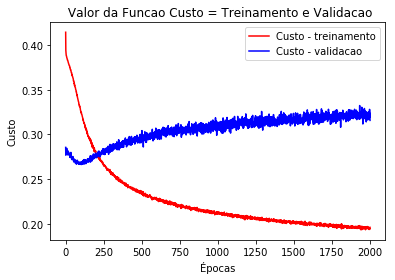

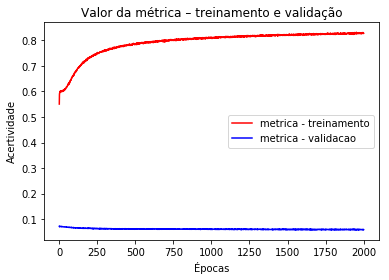

In [52]:
rna5.train(x_train_norm,y_train,x_val_norm,y_val,batch_size,epochs,loss,metric)
rna5.plot()

Confusion matrix, without normalization
[[25550  1435]
 [ 1771  1244]]


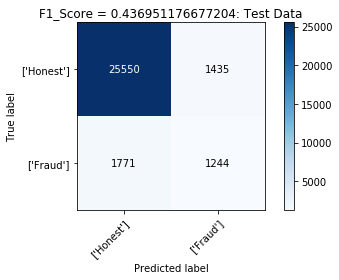

Confusion matrix, without normalization
[[25560  1426]
 [ 1756  1259]]


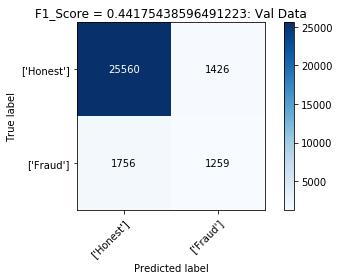

Confusion matrix, without normalization
[[123932   1999]
 [  2079  40125]]


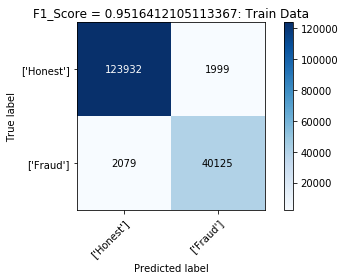

In [53]:
rna5.predict(x_data,y_data)